In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/C247-NNDL/

/content/drive/MyDrive/C247-NNDL


# IMPORTS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from matplotlib.collections import LineCollection

from sklearn.metrics import accuracy_score

%pylab inline

import torch
import torch.nn as nn
import torch.autograd as autograd
import torchvision
import torchvision.models as models
import torchvision.transforms as T
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.modules.activation import LeakyReLU

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir="Results/runs")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Populating the interactive namespace from numpy and matplotlib


# DATA PREPROCESSING AND RESHAPING

In [ ]:
## Loading the numpy arrays corresponding to the EEG dataset

X_test = np.load("./Dataset/X_test.npy")
y_test = np.load("./Dataset/y_test.npy")
person_train_valid = np.load("./Dataset/person_train_valid.npy")
X_train_valid = np.load("./Dataset/X_train_valid.npy")
y_train_valid = np.load("./Dataset/y_train_valid.npy")
person_test = np.load("./Dataset/person_test.npy")

## Printing the shapes of the numpy arrays

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [ ]:
## Adjusting the labels to {0,1,2,3}

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

# DATA PREPROCESSING AND AUGMENTATION

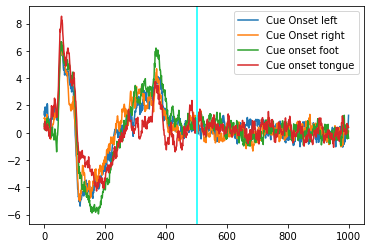

In [ ]:

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [ ]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y

In [ ]:
## Preprocessing the dataset

X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)

Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
(8460, 22, 250)
(8460,)
(1772, 22, 250)
(1772,)


# CREATING TRAIN AND VALIDATION

WITH PREPROCESSING

In [ ]:
## Creating the training and validation sets

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

X_test = X_test_prep
y_test = y_test_prep

print('Shape of test set:',X_test.shape)
print('Shape of test labels:',y_test.shape)

Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of test set: (1772, 22, 250)
Shape of test labels: (1772,)


# VISUALIZING A SAMPLE EEG DATA

In [ ]:
# Taken from: https://notebook.community/joannekoong/neuroscience_tutorials/basic/1.%20Load%20EEG%20data%20and%20plot%20ERP

def plot_eeg(EEG, vspace=100, color='k'):   
    bases = vspace * np.arange(22)    
    EEG = EEG.T + bases
    
    # Calculate a timeline in seconds, assuming that the sample rate of the EEG recorder was 2048 Hz.
    samplerate = 2048
    time = arange(EEG.shape[0]) / samplerate
    
    # Plot EEG versus time
    plot(time, EEG, color=color)
    grid()
    xlabel('Time (s)')
    ylabel('Channels')
    gca().yaxis.set_ticks(bases)
    title('EEG data for a single sample')

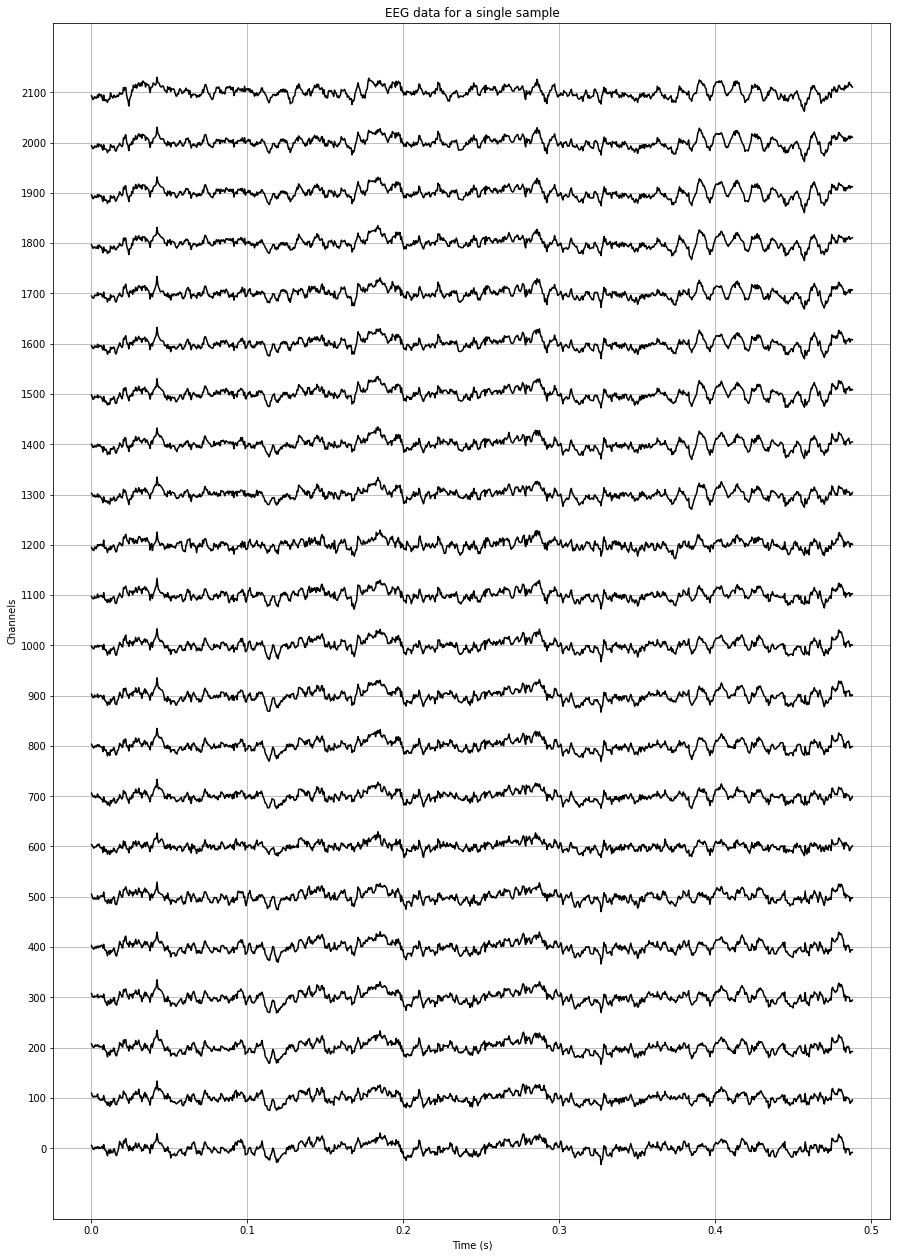

In [ ]:
figure(figsize=(15,22))
plot_eeg(X_train_valid[0])

# DATALOADER

In [ ]:
# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(X_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of training set after dimension reshaping: (6960, 250, 22)
Shape of validation set after dimension reshaping: (1500, 250, 22)
Shape of test set after dimension reshaping: (1772, 250, 22)


In [ ]:
# Normalize each channel to have mean 0 and std 1
def standardize(x):
    mean = np.mean(x, axis=1)
    var = np.var(x, axis=1)

    return (x - mean[:, None]) / np.sqrt(var)[:, None]

x_train = standardize(x_train)
x_valid = standardize(x_valid)
x_test = standardize(x_test)

In [ ]:
class LoadData(Dataset):
    def __init__(self, data, labels):
        self.data = torch.Tensor(data)
        self.labels = labels

    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, index: int):
        input_data = self.data[index].permute(1,0)
        input_label = self.labels[index]
        return (input_data, input_label)

In [ ]:
train_dataset = LoadData(data=x_train, labels=y_train,)
val_dataset = LoadData(data=x_valid, labels=y_valid,)
train_dl = DataLoader(train_dataset, batch_size=16, num_workers=1, pin_memory=True, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=16, num_workers=1, pin_memory=True)

data = next(iter(train_dl))
input_data, input_labels = data
print(input_data.size())

torch.Size([16, 22, 250])


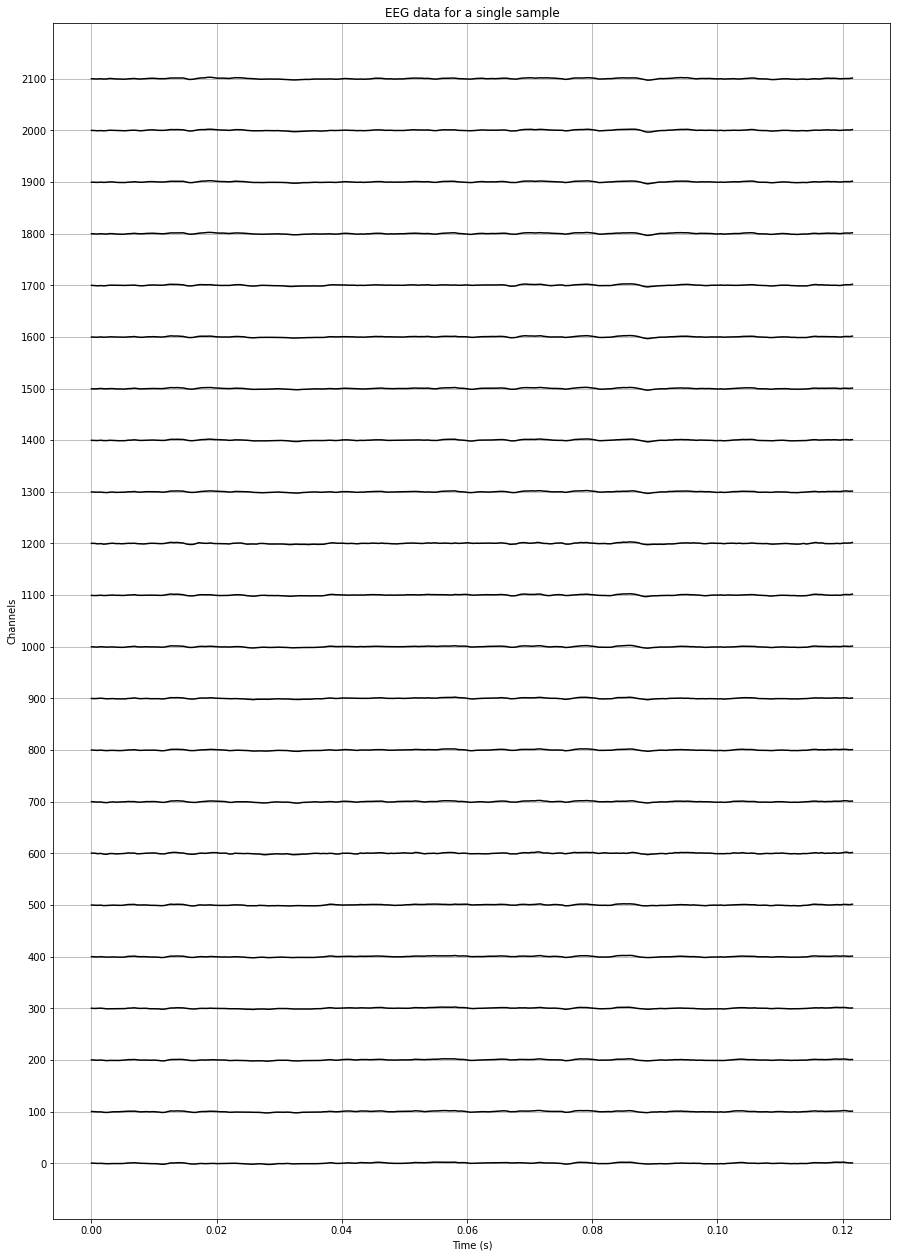

In [ ]:
figure(figsize=(15,22))
plot_eeg(data[0][14])

# DCGAN

1D

In [ ]:
class DCGANGen(nn.Module):
    def __init__(self, noise_dim=100):
        super(DCGANGen, self).__init__()

        self.fc1 = nn.Linear(in_features=noise_dim, out_features=352 * 14)
        self.bnorm1 = nn.BatchNorm1d(352 * 14)
        self.relu1 = nn.LeakyReLU(0.3)
        self.dropout1 = nn.Dropout(p=0.5)

        self.deconv1 = nn.ConvTranspose1d(352, 176, 5, stride=2, padding=1, output_padding=1, bias=False)
        self.bnorm2 = nn.BatchNorm1d(176)
        self.relu2 = nn.LeakyReLU(0.3)
        self.dropout2 = nn.Dropout(p=0.5)

        self.deconv2 = nn.ConvTranspose1d(176, 88, 5, stride=2, padding=1, output_padding=1, bias=False)
        self.bnorm3 = nn.BatchNorm1d(88)
        self.relu3 = nn.LeakyReLU(0.3)
        self.dropout3 = nn.Dropout(p=0.5)

        self.deconv3 = nn.ConvTranspose1d(88, 44, 5, stride=2, padding=2, output_padding=1, bias=False)
        self.bnorm4 = nn.BatchNorm1d(44)
        self.relu4 = nn.LeakyReLU(0.3)
        self.dropout4 = nn.Dropout(p=0.5)

        self.deconv4 = nn.ConvTranspose1d(44, 22, 5, stride=2, padding=1, output_padding=1, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, x):
        h = x
        h = self.fc1(h)
        h = self.bnorm1(h)
        h = self.relu1(h)
        h = torch.reshape(h, (64, 352, 14))
        h = self.dropout1(h)
        # print(h.shape)

        h = self.deconv1(h)
        h = self.bnorm2(h)
        h = self.relu2(h)
        h = self.dropout2(h)
        # print(h.shape)

        h = self.deconv2(h)
        h = self.bnorm3(h)
        h = self.relu3(h)
        h = self.dropout3(h)
        # print(h.shape)

        h = self.deconv3(h)
        h = self.bnorm4(h)
        h = self.relu4(h)
        h = self.dropout4(h)
        # print(h.shape)
        
        h = self.deconv4(h)
        h = self.tanh(h)
        # print(h.shape)

        return h

class DCGANDis(nn.Module):
    def __init__(self):
        super(DCGANDis, self).__init__()

        self.conv1 = nn.Conv1d(22, 64, 2, stride=2, padding=0)
        self.bnorm1 = nn.BatchNorm1d(64)
        self.relu1 = LeakyReLU(0.3)

        self.conv2 = nn.Conv1d(64, 128, 2, stride=2, padding=0)
        self.bnorm2 = nn.BatchNorm1d(128)
        self.relu2 = LeakyReLU(0.3)

        self.conv3 = nn.Conv1d(128, 256, 2, stride=2, padding=0)
        self.bnorm3 = nn.BatchNorm1d(256)
        self.relu3 = LeakyReLU(0.3)

        self.conv4 = nn.Conv1d(256, 512, 2, stride=2, padding=0)
        self.bnorm4 = nn.BatchNorm1d(512)
        self.relu4 = LeakyReLU(0.3)

        self.dropout1 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(7680, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        h = x
        h = self.conv1(h)
        h = self.bnorm1(h)
        h = self.relu1(h)

        h = self.conv2(h)
        h = self.bnorm2(h)
        h = self.relu2(h)

        h = self.conv3(h)
        h = self.bnorm3(h)
        h = self.relu3(h)

        h = self.conv4(h)
        h = self.bnorm4(h)
        h = self.relu4(h)

        h = torch.flatten(h, 1)

        h = self.dropout1(h)
        h = self.fc1(h)
        h = self.sigmoid(h)

        return h

# TRAINING

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Conv1d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)    
    elif isinstance(m, nn.ConvTranspose1d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

DCGAN

In [ ]:
class Trainer:
    def __init__(self, epochs, batch_size, learning_rate, num_workers, train_data, valid_data, train_labels, valid_labels, patience, validate_after):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_workers = num_workers
        self.train_data = train_data
        self.valid_data = valid_data
        self.train_labels = train_labels
        self.valid_labels = valid_labels
        self.real_label = 1
        self.fake_label = 0

    def train(self):
        train_dataset = LoadData(data=self.train_data, labels=self.train_labels)
        train_dataloader = DataLoader(train_dataset, batch_size=self.batch_size, num_workers=self.num_workers,pin_memory=True)
        # Model
        model_G = DCGANGen().to(device)
        model_D = DCGANDis().to(device)
        model_G.apply(weights_init)
        model_D.apply(weights_init)

        optimizer_G = torch.optim.Adam(model_G.parameters(),
                             lr=self.learning_rate, betas=(0.5, 0.999),
                             eps=1e-8, weight_decay=0)
        optimizer_D = torch.optim.Adam(model_D.parameters(),
                             lr=self.learning_rate, betas=(0.5, 0.999),
                             eps=1e-8, weight_decay=0)
        
        # Loss function to use
        criterion = nn.BCELoss()
        # You may also use a combination of more than one loss function 
        # or create your own.

        model_G.train()
        model_D.train()


        # train loop
        for epoch in range(self.epochs):
            print("Starting Training Epoch " + str(epoch + 1))
            # loop_start = time.time()
            # avg_loss = 0.0
            # main_start = time.time()
            for i, data in enumerate(tqdm(train_dataloader)):                                                    #(train_dataloader, 0)?
                if i == len(train_dataloader) - 1:
                    continue
                inputs, targets = data
                inputs = inputs.to(device, dtype=torch.float64)
                targets = targets.to(device, dtype=torch.long)
                # print(targets.shape)

                model_D.zero_grad()
                label = torch.full(targets.shape, self.real_label, dtype=torch.float, device=device)
                label -= 0.3 + (torch.rand(label.shape, device=device) * 0.5)                         # label smoothing
                output = model_D(inputs.float()).view(-1)
                # print(output.shape)
                errD_real = criterion(output, label)
                errD_real.backward()
                # train with fake
                noise = torch.randn(inputs.shape[0], 100, device=device)
                fake = model_G(noise)
                # print(fake.shape)
                label.fill_(self.fake_label)
                label = label + torch.rand(label.shape, device=device) * 0.3                         # label smoothing
                # Classify all fake batch with D
                output = model_D(fake.detach()).view(-1)
                # Calculate D's loss on the all-fake batch
                errD_fake = criterion(output, label)
                # Calculate the gradients for this batch, accumulated (summed) with previous gradients
                errD_fake.backward()
                # Compute error of D as sum over the fake and the real batches
                errD = errD_real + errD_fake
                # Update D
                optimizer_D.step()

                ########################
                # update G network
                ########################
                model_G.zero_grad()
                label.fill_(self.real_label)  # fake labels are real for generator cost
                label = label - 0.3 + (torch.rand(label.shape, device=device) * 0.5)                         # label smoothing
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output = model_D(fake)
                # Calculate G's loss based on this output
                # print(output.shape)
                # print(label.shape)
                output=torch.reshape(output, label.shape)
                errG = criterion(output, label)
                # Calculate gradients for G
                errG.backward()
                # Update G
                optimizer_G.step()                                                                       # Update the weights

                # avg_loss += loss.item()

            print(f'Training: Epoch {epoch + 1} \t\t Discriminator Loss: {\
                errD / len(train_dataloader)}  \t\t Generator Loss: {\
                errG / len(train_dataloader)}')
            
            if (epoch + 1) % 1 == 0:
                errD_val, errG_val, val_len = self.validate(model_D, model_G, criterion)
                print(f'Validation: Epoch {epoch + 1} \t\t Discriminator Loss: {\
                        errD_val / val_len}  \t\t Generator Loss: {\
                        errG_val / val_len}')
                # model.eval()
                # for i, data in enumerate(tqdm(val_dataloader))
                
            torch.save(model_G.state_dict(), './Results/Model_GAN/Generator_DCGAN/saved_model_' + str(epoch + 1) + '.pth')
            torch.save(model_D.state_dict(), './Results/Model_GAN/Discriminator/saved_model_' + str(epoch + 1) + '.pth')


    def validate(self, model_D, model_G, criterion):
        # Validation loop begin
        # ------
        # Validation loop end
        # ------
        # Determine your evaluation metrics on the validation dataset.
        model_G.eval()
        model_D.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_dataset = LoadData(data=self.valid_data, labels=self.valid_labels)
            val_dataloader = DataLoader(val_dataset, batch_size=self.batch_size, num_workers=self.num_workers,pin_memory=True)
            for i, data in enumerate(val_dataloader):
                if i == len(val_dataloader) - 1:
                    continue
                inputs, targets = data
                inputs = inputs.to(device, dtype=torch.float64)
                targets = targets.to(device, dtype=torch.long)

                label = torch.full(targets.shape, self.real_label, dtype=torch.float, device=device)
                label -= 0.3 + (torch.rand(label.shape, device=device) * 0.5)

                output = model_D(inputs.float()).view(-1)
                # print(output.shape)
                errD_real = criterion(output, label)
                # errD_real.backward()

                # train with fake
                # noise = torch.randn(self.batch_size, 100, 1, 1, device=device)
                # Generate fake image batch with G
                noise = torch.randn(inputs.shape[0], 100, device=device)
                fake = model_G(noise)

                label.fill_(self.fake_label)
                label = label + torch.rand(label.shape, device=device) * 0.3

                # Classify all fake batch with D
                output = model_D(fake.detach()).view(-1)
                # Calculate D's loss on the all-fake batch
                errD_fake = criterion(output, label)
                # Calculate the gradients for this batch, accumulated (summed) with previous gradients
                # errD_fake.backward()
                # Compute error of D as sum over the fake and the real batches
                errD = errD_real + errD_fake
                # Update D
                # optimizer_D.step()

                ########################
                # update G network
                ########################
                # model_G.zero_grad()
                label.fill_(self.real_label)  # fake labels are real for generator cost
                label = label - 0.3 + (torch.rand(label.shape, device=device) * 0.5)
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output = model_D(fake)
                # Calculate G's loss based on this output
                output=torch.reshape(output, label.shape)
                errG = criterion(output, label)
                # Calculate gradients for G
                # errG.backward()
                # Update G
                # optimizer_G.step()

        # model.train()
        return errD, errG, len(val_dataloader)

In [ ]:
trainer = Trainer(epochs = 1000, batch_size = 64, learning_rate = 2e-4, num_workers = 2, train_data=x_train, valid_data=x_valid, train_labels=y_train, valid_labels=y_valid, patience=5, validate_after=1)

In [ ]:
best_model = trainer.train()
writer.flush()

Starting Training Epoch 1


100%|██████████| 109/109 [00:03<00:00, 35.85it/s]

Training: Epoch 1 		 Discriminator Loss: 0.010753215290606022  		 Generator Loss: 0.015455254353582859


Validation: Epoch 1 		 Discriminator Loss: 0.05526108294725418  		 Generator Loss: 0.06081034988164902
Starting Training Epoch 2


100%|██████████| 109/109 [00:04<00:00, 26.12it/s]

Training: Epoch 2 		 Discriminator Loss: 0.01025370229035616  		 Generator Loss: 0.016939416527748108


Validation: Epoch 2 		 Discriminator Loss: 0.0463155172765255  		 Generator Loss: 0.06623389571905136
Starting Training Epoch 3


100%|██████████| 109/109 [00:02<00:00, 42.06it/s]

Training: Epoch 3 		 Discriminator Loss: 0.01036669872701168  		 Generator Loss: 0.018681202083826065


Validation: Epoch 3 		 Discriminator Loss: 0.046994321048259735  		 Generator Loss: 0.07435895502567291
Starting Training Epoch 4


100%|██████████| 109/109 [00:02<00:00, 42.77it/s]

Training: Epoch 4 		 Discriminator Loss: 0.010149565525352955  		 Generator Loss: 0.019877152517437935


Validation: Epoch 4 		 Discriminator Loss: 0.04728679358959198  		 Generator Loss: 0.08534684777259827
Starting Training Epoch 5


100%|██████████| 109/109 [00:02<00:00, 42.87it/s]

Training: Epoch 5 		 Discriminator Loss: 0.010288713499903679  		 Generator Loss: 0.01855889894068241


Validation: Epoch 5 		 Discriminator Loss: 0.045430660247802734  		 Generator Loss: 0.08234672248363495
Starting Training Epoch 6


100%|██████████| 109/109 [00:02<00:00, 42.38it/s]

Training: Epoch 6 		 Discriminator Loss: 0.010252083651721478  		 Generator Loss: 0.018326804041862488


Validation: Epoch 6 		 Discriminator Loss: 0.04421143978834152  		 Generator Loss: 0.0757087841629982
Starting Training Epoch 7


100%|██████████| 109/109 [00:02<00:00, 43.41it/s]

Training: Epoch 7 		 Discriminator Loss: 0.010514826513826847  		 Generator Loss: 0.01572919450700283


Validation: Epoch 7 		 Discriminator Loss: 0.04560832306742668  		 Generator Loss: 0.06758403033018112
Starting Training Epoch 8


100%|██████████| 109/109 [00:02<00:00, 44.06it/s]

Training: Epoch 8 		 Discriminator Loss: 0.010490898042917252  		 Generator Loss: 0.014245863072574139


Validation: Epoch 8 		 Discriminator Loss: 0.04749351739883423  		 Generator Loss: 0.06494127213954926
Starting Training Epoch 9


100%|██████████| 109/109 [00:02<00:00, 42.81it/s]


Training: Epoch 9 		 Discriminator Loss: 0.010178081691265106  		 Generator Loss: 0.017575044184923172
Validation: Epoch 9 		 Discriminator Loss: 0.046042364090681076  		 Generator Loss: 0.07751799374818802
Starting Training Epoch 10


100%|██████████| 109/109 [00:02<00:00, 42.33it/s]

Training: Epoch 10 		 Discriminator Loss: 0.010408028960227966  		 Generator Loss: 0.01557998638600111


Validation: Epoch 10 		 Discriminator Loss: 0.04553882032632828  		 Generator Loss: 0.07099542021751404
Starting Training Epoch 11


100%|██████████| 109/109 [00:02<00:00, 42.99it/s]

Training: Epoch 11 		 Discriminator Loss: 0.010135727003216743  		 Generator Loss: 0.016513291746377945


Validation: Epoch 11 		 Discriminator Loss: 0.04675495624542236  		 Generator Loss: 0.07322528958320618
Starting Training Epoch 12


100%|██████████| 109/109 [00:02<00:00, 43.54it/s]

Training: Epoch 12 		 Discriminator Loss: 0.009954788722097874  		 Generator Loss: 0.017591319978237152


Validation: Epoch 12 		 Discriminator Loss: 0.04574551433324814  		 Generator Loss: 0.0773121789097786
Starting Training Epoch 13


100%|██████████| 109/109 [00:02<00:00, 41.92it/s]

Training: Epoch 13 		 Discriminator Loss: 0.010251746512949467  		 Generator Loss: 0.018122928217053413


Validation: Epoch 13 		 Discriminator Loss: 0.04796462506055832  		 Generator Loss: 0.08188540488481522
Starting Training Epoch 14


100%|██████████| 109/109 [00:02<00:00, 43.61it/s]

Training: Epoch 14 		 Discriminator Loss: 0.009862363338470459  		 Generator Loss: 0.019421204924583435


Validation: Epoch 14 		 Discriminator Loss: 0.046509724110364914  		 Generator Loss: 0.08708735555410385
Starting Training Epoch 15


100%|██████████| 109/109 [00:02<00:00, 42.42it/s]

Training: Epoch 15 		 Discriminator Loss: 0.010039227083325386  		 Generator Loss: 0.017814354971051216


Validation: Epoch 15 		 Discriminator Loss: 0.0477106086909771  		 Generator Loss: 0.08387129753828049
Starting Training Epoch 16


100%|██████████| 109/109 [00:02<00:00, 43.27it/s]

Training: Epoch 16 		 Discriminator Loss: 0.010127371177077293  		 Generator Loss: 0.017738861963152885


Validation: Epoch 16 		 Discriminator Loss: 0.04593462496995926  		 Generator Loss: 0.0796365886926651
Starting Training Epoch 17


100%|██████████| 109/109 [00:02<00:00, 42.51it/s]

Training: Epoch 17 		 Discriminator Loss: 0.009830369614064693  		 Generator Loss: 0.017596503719687462


Validation: Epoch 17 		 Discriminator Loss: 0.045710474252700806  		 Generator Loss: 0.08010467886924744
Starting Training Epoch 18


100%|██████████| 109/109 [00:02<00:00, 42.88it/s]


Training: Epoch 18 		 Discriminator Loss: 0.009996584616601467  		 Generator Loss: 0.017480213195085526
Validation: Epoch 18 		 Discriminator Loss: 0.04528443515300751  		 Generator Loss: 0.0822131335735321
Starting Training Epoch 19


100%|██████████| 109/109 [00:02<00:00, 43.59it/s]

Training: Epoch 19 		 Discriminator Loss: 0.010284963995218277  		 Generator Loss: 0.016228055581450462


Validation: Epoch 19 		 Discriminator Loss: 0.045675069093704224  		 Generator Loss: 0.07351087033748627
Starting Training Epoch 20


100%|██████████| 109/109 [00:02<00:00, 43.14it/s]

Training: Epoch 20 		 Discriminator Loss: 0.009947401471436024  		 Generator Loss: 0.017033105716109276


Validation: Epoch 20 		 Discriminator Loss: 0.04579200595617294  		 Generator Loss: 0.07965320348739624
Starting Training Epoch 21


100%|██████████| 109/109 [00:02<00:00, 42.76it/s]

Training: Epoch 21 		 Discriminator Loss: 0.010056573897600174  		 Generator Loss: 0.017519254237413406


Validation: Epoch 21 		 Discriminator Loss: 0.04771154373884201  		 Generator Loss: 0.07938331365585327
Starting Training Epoch 22


100%|██████████| 109/109 [00:02<00:00, 43.25it/s]

Training: Epoch 22 		 Discriminator Loss: 0.0101322578266263  		 Generator Loss: 0.016318706795573235


Validation: Epoch 22 		 Discriminator Loss: 0.04732486233115196  		 Generator Loss: 0.07641109079122543
Starting Training Epoch 23


100%|██████████| 109/109 [00:02<00:00, 42.85it/s]

Training: Epoch 23 		 Discriminator Loss: 0.010123280808329582  		 Generator Loss: 0.016777440905570984


Validation: Epoch 23 		 Discriminator Loss: 0.04746729135513306  		 Generator Loss: 0.07598839700222015
Starting Training Epoch 24


100%|██████████| 109/109 [00:02<00:00, 42.76it/s]

Training: Epoch 24 		 Discriminator Loss: 0.010324844159185886  		 Generator Loss: 0.01597927138209343


Validation: Epoch 24 		 Discriminator Loss: 0.0465778112411499  		 Generator Loss: 0.07062260061502457
Starting Training Epoch 25


100%|██████████| 109/109 [00:02<00:00, 42.71it/s]

Training: Epoch 25 		 Discriminator Loss: 0.010253864340484142  		 Generator Loss: 0.014840605668723583


Validation: Epoch 25 		 Discriminator Loss: 0.04574573040008545  		 Generator Loss: 0.06831132620573044
Starting Training Epoch 26


100%|██████████| 109/109 [00:02<00:00, 42.99it/s]

Training: Epoch 26 		 Discriminator Loss: 0.010161603800952435  		 Generator Loss: 0.016864797100424767


Validation: Epoch 26 		 Discriminator Loss: 0.0457024984061718  		 Generator Loss: 0.07967090606689453
Starting Training Epoch 27


100%|██████████| 109/109 [00:02<00:00, 43.96it/s]

Training: Epoch 27 		 Discriminator Loss: 0.009988217614591122  		 Generator Loss: 0.018117893487215042


Validation: Epoch 27 		 Discriminator Loss: 0.04648371785879135  		 Generator Loss: 0.08028153330087662
Starting Training Epoch 28


100%|██████████| 109/109 [00:02<00:00, 43.55it/s]

Training: Epoch 28 		 Discriminator Loss: 0.010195990093052387  		 Generator Loss: 0.01716320961713791


Validation: Epoch 28 		 Discriminator Loss: 0.04643779993057251  		 Generator Loss: 0.07565753161907196
Starting Training Epoch 29


100%|██████████| 109/109 [00:02<00:00, 42.58it/s]

Training: Epoch 29 		 Discriminator Loss: 0.010247035883367062  		 Generator Loss: 0.016968339681625366


Validation: Epoch 29 		 Discriminator Loss: 0.04708964750170708  		 Generator Loss: 0.07759971916675568
Starting Training Epoch 30


100%|██████████| 109/109 [00:02<00:00, 44.00it/s]

Training: Epoch 30 		 Discriminator Loss: 0.010087546892464161  		 Generator Loss: 0.01646277867257595


Validation: Epoch 30 		 Discriminator Loss: 0.047329679131507874  		 Generator Loss: 0.0740671455860138
Starting Training Epoch 31


100%|██████████| 109/109 [00:02<00:00, 44.02it/s]

Training: Epoch 31 		 Discriminator Loss: 0.010240243747830391  		 Generator Loss: 0.015453203581273556


Validation: Epoch 31 		 Discriminator Loss: 0.04653172940015793  		 Generator Loss: 0.07391616702079773
Starting Training Epoch 32


100%|██████████| 109/109 [00:02<00:00, 42.99it/s]

Training: Epoch 32 		 Discriminator Loss: 0.010296288877725601  		 Generator Loss: 0.01640947163105011


Validation: Epoch 32 		 Discriminator Loss: 0.04683106765151024  		 Generator Loss: 0.07624813914299011
Starting Training Epoch 33


100%|██████████| 109/109 [00:02<00:00, 41.69it/s]

Training: Epoch 33 		 Discriminator Loss: 0.009936533868312836  		 Generator Loss: 0.017413126304745674


Validation: Epoch 33 		 Discriminator Loss: 0.047582194209098816  		 Generator Loss: 0.07570531964302063
Starting Training Epoch 34


100%|██████████| 109/109 [00:02<00:00, 43.49it/s]

Training: Epoch 34 		 Discriminator Loss: 0.010242165066301823  		 Generator Loss: 0.01598363369703293


Validation: Epoch 34 		 Discriminator Loss: 0.04522114247083664  		 Generator Loss: 0.07053025811910629
Starting Training Epoch 35


100%|██████████| 109/109 [00:02<00:00, 43.74it/s]

Training: Epoch 35 		 Discriminator Loss: 0.01017968263477087  		 Generator Loss: 0.016030462458729744


Validation: Epoch 35 		 Discriminator Loss: 0.0465521514415741  		 Generator Loss: 0.07589253783226013
Starting Training Epoch 36


100%|██████████| 109/109 [00:02<00:00, 42.88it/s]

Training: Epoch 36 		 Discriminator Loss: 0.010301495902240276  		 Generator Loss: 0.016041388735175133


Validation: Epoch 36 		 Discriminator Loss: 0.046826254576444626  		 Generator Loss: 0.07090216875076294
Starting Training Epoch 37


100%|██████████| 109/109 [00:02<00:00, 42.29it/s]

Training: Epoch 37 		 Discriminator Loss: 0.010029686614871025  		 Generator Loss: 0.018198905512690544


Validation: Epoch 37 		 Discriminator Loss: 0.04641268774867058  		 Generator Loss: 0.0800122320652008
Starting Training Epoch 38


100%|██████████| 109/109 [00:02<00:00, 42.89it/s]

Training: Epoch 38 		 Discriminator Loss: 0.010199175216257572  		 Generator Loss: 0.01648399792611599


Validation: Epoch 38 		 Discriminator Loss: 0.04707539081573486  		 Generator Loss: 0.0739353597164154
Starting Training Epoch 39


100%|██████████| 109/109 [00:02<00:00, 42.70it/s]

Training: Epoch 39 		 Discriminator Loss: 0.010351096279919147  		 Generator Loss: 0.01626882515847683


Validation: Epoch 39 		 Discriminator Loss: 0.04758867621421814  		 Generator Loss: 0.07305888831615448
Starting Training Epoch 40


100%|██████████| 109/109 [00:02<00:00, 42.99it/s]

Training: Epoch 40 		 Discriminator Loss: 0.010212618857622147  		 Generator Loss: 0.01648194156587124


Validation: Epoch 40 		 Discriminator Loss: 0.04711512476205826  		 Generator Loss: 0.07600925862789154
Starting Training Epoch 41


100%|██████████| 109/109 [00:02<00:00, 42.05it/s]

Training: Epoch 41 		 Discriminator Loss: 0.010486775077879429  		 Generator Loss: 0.01608697511255741


Validation: Epoch 41 		 Discriminator Loss: 0.04706194996833801  		 Generator Loss: 0.07262935489416122
Starting Training Epoch 42


100%|██████████| 109/109 [00:02<00:00, 42.48it/s]

Training: Epoch 42 		 Discriminator Loss: 0.010399195365607738  		 Generator Loss: 0.016339462250471115


Validation: Epoch 42 		 Discriminator Loss: 0.047272294759750366  		 Generator Loss: 0.07242456078529358
Starting Training Epoch 43


100%|██████████| 109/109 [00:02<00:00, 42.78it/s]

Training: Epoch 43 		 Discriminator Loss: 0.010278369300067425  		 Generator Loss: 0.01595734991133213


Validation: Epoch 43 		 Discriminator Loss: 0.04634029418230057  		 Generator Loss: 0.07345378398895264
Starting Training Epoch 44


100%|██████████| 109/109 [00:02<00:00, 42.82it/s]

Training: Epoch 44 		 Discriminator Loss: 0.009979582391679287  		 Generator Loss: 0.017509428784251213


Validation: Epoch 44 		 Discriminator Loss: 0.04569903761148453  		 Generator Loss: 0.0810864269733429
Starting Training Epoch 45


100%|██████████| 109/109 [00:02<00:00, 42.73it/s]

Training: Epoch 45 		 Discriminator Loss: 0.01025247760117054  		 Generator Loss: 0.016265565529465675


Validation: Epoch 45 		 Discriminator Loss: 0.04640403017401695  		 Generator Loss: 0.07254230976104736
Starting Training Epoch 46


100%|██████████| 109/109 [00:02<00:00, 41.90it/s]

Training: Epoch 46 		 Discriminator Loss: 0.009949002414941788  		 Generator Loss: 0.01761721260845661


Validation: Epoch 46 		 Discriminator Loss: 0.04713841900229454  		 Generator Loss: 0.08101310580968857
Starting Training Epoch 47


100%|██████████| 109/109 [00:02<00:00, 43.55it/s]

Training: Epoch 47 		 Discriminator Loss: 0.010142842307686806  		 Generator Loss: 0.016187483444809914


Validation: Epoch 47 		 Discriminator Loss: 0.04610895365476608  		 Generator Loss: 0.07523860037326813
Starting Training Epoch 48


100%|██████████| 109/109 [00:02<00:00, 43.05it/s]

Training: Epoch 48 		 Discriminator Loss: 0.010124810971319675  		 Generator Loss: 0.017286265268921852


Validation: Epoch 48 		 Discriminator Loss: 0.04642825573682785  		 Generator Loss: 0.07697893679141998
Starting Training Epoch 49


100%|██████████| 109/109 [00:02<00:00, 41.80it/s]

Training: Epoch 49 		 Discriminator Loss: 0.00993014220148325  		 Generator Loss: 0.017074810341000557


Validation: Epoch 49 		 Discriminator Loss: 0.04696449637413025  		 Generator Loss: 0.08049049973487854
Starting Training Epoch 50


100%|██████████| 109/109 [00:02<00:00, 42.51it/s]

Training: Epoch 50 		 Discriminator Loss: 0.010065944865345955  		 Generator Loss: 0.016819056123495102


Validation: Epoch 50 		 Discriminator Loss: 0.046528108417987823  		 Generator Loss: 0.07356800138950348
Starting Training Epoch 51


100%|██████████| 109/109 [00:02<00:00, 41.40it/s]

Training: Epoch 51 		 Discriminator Loss: 0.010224017314612865  		 Generator Loss: 0.01641101762652397


Validation: Epoch 51 		 Discriminator Loss: 0.045685261487960815  		 Generator Loss: 0.07508168369531631
Starting Training Epoch 52


100%|██████████| 109/109 [00:02<00:00, 43.09it/s]

Training: Epoch 52 		 Discriminator Loss: 0.010122121311724186  		 Generator Loss: 0.016498643904924393


Validation: Epoch 52 		 Discriminator Loss: 0.047244854271411896  		 Generator Loss: 0.07610706239938736
Starting Training Epoch 53


100%|██████████| 109/109 [00:02<00:00, 42.34it/s]

Training: Epoch 53 		 Discriminator Loss: 0.010131189599633217  		 Generator Loss: 0.01678338460624218


Validation: Epoch 53 		 Discriminator Loss: 0.04609718173742294  		 Generator Loss: 0.07696636021137238
Starting Training Epoch 54


100%|██████████| 109/109 [00:02<00:00, 43.23it/s]

Training: Epoch 54 		 Discriminator Loss: 0.010085536167025566  		 Generator Loss: 0.01755686104297638


Validation: Epoch 54 		 Discriminator Loss: 0.04577953368425369  		 Generator Loss: 0.07735539972782135
Starting Training Epoch 55


100%|██████████| 109/109 [00:02<00:00, 42.59it/s]

Training: Epoch 55 		 Discriminator Loss: 0.01022560428828001  		 Generator Loss: 0.01708778738975525


Validation: Epoch 55 		 Discriminator Loss: 0.04649169370532036  		 Generator Loss: 0.07918353378772736
Starting Training Epoch 56


100%|██████████| 109/109 [00:02<00:00, 42.82it/s]

Training: Epoch 56 		 Discriminator Loss: 0.010474315844476223  		 Generator Loss: 0.016301561146974564


Validation: Epoch 56 		 Discriminator Loss: 0.045664262026548386  		 Generator Loss: 0.07427501678466797
Starting Training Epoch 57


100%|██████████| 109/109 [00:02<00:00, 42.42it/s]

Training: Epoch 57 		 Discriminator Loss: 0.010287648998200893  		 Generator Loss: 0.017687520012259483


Validation: Epoch 57 		 Discriminator Loss: 0.045377910137176514  		 Generator Loss: 0.07946473360061646
Starting Training Epoch 58


100%|██████████| 109/109 [00:02<00:00, 42.43it/s]

Training: Epoch 58 		 Discriminator Loss: 0.010461716912686825  		 Generator Loss: 0.016033828258514404


Validation: Epoch 58 		 Discriminator Loss: 0.045640088617801666  		 Generator Loss: 0.07230334728956223
Starting Training Epoch 59


100%|██████████| 109/109 [00:02<00:00, 43.29it/s]

Training: Epoch 59 		 Discriminator Loss: 0.010211339220404625  		 Generator Loss: 0.0167095847427845


Validation: Epoch 59 		 Discriminator Loss: 0.0478389635682106  		 Generator Loss: 0.07608612626791
Starting Training Epoch 60


100%|██████████| 109/109 [00:02<00:00, 42.67it/s]

Training: Epoch 60 		 Discriminator Loss: 0.010341724380850792  		 Generator Loss: 0.016190798953175545


Validation: Epoch 60 		 Discriminator Loss: 0.047010865062475204  		 Generator Loss: 0.07383646070957184
Starting Training Epoch 61


100%|██████████| 109/109 [00:02<00:00, 42.78it/s]

Training: Epoch 61 		 Discriminator Loss: 0.010344372130930424  		 Generator Loss: 0.01627230830490589


Validation: Epoch 61 		 Discriminator Loss: 0.04570363461971283  		 Generator Loss: 0.07206626236438751
Starting Training Epoch 62


100%|██████████| 109/109 [00:02<00:00, 42.75it/s]

Training: Epoch 62 		 Discriminator Loss: 0.009936398826539516  		 Generator Loss: 0.017434358596801758


Validation: Epoch 62 		 Discriminator Loss: 0.045003484934568405  		 Generator Loss: 0.08002211898565292
Starting Training Epoch 63


100%|██████████| 109/109 [00:02<00:00, 43.04it/s]

Training: Epoch 63 		 Discriminator Loss: 0.010519164614379406  		 Generator Loss: 0.015531832352280617


Validation: Epoch 63 		 Discriminator Loss: 0.04662277549505234  		 Generator Loss: 0.069084033370018
Starting Training Epoch 64


100%|██████████| 109/109 [00:02<00:00, 43.34it/s]

Training: Epoch 64 		 Discriminator Loss: 0.01024025771766901  		 Generator Loss: 0.016693655401468277


Validation: Epoch 64 		 Discriminator Loss: 0.04689571261405945  		 Generator Loss: 0.07534681260585785
Starting Training Epoch 65


100%|██████████| 109/109 [00:02<00:00, 41.79it/s]

Training: Epoch 65 		 Discriminator Loss: 0.010421982035040855  		 Generator Loss: 0.016183791682124138


Validation: Epoch 65 		 Discriminator Loss: 0.04715454578399658  		 Generator Loss: 0.07252597063779831
Starting Training Epoch 66


100%|██████████| 109/109 [00:02<00:00, 42.84it/s]

Training: Epoch 66 		 Discriminator Loss: 0.010169225744903088  		 Generator Loss: 0.016841426491737366


Validation: Epoch 66 		 Discriminator Loss: 0.04623231291770935  		 Generator Loss: 0.07344453781843185
Starting Training Epoch 67


100%|██████████| 109/109 [00:02<00:00, 42.61it/s]

Training: Epoch 67 		 Discriminator Loss: 0.01019126083701849  		 Generator Loss: 0.015935059636831284


Validation: Epoch 67 		 Discriminator Loss: 0.045692719519138336  		 Generator Loss: 0.07336130738258362
Starting Training Epoch 68


100%|██████████| 109/109 [00:02<00:00, 42.23it/s]

Training: Epoch 68 		 Discriminator Loss: 0.0104214521124959  		 Generator Loss: 0.015811283141374588


Validation: Epoch 68 		 Discriminator Loss: 0.04722172021865845  		 Generator Loss: 0.07433125376701355
Starting Training Epoch 69


100%|██████████| 109/109 [00:02<00:00, 41.91it/s]

Training: Epoch 69 		 Discriminator Loss: 0.010025610215961933  		 Generator Loss: 0.016773907467722893


Validation: Epoch 69 		 Discriminator Loss: 0.04541021212935448  		 Generator Loss: 0.07898081839084625
Starting Training Epoch 70


100%|██████████| 109/109 [00:02<00:00, 42.56it/s]

Training: Epoch 70 		 Discriminator Loss: 0.010090594179928303  		 Generator Loss: 0.016038771718740463


Validation: Epoch 70 		 Discriminator Loss: 0.0458357147872448  		 Generator Loss: 0.07532095164060593
Starting Training Epoch 71


100%|██████████| 109/109 [00:02<00:00, 41.88it/s]

Training: Epoch 71 		 Discriminator Loss: 0.010346652939915657  		 Generator Loss: 0.01705162599682808


Validation: Epoch 71 		 Discriminator Loss: 0.04742395877838135  		 Generator Loss: 0.07770979404449463
Starting Training Epoch 72


100%|██████████| 109/109 [00:02<00:00, 42.47it/s]

Training: Epoch 72 		 Discriminator Loss: 0.0102604441344738  		 Generator Loss: 0.016667669638991356


Validation: Epoch 72 		 Discriminator Loss: 0.04705864191055298  		 Generator Loss: 0.07481098175048828
Starting Training Epoch 73


100%|██████████| 109/109 [00:02<00:00, 41.76it/s]

Training: Epoch 73 		 Discriminator Loss: 0.010049487464129925  		 Generator Loss: 0.01721651665866375


Validation: Epoch 73 		 Discriminator Loss: 0.0466495156288147  		 Generator Loss: 0.08022813498973846
Starting Training Epoch 74


100%|██████████| 109/109 [00:02<00:00, 42.82it/s]

Training: Epoch 74 		 Discriminator Loss: 1.2905079126358032  		 Generator Loss: 0.05536922439932823


Validation: Epoch 74 		 Discriminator Loss: 5.67839241027832  		 Generator Loss: 0.2806718647480011
Starting Training Epoch 75


100%|██████████| 109/109 [00:02<00:00, 42.31it/s]

Training: Epoch 75 		 Discriminator Loss: 1.3129557371139526  		 Generator Loss: 0.0872410386800766


Validation: Epoch 75 		 Discriminator Loss: 5.883033752441406  		 Generator Loss: 0.2738187313079834
Starting Training Epoch 76


100%|██████████| 109/109 [00:02<00:00, 42.17it/s]

Training: Epoch 76 		 Discriminator Loss: 1.2994924783706665  		 Generator Loss: 0.054229576140642166


Validation: Epoch 76 		 Discriminator Loss: 5.7970428466796875  		 Generator Loss: 0.15086565911769867
Starting Training Epoch 77


100%|██████████| 109/109 [00:02<00:00, 41.24it/s]

Training: Epoch 77 		 Discriminator Loss: 1.2523382902145386  		 Generator Loss: 0.04394933581352234


Validation: Epoch 77 		 Discriminator Loss: 5.830852508544922  		 Generator Loss: 0.1535242199897766
Starting Training Epoch 78


100%|██████████| 109/109 [00:02<00:00, 42.03it/s]

Training: Epoch 78 		 Discriminator Loss: 1.2728400230407715  		 Generator Loss: 0.0467834547162056


Validation: Epoch 78 		 Discriminator Loss: 5.878495693206787  		 Generator Loss: 0.11780297756195068
Starting Training Epoch 79


100%|██████████| 109/109 [00:02<00:00, 41.86it/s]

Training: Epoch 79 		 Discriminator Loss: 1.2792414426803589  		 Generator Loss: 0.06606196612119675


Validation: Epoch 79 		 Discriminator Loss: 5.841958522796631  		 Generator Loss: 0.2899150848388672
Starting Training Epoch 80


100%|██████████| 109/109 [00:02<00:00, 42.63it/s]

Training: Epoch 80 		 Discriminator Loss: 1.311540961265564  		 Generator Loss: 0.02641606144607067


Validation: Epoch 80 		 Discriminator Loss: 5.759755611419678  		 Generator Loss: 0.23318037390708923
Starting Training Epoch 81


100%|██████████| 109/109 [00:02<00:00, 42.18it/s]

Training: Epoch 81 		 Discriminator Loss: 1.2669665813446045  		 Generator Loss: 0.03445129841566086


Validation: Epoch 81 		 Discriminator Loss: 5.893096446990967  		 Generator Loss: 0.2416059970855713
Starting Training Epoch 82


100%|██████████| 109/109 [00:02<00:00, 42.18it/s]

Training: Epoch 82 		 Discriminator Loss: 1.291247010231018  		 Generator Loss: 0.03673843666911125


Validation: Epoch 82 		 Discriminator Loss: 5.932110786437988  		 Generator Loss: 0.19364270567893982
Starting Training Epoch 83


100%|██████████| 109/109 [00:02<00:00, 42.27it/s]

Training: Epoch 83 		 Discriminator Loss: 1.2973273992538452  		 Generator Loss: 0.045224644243717194


Validation: Epoch 83 		 Discriminator Loss: 5.869420528411865  		 Generator Loss: 0.17023788392543793
Starting Training Epoch 84


100%|██████████| 109/109 [00:02<00:00, 41.88it/s]

Training: Epoch 84 		 Discriminator Loss: 1.2975300550460815  		 Generator Loss: 0.04711494594812393


Validation: Epoch 84 		 Discriminator Loss: 5.743356704711914  		 Generator Loss: 0.10411148518323898
Starting Training Epoch 85


100%|██████████| 109/109 [00:02<00:00, 42.04it/s]

Training: Epoch 85 		 Discriminator Loss: 1.303045630455017  		 Generator Loss: 0.05088535696268082


Validation: Epoch 85 		 Discriminator Loss: 5.839070796966553  		 Generator Loss: 0.23427805304527283
Starting Training Epoch 86


100%|██████████| 109/109 [00:02<00:00, 42.45it/s]

Training: Epoch 86 		 Discriminator Loss: 1.2502238750457764  		 Generator Loss: 0.031493570655584335


Validation: Epoch 86 		 Discriminator Loss: 5.801000118255615  		 Generator Loss: 0.1429034322500229
Starting Training Epoch 87


100%|██████████| 109/109 [00:02<00:00, 42.72it/s]

Training: Epoch 87 		 Discriminator Loss: 1.329445719718933  		 Generator Loss: 0.052018601447343826


Validation: Epoch 87 		 Discriminator Loss: 5.8028106689453125  		 Generator Loss: 0.23766693472862244
Starting Training Epoch 88


100%|██████████| 109/109 [00:02<00:00, 42.81it/s]

Training: Epoch 88 		 Discriminator Loss: 1.2851951122283936  		 Generator Loss: 0.02560613304376602


Validation: Epoch 88 		 Discriminator Loss: 5.917256832122803  		 Generator Loss: 0.26942959427833557
Starting Training Epoch 89


100%|██████████| 109/109 [00:02<00:00, 41.61it/s]

Training: Epoch 89 		 Discriminator Loss: 1.2668951749801636  		 Generator Loss: 0.029850617051124573


Validation: Epoch 89 		 Discriminator Loss: 5.9526872634887695  		 Generator Loss: 0.33511388301849365
Starting Training Epoch 90


100%|██████████| 109/109 [00:02<00:00, 42.76it/s]

Training: Epoch 90 		 Discriminator Loss: 1.260345458984375  		 Generator Loss: 0.04844534024596214


Validation: Epoch 90 		 Discriminator Loss: 5.74080228805542  		 Generator Loss: 0.23278459906578064
Starting Training Epoch 91


100%|██████████| 109/109 [00:02<00:00, 42.89it/s]

Training: Epoch 91 		 Discriminator Loss: 1.2800602912902832  		 Generator Loss: 0.04767964407801628


Validation: Epoch 91 		 Discriminator Loss: 5.81149959564209  		 Generator Loss: 0.3580564856529236
Starting Training Epoch 92


100%|██████████| 109/109 [00:02<00:00, 42.01it/s]

Training: Epoch 92 		 Discriminator Loss: 1.2900900840759277  		 Generator Loss: 0.02021300606429577


Validation: Epoch 92 		 Discriminator Loss: 5.564632415771484  		 Generator Loss: 0.22499005496501923
Starting Training Epoch 93


100%|██████████| 109/109 [00:02<00:00, 40.86it/s]

Training: Epoch 93 		 Discriminator Loss: 1.272647500038147  		 Generator Loss: 0.05504079535603523


Validation: Epoch 93 		 Discriminator Loss: 5.911046981811523  		 Generator Loss: 0.1443275660276413
Starting Training Epoch 94


100%|██████████| 109/109 [00:02<00:00, 41.92it/s]

Training: Epoch 94 		 Discriminator Loss: 1.2749613523483276  		 Generator Loss: 0.014690050855278969


Validation: Epoch 94 		 Discriminator Loss: 5.830169677734375  		 Generator Loss: 0.22309069335460663
Starting Training Epoch 95


100%|██████████| 109/109 [00:02<00:00, 42.65it/s]

Training: Epoch 95 		 Discriminator Loss: 1.241644024848938  		 Generator Loss: 0.008369154296815395


Validation: Epoch 95 		 Discriminator Loss: 5.709386348724365  		 Generator Loss: 0.25238215923309326
Starting Training Epoch 96


100%|██████████| 109/109 [00:02<00:00, 42.00it/s]

Training: Epoch 96 		 Discriminator Loss: 1.2817689180374146  		 Generator Loss: 0.0284938532859087


Validation: Epoch 96 		 Discriminator Loss: 5.72443962097168  		 Generator Loss: 0.10698342323303223
Starting Training Epoch 97


100%|██████████| 109/109 [00:02<00:00, 42.05it/s]

Training: Epoch 97 		 Discriminator Loss: 1.3000919818878174  		 Generator Loss: 0.0778869017958641


Validation: Epoch 97 		 Discriminator Loss: 5.871890068054199  		 Generator Loss: 0.26573747396469116
Starting Training Epoch 98


100%|██████████| 109/109 [00:02<00:00, 42.09it/s]

Training: Epoch 98 		 Discriminator Loss: 1.2618138790130615  		 Generator Loss: 0.032916415482759476


Validation: Epoch 98 		 Discriminator Loss: 5.8147501945495605  		 Generator Loss: 0.3214994966983795
Starting Training Epoch 99


100%|██████████| 109/109 [00:02<00:00, 42.64it/s]

Training: Epoch 99 		 Discriminator Loss: 1.2683502435684204  		 Generator Loss: 0.026389583945274353


Validation: Epoch 99 		 Discriminator Loss: 5.8198699951171875  		 Generator Loss: 0.11451079696416855
Starting Training Epoch 100


100%|██████████| 109/109 [00:02<00:00, 42.85it/s]

Training: Epoch 100 		 Discriminator Loss: 1.2555205821990967  		 Generator Loss: 0.032818228006362915


Validation: Epoch 100 		 Discriminator Loss: 5.805272102355957  		 Generator Loss: 0.1641545295715332
Starting Training Epoch 101


100%|██████████| 109/109 [00:02<00:00, 41.32it/s]

Training: Epoch 101 		 Discriminator Loss: 1.3037489652633667  		 Generator Loss: 0.030633511021733284


Validation: Epoch 101 		 Discriminator Loss: 5.940203666687012  		 Generator Loss: 0.1751420944929123
Starting Training Epoch 102


100%|██████████| 109/109 [00:02<00:00, 41.41it/s]

Training: Epoch 102 		 Discriminator Loss: 1.259158730506897  		 Generator Loss: 0.030513446778059006


Validation: Epoch 102 		 Discriminator Loss: 5.907577037811279  		 Generator Loss: 0.2360049933195114
Starting Training Epoch 103


100%|██████████| 109/109 [00:02<00:00, 43.66it/s]

Training: Epoch 103 		 Discriminator Loss: 1.2806594371795654  		 Generator Loss: 0.012404754757881165


Validation: Epoch 103 		 Discriminator Loss: 5.731005668640137  		 Generator Loss: 0.09752726554870605
Starting Training Epoch 104


100%|██████████| 109/109 [00:02<00:00, 42.96it/s]

Training: Epoch 104 		 Discriminator Loss: 1.2688496112823486  		 Generator Loss: 0.048776935786008835


Validation: Epoch 104 		 Discriminator Loss: 5.917159080505371  		 Generator Loss: 0.13438749313354492
Starting Training Epoch 105


100%|██████████| 109/109 [00:02<00:00, 41.36it/s]

Training: Epoch 105 		 Discriminator Loss: 1.2653077840805054  		 Generator Loss: 0.05485481768846512


Validation: Epoch 105 		 Discriminator Loss: 5.745545387268066  		 Generator Loss: 0.17925713956356049
Starting Training Epoch 106


100%|██████████| 109/109 [00:02<00:00, 42.77it/s]

Training: Epoch 106 		 Discriminator Loss: 1.2814035415649414  		 Generator Loss: 0.06596492230892181


Validation: Epoch 106 		 Discriminator Loss: 5.88880729675293  		 Generator Loss: 0.1398826539516449
Starting Training Epoch 107


100%|██████████| 109/109 [00:02<00:00, 42.70it/s]

Training: Epoch 107 		 Discriminator Loss: 1.2835633754730225  		 Generator Loss: 0.0335712805390358


Validation: Epoch 107 		 Discriminator Loss: 5.704737663269043  		 Generator Loss: 0.2754855155944824
Starting Training Epoch 108


100%|██████████| 109/109 [00:02<00:00, 42.35it/s]

Training: Epoch 108 		 Discriminator Loss: 1.2774912118911743  		 Generator Loss: 0.03807598724961281


Validation: Epoch 108 		 Discriminator Loss: 6.0067949295043945  		 Generator Loss: 0.10518214106559753
Starting Training Epoch 109


100%|██████████| 109/109 [00:02<00:00, 41.66it/s]

Training: Epoch 109 		 Discriminator Loss: 1.3120486736297607  		 Generator Loss: 0.03283003717660904


Validation: Epoch 109 		 Discriminator Loss: 5.84796667098999  		 Generator Loss: 0.038326866924762726
Starting Training Epoch 110


100%|██████████| 109/109 [00:02<00:00, 42.23it/s]

Training: Epoch 110 		 Discriminator Loss: 1.2750816345214844  		 Generator Loss: 0.04204271361231804


Validation: Epoch 110 		 Discriminator Loss: 5.630804061889648  		 Generator Loss: 0.23592881858348846
Starting Training Epoch 111


100%|██████████| 109/109 [00:02<00:00, 41.33it/s]

Training: Epoch 111 		 Discriminator Loss: 1.2330079078674316  		 Generator Loss: 0.04276405647397041


Validation: Epoch 111 		 Discriminator Loss: 5.706320762634277  		 Generator Loss: 0.11485658586025238
Starting Training Epoch 112


100%|██████████| 109/109 [00:02<00:00, 41.57it/s]

Training: Epoch 112 		 Discriminator Loss: 1.2593448162078857  		 Generator Loss: 0.06734127551317215


Validation: Epoch 112 		 Discriminator Loss: 5.877301216125488  		 Generator Loss: 0.30304086208343506
Starting Training Epoch 113


100%|██████████| 109/109 [00:02<00:00, 42.15it/s]

Training: Epoch 113 		 Discriminator Loss: 1.2843254804611206  		 Generator Loss: 0.0644453912973404


Validation: Epoch 113 		 Discriminator Loss: 5.854934215545654  		 Generator Loss: 0.13940918445587158
Starting Training Epoch 114


100%|██████████| 109/109 [00:02<00:00, 42.45it/s]

Training: Epoch 114 		 Discriminator Loss: 1.2837966680526733  		 Generator Loss: 0.04441584646701813


Validation: Epoch 114 		 Discriminator Loss: 5.794951438903809  		 Generator Loss: 0.18917688727378845
Starting Training Epoch 115


100%|██████████| 109/109 [00:02<00:00, 42.57it/s]

Training: Epoch 115 		 Discriminator Loss: 1.2618815898895264  		 Generator Loss: 0.04568680748343468


Validation: Epoch 115 		 Discriminator Loss: 5.818227291107178  		 Generator Loss: 0.3064420223236084
Starting Training Epoch 116


100%|██████████| 109/109 [00:02<00:00, 41.96it/s]

Training: Epoch 116 		 Discriminator Loss: 1.26828134059906  		 Generator Loss: 0.04775402322411537


Validation: Epoch 116 		 Discriminator Loss: 5.868310451507568  		 Generator Loss: 0.2473200559616089
Starting Training Epoch 117


100%|██████████| 109/109 [00:02<00:00, 40.62it/s]

Training: Epoch 117 		 Discriminator Loss: 1.2743109464645386  		 Generator Loss: 0.04627649858593941


Validation: Epoch 117 		 Discriminator Loss: 5.838080883026123  		 Generator Loss: 0.3016720414161682
Starting Training Epoch 118


100%|██████████| 109/109 [00:02<00:00, 42.62it/s]

Training: Epoch 118 		 Discriminator Loss: 1.2568339109420776  		 Generator Loss: 0.046451251953840256


Validation: Epoch 118 		 Discriminator Loss: 5.940613746643066  		 Generator Loss: 0.2912588119506836
Starting Training Epoch 119


100%|██████████| 109/109 [00:02<00:00, 42.29it/s]

Training: Epoch 119 		 Discriminator Loss: 1.2780380249023438  		 Generator Loss: 0.061349157243967056


Validation: Epoch 119 		 Discriminator Loss: 5.963220119476318  		 Generator Loss: 0.20601868629455566
Starting Training Epoch 120


100%|██████████| 109/109 [00:02<00:00, 40.25it/s]

Training: Epoch 120 		 Discriminator Loss: 1.298675537109375  		 Generator Loss: 0.0501268096268177


Validation: Epoch 120 		 Discriminator Loss: 5.802487850189209  		 Generator Loss: 0.052613090723752975
Starting Training Epoch 121


100%|██████████| 109/109 [00:02<00:00, 40.82it/s]

Training: Epoch 121 		 Discriminator Loss: 1.2647215127944946  		 Generator Loss: 0.036093469709157944


Validation: Epoch 121 		 Discriminator Loss: 5.95783805847168  		 Generator Loss: 0.3630572259426117
Starting Training Epoch 122


100%|██████████| 109/109 [00:02<00:00, 42.00it/s]

Training: Epoch 122 		 Discriminator Loss: 1.3153820037841797  		 Generator Loss: 0.05315960943698883


Validation: Epoch 122 		 Discriminator Loss: 5.781350612640381  		 Generator Loss: 0.3377077281475067
Starting Training Epoch 123


100%|██████████| 109/109 [00:02<00:00, 41.36it/s]

Training: Epoch 123 		 Discriminator Loss: 1.2849400043487549  		 Generator Loss: 0.03141807019710541


Validation: Epoch 123 		 Discriminator Loss: 5.832720756530762  		 Generator Loss: 0.16398414969444275
Starting Training Epoch 124


100%|██████████| 109/109 [00:02<00:00, 41.33it/s]

Training: Epoch 124 		 Discriminator Loss: 1.27980375289917  		 Generator Loss: 0.04850486293435097


Validation: Epoch 124 		 Discriminator Loss: 5.829612731933594  		 Generator Loss: 0.40591657161712646
Starting Training Epoch 125


100%|██████████| 109/109 [00:02<00:00, 42.34it/s]

Training: Epoch 125 		 Discriminator Loss: 1.2798736095428467  		 Generator Loss: 0.03966047242283821


Validation: Epoch 125 		 Discriminator Loss: 5.772597312927246  		 Generator Loss: 0.25540685653686523
Starting Training Epoch 126


100%|██████████| 109/109 [00:02<00:00, 42.48it/s]

Training: Epoch 126 		 Discriminator Loss: 1.280208706855774  		 Generator Loss: 0.053601957857608795


Validation: Epoch 126 		 Discriminator Loss: 5.759294033050537  		 Generator Loss: 0.2530859112739563
Starting Training Epoch 127


100%|██████████| 109/109 [00:02<00:00, 42.06it/s]

Training: Epoch 127 		 Discriminator Loss: 1.2772800922393799  		 Generator Loss: 0.012641217559576035


Validation: Epoch 127 		 Discriminator Loss: 6.008518218994141  		 Generator Loss: 0.20591765642166138
Starting Training Epoch 128


100%|██████████| 109/109 [00:02<00:00, 41.28it/s]

Training: Epoch 128 		 Discriminator Loss: 1.306697964668274  		 Generator Loss: 0.024371085688471794


Validation: Epoch 128 		 Discriminator Loss: 5.8841872215271  		 Generator Loss: 0.21665722131729126
Starting Training Epoch 129


100%|██████████| 109/109 [00:02<00:00, 41.48it/s]

Training: Epoch 129 		 Discriminator Loss: 1.2803218364715576  		 Generator Loss: 0.05014417693018913


Validation: Epoch 129 		 Discriminator Loss: 5.827374458312988  		 Generator Loss: 0.26265889406204224
Starting Training Epoch 130


100%|██████████| 109/109 [00:02<00:00, 41.41it/s]

Training: Epoch 130 		 Discriminator Loss: 1.300995945930481  		 Generator Loss: 0.02871737629175186


Validation: Epoch 130 		 Discriminator Loss: 5.88184118270874  		 Generator Loss: 0.20841608941555023
Starting Training Epoch 131


100%|██████████| 109/109 [00:02<00:00, 41.42it/s]

Training: Epoch 131 		 Discriminator Loss: 1.28134286403656  		 Generator Loss: 0.06281339377164841


Validation: Epoch 131 		 Discriminator Loss: 5.909127712249756  		 Generator Loss: 0.1180073469877243
Starting Training Epoch 132


100%|██████████| 109/109 [00:02<00:00, 40.77it/s]

Training: Epoch 132 		 Discriminator Loss: 1.2558743953704834  		 Generator Loss: 0.08670973032712936


Validation: Epoch 132 		 Discriminator Loss: 5.7433671951293945  		 Generator Loss: 0.12273488938808441
Starting Training Epoch 133


100%|██████████| 109/109 [00:02<00:00, 41.63it/s]

Training: Epoch 133 		 Discriminator Loss: 1.288746953010559  		 Generator Loss: 0.0428372323513031


Validation: Epoch 133 		 Discriminator Loss: 6.087435722351074  		 Generator Loss: 0.1243622899055481
Starting Training Epoch 134


100%|██████████| 109/109 [00:02<00:00, 41.92it/s]

Training: Epoch 134 		 Discriminator Loss: 1.2507611513137817  		 Generator Loss: 0.06844423711299896


Validation: Epoch 134 		 Discriminator Loss: 5.954692840576172  		 Generator Loss: 0.22750389575958252
Starting Training Epoch 135


100%|██████████| 109/109 [00:02<00:00, 42.42it/s]

Training: Epoch 135 		 Discriminator Loss: 1.3057682514190674  		 Generator Loss: 0.03965187072753906


Validation: Epoch 135 		 Discriminator Loss: 5.746356010437012  		 Generator Loss: 0.10058289766311646
Starting Training Epoch 136


100%|██████████| 109/109 [00:02<00:00, 41.24it/s]

Training: Epoch 136 		 Discriminator Loss: 1.2882308959960938  		 Generator Loss: 0.060784172266721725


Validation: Epoch 136 		 Discriminator Loss: 5.877181053161621  		 Generator Loss: 0.04245892912149429
Starting Training Epoch 137


100%|██████████| 109/109 [00:02<00:00, 42.39it/s]

Training: Epoch 137 		 Discriminator Loss: 1.2949696779251099  		 Generator Loss: 0.028530137613415718


Validation: Epoch 137 		 Discriminator Loss: 5.756584167480469  		 Generator Loss: 0.2755967378616333
Starting Training Epoch 138


100%|██████████| 109/109 [00:02<00:00, 41.99it/s]

Training: Epoch 138 		 Discriminator Loss: 1.295925498008728  		 Generator Loss: 0.04203564301133156


Validation: Epoch 138 		 Discriminator Loss: 5.797415733337402  		 Generator Loss: 0.34913426637649536
Starting Training Epoch 139


100%|██████████| 109/109 [00:02<00:00, 42.38it/s]

Training: Epoch 139 		 Discriminator Loss: 1.2919845581054688  		 Generator Loss: 0.04798203706741333


Validation: Epoch 139 		 Discriminator Loss: 5.880429744720459  		 Generator Loss: 0.24816302955150604
Starting Training Epoch 140


100%|██████████| 109/109 [00:02<00:00, 42.12it/s]

Training: Epoch 140 		 Discriminator Loss: 1.2858970165252686  		 Generator Loss: 0.07360077649354935


Validation: Epoch 140 		 Discriminator Loss: 5.893996715545654  		 Generator Loss: 0.2440764605998993
Starting Training Epoch 141


100%|██████████| 109/109 [00:02<00:00, 42.56it/s]

Training: Epoch 141 		 Discriminator Loss: 1.2882710695266724  		 Generator Loss: 0.06321987509727478


Validation: Epoch 141 		 Discriminator Loss: 5.802574157714844  		 Generator Loss: 0.2756519913673401
Starting Training Epoch 142


100%|██████████| 109/109 [00:02<00:00, 42.49it/s]

Training: Epoch 142 		 Discriminator Loss: 1.274649739265442  		 Generator Loss: -0.004039398860186338


Validation: Epoch 142 		 Discriminator Loss: 5.865291595458984  		 Generator Loss: 0.2851884365081787
Starting Training Epoch 143


100%|██████████| 109/109 [00:02<00:00, 42.49it/s]

Training: Epoch 143 		 Discriminator Loss: 1.272944450378418  		 Generator Loss: 0.03988722711801529


Validation: Epoch 143 		 Discriminator Loss: 5.807549476623535  		 Generator Loss: 0.24769237637519836
Starting Training Epoch 144


100%|██████████| 109/109 [00:02<00:00, 41.49it/s]

Training: Epoch 144 		 Discriminator Loss: 1.285482406616211  		 Generator Loss: 0.05821731686592102


Validation: Epoch 144 		 Discriminator Loss: 5.824509620666504  		 Generator Loss: 0.17813369631767273
Starting Training Epoch 145


100%|██████████| 109/109 [00:02<00:00, 42.61it/s]

Training: Epoch 145 		 Discriminator Loss: 1.2556294202804565  		 Generator Loss: 0.05658190697431564


Validation: Epoch 145 		 Discriminator Loss: 5.879391670227051  		 Generator Loss: 0.1416333019733429
Starting Training Epoch 146


100%|██████████| 109/109 [00:02<00:00, 43.53it/s]

Training: Epoch 146 		 Discriminator Loss: 1.2743366956710815  		 Generator Loss: 0.032316889613866806


Validation: Epoch 146 		 Discriminator Loss: 5.784526824951172  		 Generator Loss: 0.12678104639053345
Starting Training Epoch 147


100%|██████████| 109/109 [00:02<00:00, 42.32it/s]

Training: Epoch 147 		 Discriminator Loss: 1.270798921585083  		 Generator Loss: 0.054280806332826614


Validation: Epoch 147 		 Discriminator Loss: 5.927240371704102  		 Generator Loss: 0.08009781688451767
Starting Training Epoch 148


100%|██████████| 109/109 [00:02<00:00, 42.78it/s]

Training: Epoch 148 		 Discriminator Loss: 1.2519336938858032  		 Generator Loss: 0.05215456336736679


Validation: Epoch 148 		 Discriminator Loss: 5.842432022094727  		 Generator Loss: 0.22100970149040222
Starting Training Epoch 149


100%|██████████| 109/109 [00:02<00:00, 41.51it/s]

Training: Epoch 149 		 Discriminator Loss: 1.288254737854004  		 Generator Loss: 0.02877611108124256


Validation: Epoch 149 		 Discriminator Loss: 5.735224723815918  		 Generator Loss: 0.21131515502929688
Starting Training Epoch 150


100%|██████████| 109/109 [00:02<00:00, 42.12it/s]

Training: Epoch 150 		 Discriminator Loss: 1.2840999364852905  		 Generator Loss: 0.056166358292102814


Validation: Epoch 150 		 Discriminator Loss: 5.628355026245117  		 Generator Loss: 0.2260112762451172
Starting Training Epoch 151


100%|██████████| 109/109 [00:02<00:00, 41.61it/s]

Training: Epoch 151 		 Discriminator Loss: 1.2934978008270264  		 Generator Loss: 0.02539517730474472


Validation: Epoch 151 		 Discriminator Loss: 5.860629081726074  		 Generator Loss: 0.17495398223400116
Starting Training Epoch 152


100%|██████████| 109/109 [00:02<00:00, 42.97it/s]

Training: Epoch 152 		 Discriminator Loss: 1.259398102760315  		 Generator Loss: 0.04382742568850517


Validation: Epoch 152 		 Discriminator Loss: 5.915030479431152  		 Generator Loss: 0.06613682210445404
Starting Training Epoch 153


100%|██████████| 109/109 [00:02<00:00, 40.99it/s]

Training: Epoch 153 		 Discriminator Loss: 1.3028059005737305  		 Generator Loss: 0.06001059338450432


Validation: Epoch 153 		 Discriminator Loss: 5.664742946624756  		 Generator Loss: 0.26225295662879944
Starting Training Epoch 154


100%|██████████| 109/109 [00:02<00:00, 41.26it/s]

Training: Epoch 154 		 Discriminator Loss: 1.2858772277832031  		 Generator Loss: 0.04206433147192001


Validation: Epoch 154 		 Discriminator Loss: 5.8611860275268555  		 Generator Loss: 0.14395210146903992
Starting Training Epoch 155


100%|██████████| 109/109 [00:02<00:00, 43.05it/s]

Training: Epoch 155 		 Discriminator Loss: 1.2833566665649414  		 Generator Loss: 0.06041586026549339


Validation: Epoch 155 		 Discriminator Loss: 5.992119789123535  		 Generator Loss: 0.1405019313097
Starting Training Epoch 156


100%|██████████| 109/109 [00:02<00:00, 41.94it/s]

Training: Epoch 156 		 Discriminator Loss: 1.2919563055038452  		 Generator Loss: 0.03462100401520729


Validation: Epoch 156 		 Discriminator Loss: 5.872637748718262  		 Generator Loss: 0.2938099503517151
Starting Training Epoch 157


100%|██████████| 109/109 [00:02<00:00, 41.96it/s]

Training: Epoch 157 		 Discriminator Loss: 1.2925465106964111  		 Generator Loss: 0.023388514295220375


Validation: Epoch 157 		 Discriminator Loss: 6.0266523361206055  		 Generator Loss: 0.2466098964214325
Starting Training Epoch 158


100%|██████████| 109/109 [00:02<00:00, 41.54it/s]

Training: Epoch 158 		 Discriminator Loss: 1.2817466259002686  		 Generator Loss: 0.06149820238351822


Validation: Epoch 158 		 Discriminator Loss: 5.867685317993164  		 Generator Loss: 0.13072043657302856
Starting Training Epoch 159


100%|██████████| 109/109 [00:02<00:00, 40.98it/s]

Training: Epoch 159 		 Discriminator Loss: 1.3047871589660645  		 Generator Loss: 0.02671773172914982


Validation: Epoch 159 		 Discriminator Loss: 5.919963359832764  		 Generator Loss: 0.22523626685142517
Starting Training Epoch 160


100%|██████████| 109/109 [00:02<00:00, 42.57it/s]

Training: Epoch 160 		 Discriminator Loss: 1.2734681367874146  		 Generator Loss: 0.034174595028162


Validation: Epoch 160 		 Discriminator Loss: 5.953561305999756  		 Generator Loss: 0.28067147731781006
Starting Training Epoch 161


100%|██████████| 109/109 [00:02<00:00, 41.35it/s]

Training: Epoch 161 		 Discriminator Loss: 1.2977814674377441  		 Generator Loss: 0.043864231556653976


Validation: Epoch 161 		 Discriminator Loss: 5.699648857116699  		 Generator Loss: 0.28002291917800903
Starting Training Epoch 162


100%|██████████| 109/109 [00:02<00:00, 42.42it/s]

Training: Epoch 162 		 Discriminator Loss: 1.2846180200576782  		 Generator Loss: 0.03552550449967384


Validation: Epoch 162 		 Discriminator Loss: 5.794794082641602  		 Generator Loss: 0.25291794538497925
Starting Training Epoch 163


100%|██████████| 109/109 [00:02<00:00, 40.32it/s]

Training: Epoch 163 		 Discriminator Loss: 1.255837321281433  		 Generator Loss: 0.04562341421842575


Validation: Epoch 163 		 Discriminator Loss: 5.8206095695495605  		 Generator Loss: 0.21934711933135986
Starting Training Epoch 164


100%|██████████| 109/109 [00:02<00:00, 41.23it/s]

Training: Epoch 164 		 Discriminator Loss: 1.2789742946624756  		 Generator Loss: 0.06664104014635086


Validation: Epoch 164 		 Discriminator Loss: 5.8752031326293945  		 Generator Loss: 0.1528288573026657
Starting Training Epoch 165


100%|██████████| 109/109 [00:02<00:00, 41.74it/s]

Training: Epoch 165 		 Discriminator Loss: 1.2903202772140503  		 Generator Loss: 0.05751226842403412


Validation: Epoch 165 		 Discriminator Loss: 5.787845611572266  		 Generator Loss: 0.23191118240356445
Starting Training Epoch 166


100%|██████████| 109/109 [00:02<00:00, 41.45it/s]

Training: Epoch 166 		 Discriminator Loss: 1.2912137508392334  		 Generator Loss: 0.023209014907479286


Validation: Epoch 166 		 Discriminator Loss: 5.906723976135254  		 Generator Loss: 0.23599490523338318
Starting Training Epoch 167


100%|██████████| 109/109 [00:02<00:00, 42.74it/s]

Training: Epoch 167 		 Discriminator Loss: 1.298569917678833  		 Generator Loss: 0.049291420727968216


Validation: Epoch 167 		 Discriminator Loss: 5.658631324768066  		 Generator Loss: 0.24088816344738007
Starting Training Epoch 168


100%|██████████| 109/109 [00:02<00:00, 41.49it/s]

Training: Epoch 168 		 Discriminator Loss: 1.299772024154663  		 Generator Loss: 0.04420595243573189


Validation: Epoch 168 		 Discriminator Loss: 5.852847099304199  		 Generator Loss: 0.14775139093399048
Starting Training Epoch 169


100%|██████████| 109/109 [00:02<00:00, 41.76it/s]

Training: Epoch 169 		 Discriminator Loss: 1.3156393766403198  		 Generator Loss: 0.05393707752227783


Validation: Epoch 169 		 Discriminator Loss: 5.717726707458496  		 Generator Loss: 0.2220194786787033
Starting Training Epoch 170


100%|██████████| 109/109 [00:02<00:00, 40.97it/s]

Training: Epoch 170 		 Discriminator Loss: 1.2978447675704956  		 Generator Loss: 0.06450052559375763


Validation: Epoch 170 		 Discriminator Loss: 5.588162422180176  		 Generator Loss: 0.3618663549423218
Starting Training Epoch 171


100%|██████████| 109/109 [00:02<00:00, 40.63it/s]

Training: Epoch 171 		 Discriminator Loss: 1.2801233530044556  		 Generator Loss: 0.06886749714612961


Validation: Epoch 171 		 Discriminator Loss: 5.85753059387207  		 Generator Loss: 0.2482130527496338
Starting Training Epoch 172


100%|██████████| 109/109 [00:02<00:00, 40.27it/s]

Training: Epoch 172 		 Discriminator Loss: 1.2617236375808716  		 Generator Loss: 0.03527248278260231


Validation: Epoch 172 		 Discriminator Loss: 5.950390815734863  		 Generator Loss: 0.192949116230011
Starting Training Epoch 173


100%|██████████| 109/109 [00:02<00:00, 40.94it/s]

Training: Epoch 173 		 Discriminator Loss: 1.2816275358200073  		 Generator Loss: 0.06463637202978134


Validation: Epoch 173 		 Discriminator Loss: 5.92206335067749  		 Generator Loss: 0.19989299774169922
Starting Training Epoch 174


100%|██████████| 109/109 [00:02<00:00, 41.14it/s]

Training: Epoch 174 		 Discriminator Loss: 1.289181113243103  		 Generator Loss: 0.06829095631837845


Validation: Epoch 174 		 Discriminator Loss: 5.956881523132324  		 Generator Loss: 0.2723473012447357
Starting Training Epoch 175


100%|██████████| 109/109 [00:02<00:00, 40.82it/s]

Training: Epoch 175 		 Discriminator Loss: 1.2763491868972778  		 Generator Loss: 0.07708267122507095


Validation: Epoch 175 		 Discriminator Loss: 5.75083065032959  		 Generator Loss: 0.19881342351436615
Starting Training Epoch 176


100%|██████████| 109/109 [00:02<00:00, 40.64it/s]

Training: Epoch 176 		 Discriminator Loss: 1.2633804082870483  		 Generator Loss: 0.03028709441423416


Validation: Epoch 176 		 Discriminator Loss: 5.862529754638672  		 Generator Loss: 0.19992029666900635
Starting Training Epoch 177


100%|██████████| 109/109 [00:02<00:00, 38.59it/s]


Training: Epoch 177 		 Discriminator Loss: 1.269099235534668  		 Generator Loss: 0.04658513516187668
Validation: Epoch 177 		 Discriminator Loss: 5.687061309814453  		 Generator Loss: 0.052858687937259674
Starting Training Epoch 178


100%|██████████| 109/109 [00:02<00:00, 39.29it/s]

Training: Epoch 178 		 Discriminator Loss: 1.2463929653167725  		 Generator Loss: 0.04766249284148216


Validation: Epoch 178 		 Discriminator Loss: 6.036528587341309  		 Generator Loss: 0.2422892302274704
Starting Training Epoch 179


100%|██████████| 109/109 [00:02<00:00, 39.84it/s]

Training: Epoch 179 		 Discriminator Loss: 1.2595547437667847  		 Generator Loss: 0.06480412930250168


Validation: Epoch 179 		 Discriminator Loss: 5.818652629852295  		 Generator Loss: 0.06260509043931961
Starting Training Epoch 180


100%|██████████| 109/109 [00:02<00:00, 38.82it/s]

Training: Epoch 180 		 Discriminator Loss: 1.3003157377243042  		 Generator Loss: 0.05763925984501839


Validation: Epoch 180 		 Discriminator Loss: 5.688924789428711  		 Generator Loss: 0.11802725493907928
Starting Training Epoch 181


100%|██████████| 109/109 [00:02<00:00, 38.89it/s]


Training: Epoch 181 		 Discriminator Loss: 1.3022164106369019  		 Generator Loss: 0.03185366839170456
Validation: Epoch 181 		 Discriminator Loss: 5.757768630981445  		 Generator Loss: 0.216221421957016
Starting Training Epoch 182


100%|██████████| 109/109 [00:02<00:00, 38.90it/s]

Training: Epoch 182 		 Discriminator Loss: 1.290738582611084  		 Generator Loss: 0.04229912534356117


Validation: Epoch 182 		 Discriminator Loss: 5.875434875488281  		 Generator Loss: 0.23013579845428467
Starting Training Epoch 183


100%|██████████| 109/109 [00:02<00:00, 39.26it/s]

Training: Epoch 183 		 Discriminator Loss: 1.286775827407837  		 Generator Loss: 0.09187023341655731


Validation: Epoch 183 		 Discriminator Loss: 5.91253662109375  		 Generator Loss: 0.18270085752010345
Starting Training Epoch 184


100%|██████████| 109/109 [00:02<00:00, 38.93it/s]

Training: Epoch 184 		 Discriminator Loss: 1.2953168153762817  		 Generator Loss: 0.0481782890856266


Validation: Epoch 184 		 Discriminator Loss: 5.7149658203125  		 Generator Loss: 0.24881592392921448
Starting Training Epoch 185


100%|██████████| 109/109 [00:02<00:00, 38.94it/s]

Training: Epoch 185 		 Discriminator Loss: 1.2718671560287476  		 Generator Loss: 0.03330770134925842


Validation: Epoch 185 		 Discriminator Loss: 5.93726921081543  		 Generator Loss: 0.23110422492027283
Starting Training Epoch 186


100%|██████████| 109/109 [00:02<00:00, 38.80it/s]


Training: Epoch 186 		 Discriminator Loss: 1.2679286003112793  		 Generator Loss: 0.06288255751132965
Validation: Epoch 186 		 Discriminator Loss: 5.895964622497559  		 Generator Loss: 0.3483569622039795
Starting Training Epoch 187


100%|██████████| 109/109 [00:02<00:00, 39.08it/s]

Training: Epoch 187 		 Discriminator Loss: 1.280036211013794  		 Generator Loss: 0.05400523170828819


Validation: Epoch 187 		 Discriminator Loss: 5.732232093811035  		 Generator Loss: 0.3435138463973999
Starting Training Epoch 188


100%|██████████| 109/109 [00:02<00:00, 39.50it/s]

Training: Epoch 188 		 Discriminator Loss: 1.3018871545791626  		 Generator Loss: 0.051857832819223404


Validation: Epoch 188 		 Discriminator Loss: 6.011381149291992  		 Generator Loss: 0.13927334547042847
Starting Training Epoch 189


100%|██████████| 109/109 [00:02<00:00, 39.80it/s]

Training: Epoch 189 		 Discriminator Loss: 1.2722749710083008  		 Generator Loss: 0.05887317657470703


Validation: Epoch 189 		 Discriminator Loss: 5.824331283569336  		 Generator Loss: 0.07845678925514221
Starting Training Epoch 190


100%|██████████| 109/109 [00:02<00:00, 38.87it/s]

Training: Epoch 190 		 Discriminator Loss: 1.2856260538101196  		 Generator Loss: 0.0424150675535202


Validation: Epoch 190 		 Discriminator Loss: 5.809861183166504  		 Generator Loss: 0.11559885740280151
Starting Training Epoch 191


100%|██████████| 109/109 [00:02<00:00, 39.58it/s]

Training: Epoch 191 		 Discriminator Loss: 1.2895636558532715  		 Generator Loss: 0.03589435666799545


Validation: Epoch 191 		 Discriminator Loss: 5.7215986251831055  		 Generator Loss: 0.2765152156352997
Starting Training Epoch 192


100%|██████████| 109/109 [00:02<00:00, 39.70it/s]

Training: Epoch 192 		 Discriminator Loss: 1.2770684957504272  		 Generator Loss: 0.051249612122774124


Validation: Epoch 192 		 Discriminator Loss: 5.746030330657959  		 Generator Loss: 0.19401562213897705
Starting Training Epoch 193


100%|██████████| 109/109 [00:02<00:00, 39.87it/s]

Training: Epoch 193 		 Discriminator Loss: 1.277644157409668  		 Generator Loss: 0.03449610620737076


Validation: Epoch 193 		 Discriminator Loss: 5.895806789398193  		 Generator Loss: 0.2676256597042084
Starting Training Epoch 194


100%|██████████| 109/109 [00:02<00:00, 41.32it/s]

Training: Epoch 194 		 Discriminator Loss: 1.230678915977478  		 Generator Loss: 0.049657050520181656


Validation: Epoch 194 		 Discriminator Loss: 5.596156120300293  		 Generator Loss: 0.08735767006874084
Starting Training Epoch 195


100%|██████████| 109/109 [00:02<00:00, 39.98it/s]

Training: Epoch 195 		 Discriminator Loss: 1.2770026922225952  		 Generator Loss: 0.04114329814910889


Validation: Epoch 195 		 Discriminator Loss: 5.7625932693481445  		 Generator Loss: 0.3250608444213867
Starting Training Epoch 196


100%|██████████| 109/109 [00:02<00:00, 39.68it/s]

Training: Epoch 196 		 Discriminator Loss: 1.2754923105239868  		 Generator Loss: 0.035141266882419586


Validation: Epoch 196 		 Discriminator Loss: 5.8578643798828125  		 Generator Loss: 0.33684325218200684
Starting Training Epoch 197


100%|██████████| 109/109 [00:02<00:00, 40.80it/s]

Training: Epoch 197 		 Discriminator Loss: 1.3022772073745728  		 Generator Loss: 0.04327940195798874


Validation: Epoch 197 		 Discriminator Loss: 5.830554008483887  		 Generator Loss: 0.17652201652526855
Starting Training Epoch 198


100%|██████████| 109/109 [00:02<00:00, 39.81it/s]

Training: Epoch 198 		 Discriminator Loss: 1.2744184732437134  		 Generator Loss: 0.07442077994346619


Validation: Epoch 198 		 Discriminator Loss: 5.8317389488220215  		 Generator Loss: 0.12305878102779388
Starting Training Epoch 199


100%|██████████| 109/109 [00:02<00:00, 40.69it/s]

Training: Epoch 199 		 Discriminator Loss: 1.284555196762085  		 Generator Loss: 0.044376224279403687


Validation: Epoch 199 		 Discriminator Loss: 5.928807258605957  		 Generator Loss: 0.10081000626087189
Starting Training Epoch 200


100%|██████████| 109/109 [00:02<00:00, 40.66it/s]

Training: Epoch 200 		 Discriminator Loss: 1.309590458869934  		 Generator Loss: 0.05825773999094963


Validation: Epoch 200 		 Discriminator Loss: 5.692252159118652  		 Generator Loss: 0.3622562885284424
Starting Training Epoch 201


100%|██████████| 109/109 [00:02<00:00, 41.23it/s]

Training: Epoch 201 		 Discriminator Loss: 1.2874999046325684  		 Generator Loss: 0.05499109998345375


Validation: Epoch 201 		 Discriminator Loss: 5.917687892913818  		 Generator Loss: 0.17844483256340027
Starting Training Epoch 202


100%|██████████| 109/109 [00:02<00:00, 40.96it/s]

Training: Epoch 202 		 Discriminator Loss: 1.269954800605774  		 Generator Loss: 0.053644049912691116


Validation: Epoch 202 		 Discriminator Loss: 5.863126277923584  		 Generator Loss: 0.3168718218803406
Starting Training Epoch 203


100%|██████████| 109/109 [00:02<00:00, 40.72it/s]

Training: Epoch 203 		 Discriminator Loss: 1.2927016019821167  		 Generator Loss: 0.04731835424900055


Validation: Epoch 203 		 Discriminator Loss: 5.978812217712402  		 Generator Loss: 0.1883620023727417
Starting Training Epoch 204


100%|██████████| 109/109 [00:02<00:00, 40.57it/s]

Training: Epoch 204 		 Discriminator Loss: 1.3112529516220093  		 Generator Loss: 0.06917918473482132


Validation: Epoch 204 		 Discriminator Loss: 5.770787715911865  		 Generator Loss: 0.32438749074935913
Starting Training Epoch 205


100%|██████████| 109/109 [00:02<00:00, 39.93it/s]

Training: Epoch 205 		 Discriminator Loss: 1.2671899795532227  		 Generator Loss: 0.045063477009534836


Validation: Epoch 205 		 Discriminator Loss: 5.745091915130615  		 Generator Loss: 0.25979140400886536
Starting Training Epoch 206


100%|██████████| 109/109 [00:02<00:00, 39.92it/s]

Training: Epoch 206 		 Discriminator Loss: 1.2553563117980957  		 Generator Loss: 0.03963640332221985


Validation: Epoch 206 		 Discriminator Loss: 5.836646556854248  		 Generator Loss: 0.2190391719341278
Starting Training Epoch 207


100%|██████████| 109/109 [00:02<00:00, 41.27it/s]

Training: Epoch 207 		 Discriminator Loss: 1.26851224899292  		 Generator Loss: 0.04716360569000244


Validation: Epoch 207 		 Discriminator Loss: 5.780643463134766  		 Generator Loss: 0.21289312839508057
Starting Training Epoch 208


100%|██████████| 109/109 [00:02<00:00, 41.45it/s]

Training: Epoch 208 		 Discriminator Loss: 1.2859972715377808  		 Generator Loss: 0.06223617121577263


Validation: Epoch 208 		 Discriminator Loss: 5.969982147216797  		 Generator Loss: 0.13428474962711334
Starting Training Epoch 209


100%|██████████| 109/109 [00:02<00:00, 40.26it/s]

Training: Epoch 209 		 Discriminator Loss: 1.2696518898010254  		 Generator Loss: 0.0416114516556263


Validation: Epoch 209 		 Discriminator Loss: 5.828559398651123  		 Generator Loss: 0.21076956391334534
Starting Training Epoch 210


100%|██████████| 109/109 [00:02<00:00, 41.41it/s]

Training: Epoch 210 		 Discriminator Loss: 1.307512640953064  		 Generator Loss: 0.04399403557181358


Validation: Epoch 210 		 Discriminator Loss: 5.749958038330078  		 Generator Loss: 0.10703988373279572
Starting Training Epoch 211


100%|██████████| 109/109 [00:02<00:00, 39.97it/s]

Training: Epoch 211 		 Discriminator Loss: 1.2759764194488525  		 Generator Loss: 0.01169438473880291


Validation: Epoch 211 		 Discriminator Loss: 5.962576866149902  		 Generator Loss: 0.05149108171463013
Starting Training Epoch 212


100%|██████████| 109/109 [00:02<00:00, 41.04it/s]

Training: Epoch 212 		 Discriminator Loss: 1.288810133934021  		 Generator Loss: 0.033142633736133575


Validation: Epoch 212 		 Discriminator Loss: 5.856922149658203  		 Generator Loss: 0.25025659799575806
Starting Training Epoch 213


100%|██████████| 109/109 [00:02<00:00, 41.00it/s]

Training: Epoch 213 		 Discriminator Loss: 1.2912585735321045  		 Generator Loss: 0.030321195721626282


Validation: Epoch 213 		 Discriminator Loss: 5.746660232543945  		 Generator Loss: 0.23153018951416016
Starting Training Epoch 214


100%|██████████| 109/109 [00:02<00:00, 40.15it/s]

Training: Epoch 214 		 Discriminator Loss: 1.27197265625  		 Generator Loss: 0.012571972794830799


Validation: Epoch 214 		 Discriminator Loss: 5.8723907470703125  		 Generator Loss: 0.17980770766735077
Starting Training Epoch 215


100%|██████████| 109/109 [00:02<00:00, 40.33it/s]

Training: Epoch 215 		 Discriminator Loss: 1.2849193811416626  		 Generator Loss: 0.07845616340637207


Validation: Epoch 215 		 Discriminator Loss: 5.682027339935303  		 Generator Loss: 0.3423447012901306
Starting Training Epoch 216


100%|██████████| 109/109 [00:02<00:00, 41.04it/s]

Training: Epoch 216 		 Discriminator Loss: 1.2882803678512573  		 Generator Loss: 0.03774677962064743


Validation: Epoch 216 		 Discriminator Loss: 5.813965797424316  		 Generator Loss: 0.2779834270477295
Starting Training Epoch 217


100%|██████████| 109/109 [00:02<00:00, 41.27it/s]

Training: Epoch 217 		 Discriminator Loss: 1.2733912467956543  		 Generator Loss: 0.037717804312705994


Validation: Epoch 217 		 Discriminator Loss: 5.983509063720703  		 Generator Loss: 0.1389654278755188
Starting Training Epoch 218


100%|██████████| 109/109 [00:02<00:00, 40.67it/s]

Training: Epoch 218 		 Discriminator Loss: 1.301494836807251  		 Generator Loss: 0.028814401477575302


Validation: Epoch 218 		 Discriminator Loss: 5.891386985778809  		 Generator Loss: 0.1748654544353485
Starting Training Epoch 219


100%|██████████| 109/109 [00:02<00:00, 41.36it/s]

Training: Epoch 219 		 Discriminator Loss: 1.2673481702804565  		 Generator Loss: 0.060356397181749344


Validation: Epoch 219 		 Discriminator Loss: 5.827804088592529  		 Generator Loss: 0.1817229688167572
Starting Training Epoch 220


100%|██████████| 109/109 [00:02<00:00, 40.52it/s]

Training: Epoch 220 		 Discriminator Loss: 1.2717167139053345  		 Generator Loss: 0.04692686349153519


Validation: Epoch 220 		 Discriminator Loss: 5.860499382019043  		 Generator Loss: 0.16959309577941895
Starting Training Epoch 221


100%|██████████| 109/109 [00:02<00:00, 41.65it/s]

Training: Epoch 221 		 Discriminator Loss: 1.262939453125  		 Generator Loss: 0.06471604853868484


Validation: Epoch 221 		 Discriminator Loss: 5.824647426605225  		 Generator Loss: 0.2313375473022461
Starting Training Epoch 222


100%|██████████| 109/109 [00:02<00:00, 41.86it/s]

Training: Epoch 222 		 Discriminator Loss: 1.274656891822815  		 Generator Loss: 0.025801990181207657


Validation: Epoch 222 		 Discriminator Loss: 5.870896339416504  		 Generator Loss: 0.1535557210445404
Starting Training Epoch 223


100%|██████████| 109/109 [00:02<00:00, 40.90it/s]

Training: Epoch 223 		 Discriminator Loss: 1.2889350652694702  		 Generator Loss: 0.04771587252616882


Validation: Epoch 223 		 Discriminator Loss: 5.8244781494140625  		 Generator Loss: 0.24462495744228363
Starting Training Epoch 224


100%|██████████| 109/109 [00:02<00:00, 40.97it/s]

Training: Epoch 224 		 Discriminator Loss: 1.2595354318618774  		 Generator Loss: 0.06330415606498718


Validation: Epoch 224 		 Discriminator Loss: 5.755066871643066  		 Generator Loss: 0.2948055863380432
Starting Training Epoch 225


100%|██████████| 109/109 [00:02<00:00, 41.09it/s]

Training: Epoch 225 		 Discriminator Loss: 1.2705858945846558  		 Generator Loss: 0.07571420073509216


Validation: Epoch 225 		 Discriminator Loss: 5.962795257568359  		 Generator Loss: 0.1686917543411255
Starting Training Epoch 226


100%|██████████| 109/109 [00:02<00:00, 40.02it/s]

Training: Epoch 226 		 Discriminator Loss: 1.297036051750183  		 Generator Loss: 0.04455870762467384


Validation: Epoch 226 		 Discriminator Loss: 5.850017070770264  		 Generator Loss: 0.06392554193735123
Starting Training Epoch 227


100%|██████████| 109/109 [00:02<00:00, 40.64it/s]

Training: Epoch 227 		 Discriminator Loss: 1.3042795658111572  		 Generator Loss: 0.019706832244992256


Validation: Epoch 227 		 Discriminator Loss: 5.93002986907959  		 Generator Loss: 0.14280322194099426
Starting Training Epoch 228


100%|██████████| 109/109 [00:02<00:00, 41.63it/s]

Training: Epoch 228 		 Discriminator Loss: 1.307608962059021  		 Generator Loss: 0.050002552568912506


Validation: Epoch 228 		 Discriminator Loss: 5.76699161529541  		 Generator Loss: 0.19067279994487762
Starting Training Epoch 229


100%|██████████| 109/109 [00:02<00:00, 42.17it/s]

Training: Epoch 229 		 Discriminator Loss: 1.2693564891815186  		 Generator Loss: 0.019322844222187996


Validation: Epoch 229 		 Discriminator Loss: 5.858544826507568  		 Generator Loss: 0.14263327419757843
Starting Training Epoch 230


100%|██████████| 109/109 [00:02<00:00, 41.21it/s]

Training: Epoch 230 		 Discriminator Loss: 1.2805205583572388  		 Generator Loss: 0.060723450034856796


Validation: Epoch 230 		 Discriminator Loss: 5.808096885681152  		 Generator Loss: 0.20696108043193817
Starting Training Epoch 231


100%|██████████| 109/109 [00:02<00:00, 40.93it/s]

Training: Epoch 231 		 Discriminator Loss: 1.2806695699691772  		 Generator Loss: 0.05659028887748718


Validation: Epoch 231 		 Discriminator Loss: 5.912856101989746  		 Generator Loss: 0.29427874088287354
Starting Training Epoch 232


100%|██████████| 109/109 [00:02<00:00, 41.10it/s]

Training: Epoch 232 		 Discriminator Loss: 1.2767733335494995  		 Generator Loss: 0.07813379168510437


Validation: Epoch 232 		 Discriminator Loss: 5.863030910491943  		 Generator Loss: 0.1964411437511444
Starting Training Epoch 233


100%|██████████| 109/109 [00:02<00:00, 41.15it/s]

Training: Epoch 233 		 Discriminator Loss: 1.2859759330749512  		 Generator Loss: 0.03663763776421547


Validation: Epoch 233 		 Discriminator Loss: 5.969516754150391  		 Generator Loss: 0.20918357372283936
Starting Training Epoch 234


100%|██████████| 109/109 [00:02<00:00, 41.57it/s]

Training: Epoch 234 		 Discriminator Loss: 1.2715591192245483  		 Generator Loss: 0.028185121715068817


Validation: Epoch 234 		 Discriminator Loss: 5.83498477935791  		 Generator Loss: 0.15051856637001038
Starting Training Epoch 235


100%|██████████| 109/109 [00:02<00:00, 41.35it/s]

Training: Epoch 235 		 Discriminator Loss: 1.2700389623641968  		 Generator Loss: 0.07391704618930817


Validation: Epoch 235 		 Discriminator Loss: 5.7946672439575195  		 Generator Loss: 0.25891706347465515
Starting Training Epoch 236


100%|██████████| 109/109 [00:02<00:00, 40.56it/s]

Training: Epoch 236 		 Discriminator Loss: 1.2828656435012817  		 Generator Loss: 0.02401486597955227


Validation: Epoch 236 		 Discriminator Loss: 5.893383026123047  		 Generator Loss: 0.23971275985240936
Starting Training Epoch 237


100%|██████████| 109/109 [00:02<00:00, 39.94it/s]

Training: Epoch 237 		 Discriminator Loss: 1.2855294942855835  		 Generator Loss: 0.03641967847943306


Validation: Epoch 237 		 Discriminator Loss: 5.756026744842529  		 Generator Loss: 0.22430185973644257
Starting Training Epoch 238


100%|██████████| 109/109 [00:02<00:00, 41.22it/s]

Training: Epoch 238 		 Discriminator Loss: 1.3118289709091187  		 Generator Loss: 0.07201246172189713


Validation: Epoch 238 		 Discriminator Loss: 5.863792419433594  		 Generator Loss: 0.19555246829986572
Starting Training Epoch 239


100%|██████████| 109/109 [00:02<00:00, 41.52it/s]

Training: Epoch 239 		 Discriminator Loss: 1.2820158004760742  		 Generator Loss: 0.04919794574379921


Validation: Epoch 239 		 Discriminator Loss: 5.741706371307373  		 Generator Loss: 0.10322393476963043
Starting Training Epoch 240


100%|██████████| 109/109 [00:02<00:00, 41.75it/s]

Training: Epoch 240 		 Discriminator Loss: 1.3123371601104736  		 Generator Loss: 0.05614734813570976


Validation: Epoch 240 		 Discriminator Loss: 5.797558784484863  		 Generator Loss: 0.28158020973205566
Starting Training Epoch 241


100%|██████████| 109/109 [00:02<00:00, 41.32it/s]

Training: Epoch 241 		 Discriminator Loss: 1.2881063222885132  		 Generator Loss: 0.058548055589199066


Validation: Epoch 241 		 Discriminator Loss: 5.950133800506592  		 Generator Loss: 0.23942327499389648
Starting Training Epoch 242


100%|██████████| 109/109 [00:02<00:00, 40.52it/s]

Training: Epoch 242 		 Discriminator Loss: 1.2738910913467407  		 Generator Loss: 0.018903210759162903


Validation: Epoch 242 		 Discriminator Loss: 5.731101989746094  		 Generator Loss: 0.3075341582298279
Starting Training Epoch 243


100%|██████████| 109/109 [00:02<00:00, 40.04it/s]

Training: Epoch 243 		 Discriminator Loss: 1.2583004236221313  		 Generator Loss: 0.034052446484565735


Validation: Epoch 243 		 Discriminator Loss: 5.807684898376465  		 Generator Loss: 0.18077188730239868
Starting Training Epoch 244


100%|██████████| 109/109 [00:02<00:00, 41.61it/s]

Training: Epoch 244 		 Discriminator Loss: 1.280855417251587  		 Generator Loss: 0.08524227142333984


Validation: Epoch 244 		 Discriminator Loss: 5.849972724914551  		 Generator Loss: 0.2581178843975067
Starting Training Epoch 245


100%|██████████| 109/109 [00:02<00:00, 41.06it/s]

Training: Epoch 245 		 Discriminator Loss: 1.2718462944030762  		 Generator Loss: 0.018729478120803833


Validation: Epoch 245 		 Discriminator Loss: 5.8213958740234375  		 Generator Loss: 0.09680138528347015
Starting Training Epoch 246


100%|██████████| 109/109 [00:02<00:00, 41.16it/s]

Training: Epoch 246 		 Discriminator Loss: 1.2821884155273438  		 Generator Loss: 0.06239304319024086


Validation: Epoch 246 		 Discriminator Loss: 5.781499862670898  		 Generator Loss: 0.11050505936145782
Starting Training Epoch 247


100%|██████████| 109/109 [00:02<00:00, 40.57it/s]

Training: Epoch 247 		 Discriminator Loss: 1.3043216466903687  		 Generator Loss: 0.07255707681179047


Validation: Epoch 247 		 Discriminator Loss: 5.841977119445801  		 Generator Loss: 0.09164765477180481
Starting Training Epoch 248


100%|██████████| 109/109 [00:02<00:00, 40.71it/s]

Training: Epoch 248 		 Discriminator Loss: 1.2790517807006836  		 Generator Loss: 0.0636693611741066


Validation: Epoch 248 		 Discriminator Loss: 5.808938503265381  		 Generator Loss: 0.25758594274520874
Starting Training Epoch 249


100%|██████████| 109/109 [00:02<00:00, 41.24it/s]

Training: Epoch 249 		 Discriminator Loss: 1.3019050359725952  		 Generator Loss: 0.03264888375997543


Validation: Epoch 249 		 Discriminator Loss: 5.706401824951172  		 Generator Loss: 0.03787624463438988
Starting Training Epoch 250


100%|██████████| 109/109 [00:02<00:00, 40.53it/s]

Training: Epoch 250 		 Discriminator Loss: 1.2496308088302612  		 Generator Loss: 0.0656062439084053


Validation: Epoch 250 		 Discriminator Loss: 5.975918769836426  		 Generator Loss: 0.2796534299850464
Starting Training Epoch 251


100%|██████████| 109/109 [00:02<00:00, 41.20it/s]

Training: Epoch 251 		 Discriminator Loss: 1.2642446756362915  		 Generator Loss: 0.035459984093904495


Validation: Epoch 251 		 Discriminator Loss: 5.777648448944092  		 Generator Loss: 0.3797121047973633
Starting Training Epoch 252


100%|██████████| 109/109 [00:02<00:00, 40.88it/s]

Training: Epoch 252 		 Discriminator Loss: 1.2521053552627563  		 Generator Loss: 0.037799663841724396


Validation: Epoch 252 		 Discriminator Loss: 5.828068733215332  		 Generator Loss: 0.22672197222709656
Starting Training Epoch 253


100%|██████████| 109/109 [00:02<00:00, 41.13it/s]

Training: Epoch 253 		 Discriminator Loss: 1.2931591272354126  		 Generator Loss: 0.03724535182118416


Validation: Epoch 253 		 Discriminator Loss: 5.963639736175537  		 Generator Loss: 0.18193787336349487
Starting Training Epoch 254


100%|██████████| 109/109 [00:02<00:00, 41.73it/s]

Training: Epoch 254 		 Discriminator Loss: 1.2876365184783936  		 Generator Loss: 0.049043819308280945


Validation: Epoch 254 		 Discriminator Loss: 6.049590587615967  		 Generator Loss: 0.18944934010505676
Starting Training Epoch 255


100%|██████████| 109/109 [00:02<00:00, 40.64it/s]

Training: Epoch 255 		 Discriminator Loss: 1.2817717790603638  		 Generator Loss: 0.06653068959712982


Validation: Epoch 255 		 Discriminator Loss: 5.881037712097168  		 Generator Loss: 0.25046512484550476
Starting Training Epoch 256


100%|██████████| 109/109 [00:02<00:00, 40.96it/s]

Training: Epoch 256 		 Discriminator Loss: 1.3021318912506104  		 Generator Loss: 0.07445506006479263


Validation: Epoch 256 		 Discriminator Loss: 5.8281402587890625  		 Generator Loss: 0.17394325137138367
Starting Training Epoch 257


100%|██████████| 109/109 [00:02<00:00, 40.73it/s]

Training: Epoch 257 		 Discriminator Loss: 1.2871851921081543  		 Generator Loss: 0.02815740741789341


Validation: Epoch 257 		 Discriminator Loss: 5.914447784423828  		 Generator Loss: 0.17777469754219055
Starting Training Epoch 258


100%|██████████| 109/109 [00:02<00:00, 40.47it/s]

Training: Epoch 258 		 Discriminator Loss: 1.298085331916809  		 Generator Loss: 0.06057659909129143


Validation: Epoch 258 		 Discriminator Loss: 5.665999889373779  		 Generator Loss: 0.20451971888542175
Starting Training Epoch 259


100%|██████████| 109/109 [00:02<00:00, 40.36it/s]

Training: Epoch 259 		 Discriminator Loss: 1.294281244277954  		 Generator Loss: 0.05629243701696396


Validation: Epoch 259 		 Discriminator Loss: 5.813798427581787  		 Generator Loss: 0.23328278958797455
Starting Training Epoch 260


100%|██████████| 109/109 [00:02<00:00, 41.21it/s]

Training: Epoch 260 		 Discriminator Loss: 1.2912960052490234  		 Generator Loss: 0.06448018550872803


Validation: Epoch 260 		 Discriminator Loss: 5.564703941345215  		 Generator Loss: 0.20535139739513397
Starting Training Epoch 261


100%|██████████| 109/109 [00:02<00:00, 40.94it/s]

Training: Epoch 261 		 Discriminator Loss: 1.2625253200531006  		 Generator Loss: 0.027866370975971222


Validation: Epoch 261 		 Discriminator Loss: 5.975057601928711  		 Generator Loss: 0.1637449711561203
Starting Training Epoch 262


100%|██████████| 109/109 [00:02<00:00, 41.62it/s]

Training: Epoch 262 		 Discriminator Loss: 1.245418667793274  		 Generator Loss: 0.04410358518362045


Validation: Epoch 262 		 Discriminator Loss: 5.69542121887207  		 Generator Loss: 0.1643931269645691
Starting Training Epoch 263


100%|██████████| 109/109 [00:02<00:00, 41.21it/s]

Training: Epoch 263 		 Discriminator Loss: 1.281209945678711  		 Generator Loss: 0.028438115492463112


Validation: Epoch 263 		 Discriminator Loss: 5.777094841003418  		 Generator Loss: 0.22964483499526978
Starting Training Epoch 264


100%|██████████| 109/109 [00:02<00:00, 41.36it/s]

Training: Epoch 264 		 Discriminator Loss: 1.2996888160705566  		 Generator Loss: 0.02857920154929161


Validation: Epoch 264 		 Discriminator Loss: 5.780200481414795  		 Generator Loss: 0.2498212456703186
Starting Training Epoch 265


100%|██████████| 109/109 [00:02<00:00, 41.31it/s]

Training: Epoch 265 		 Discriminator Loss: 1.2769516706466675  		 Generator Loss: 0.039360955357551575


Validation: Epoch 265 		 Discriminator Loss: 5.820897579193115  		 Generator Loss: 0.20095136761665344
Starting Training Epoch 266


100%|██████████| 109/109 [00:02<00:00, 40.93it/s]

Training: Epoch 266 		 Discriminator Loss: 1.3075358867645264  		 Generator Loss: 0.04898267984390259


Validation: Epoch 266 		 Discriminator Loss: 5.797293663024902  		 Generator Loss: 0.2751008868217468
Starting Training Epoch 267


100%|██████████| 109/109 [00:02<00:00, 40.49it/s]

Training: Epoch 267 		 Discriminator Loss: 1.301042079925537  		 Generator Loss: 0.07078821212053299


Validation: Epoch 267 		 Discriminator Loss: 5.958123207092285  		 Generator Loss: 0.18243443965911865
Starting Training Epoch 268


100%|██████████| 109/109 [00:02<00:00, 40.45it/s]

Training: Epoch 268 		 Discriminator Loss: 1.2844747304916382  		 Generator Loss: 0.036871735006570816


Validation: Epoch 268 		 Discriminator Loss: 5.813300132751465  		 Generator Loss: 0.15441522002220154
Starting Training Epoch 269


100%|██████████| 109/109 [00:02<00:00, 40.05it/s]

Training: Epoch 269 		 Discriminator Loss: 1.2618017196655273  		 Generator Loss: 0.018890583887696266


Validation: Epoch 269 		 Discriminator Loss: 5.806115627288818  		 Generator Loss: 0.17606322467327118
Starting Training Epoch 270


100%|██████████| 109/109 [00:02<00:00, 40.35it/s]


Training: Epoch 270 		 Discriminator Loss: 1.3005510568618774  		 Generator Loss: 0.002329957438632846
Validation: Epoch 270 		 Discriminator Loss: 5.730557918548584  		 Generator Loss: 0.029090872034430504
Starting Training Epoch 271


100%|██████████| 109/109 [00:02<00:00, 41.19it/s]

Training: Epoch 271 		 Discriminator Loss: 1.2710936069488525  		 Generator Loss: 0.05073416605591774


Validation: Epoch 271 		 Discriminator Loss: 5.879692077636719  		 Generator Loss: 0.2539556920528412
Starting Training Epoch 272


100%|██████████| 109/109 [00:02<00:00, 38.58it/s]

Training: Epoch 272 		 Discriminator Loss: 1.2710033655166626  		 Generator Loss: 0.06423593312501907


Validation: Epoch 272 		 Discriminator Loss: 5.79279088973999  		 Generator Loss: 0.23499128222465515
Starting Training Epoch 273


100%|██████████| 109/109 [00:02<00:00, 40.58it/s]

Training: Epoch 273 		 Discriminator Loss: 1.2947622537612915  		 Generator Loss: 0.05843237414956093


Validation: Epoch 273 		 Discriminator Loss: 5.8248114585876465  		 Generator Loss: 0.2889542281627655
Starting Training Epoch 274


100%|██████████| 109/109 [00:02<00:00, 39.47it/s]


Training: Epoch 274 		 Discriminator Loss: 1.246024250984192  		 Generator Loss: 0.04944542422890663
Validation: Epoch 274 		 Discriminator Loss: 5.8153533935546875  		 Generator Loss: 0.1743403673171997
Starting Training Epoch 275


100%|██████████| 109/109 [00:02<00:00, 40.89it/s]

Training: Epoch 275 		 Discriminator Loss: 1.2684979438781738  		 Generator Loss: 0.04805503413081169


Validation: Epoch 275 		 Discriminator Loss: 5.77546501159668  		 Generator Loss: 0.27215340733528137
Starting Training Epoch 276


100%|██████████| 109/109 [00:02<00:00, 40.63it/s]

Training: Epoch 276 		 Discriminator Loss: 1.2674055099487305  		 Generator Loss: 0.042183756828308105


Validation: Epoch 276 		 Discriminator Loss: 5.784083843231201  		 Generator Loss: 0.30250608921051025
Starting Training Epoch 277


100%|██████████| 109/109 [00:02<00:00, 40.69it/s]

Training: Epoch 277 		 Discriminator Loss: 1.2858285903930664  		 Generator Loss: 0.05535423755645752


Validation: Epoch 277 		 Discriminator Loss: 5.868422985076904  		 Generator Loss: 0.2987356185913086
Starting Training Epoch 278


100%|██████████| 109/109 [00:02<00:00, 40.72it/s]


Training: Epoch 278 		 Discriminator Loss: 1.2839845418930054  		 Generator Loss: 0.0629834234714508
Validation: Epoch 278 		 Discriminator Loss: 5.848971366882324  		 Generator Loss: 0.20444147288799286
Starting Training Epoch 279


100%|██████████| 109/109 [00:02<00:00, 40.50it/s]

Training: Epoch 279 		 Discriminator Loss: 1.3012111186981201  		 Generator Loss: 0.058719150722026825


Validation: Epoch 279 		 Discriminator Loss: 5.883256912231445  		 Generator Loss: 0.23612186312675476
Starting Training Epoch 280


100%|██████████| 109/109 [00:02<00:00, 40.86it/s]

Training: Epoch 280 		 Discriminator Loss: 1.295833706855774  		 Generator Loss: 0.06369933485984802


Validation: Epoch 280 		 Discriminator Loss: 5.761432647705078  		 Generator Loss: 0.20275917649269104
Starting Training Epoch 281


100%|██████████| 109/109 [00:02<00:00, 40.78it/s]

Training: Epoch 281 		 Discriminator Loss: 1.2922735214233398  		 Generator Loss: 0.03985443338751793


Validation: Epoch 281 		 Discriminator Loss: 5.736236572265625  		 Generator Loss: 0.15901270508766174
Starting Training Epoch 282


100%|██████████| 109/109 [00:02<00:00, 40.53it/s]

Training: Epoch 282 		 Discriminator Loss: 1.2927886247634888  		 Generator Loss: 0.038878876715898514


Validation: Epoch 282 		 Discriminator Loss: 5.937726020812988  		 Generator Loss: 0.16285228729248047
Starting Training Epoch 283


100%|██████████| 109/109 [00:02<00:00, 40.19it/s]

Training: Epoch 283 		 Discriminator Loss: 1.2940254211425781  		 Generator Loss: 0.034822799265384674


Validation: Epoch 283 		 Discriminator Loss: 5.833835601806641  		 Generator Loss: 0.1423594355583191
Starting Training Epoch 284


100%|██████████| 109/109 [00:02<00:00, 40.63it/s]

Training: Epoch 284 		 Discriminator Loss: 1.2947421073913574  		 Generator Loss: 0.060256656259298325


Validation: Epoch 284 		 Discriminator Loss: 5.782241344451904  		 Generator Loss: 0.24969494342803955
Starting Training Epoch 285


100%|██████████| 109/109 [00:02<00:00, 39.84it/s]

Training: Epoch 285 		 Discriminator Loss: 1.2728732824325562  		 Generator Loss: 0.08888082951307297


Validation: Epoch 285 		 Discriminator Loss: 5.864684581756592  		 Generator Loss: 0.16574087738990784
Starting Training Epoch 286


100%|██████████| 109/109 [00:02<00:00, 41.17it/s]

Training: Epoch 286 		 Discriminator Loss: 1.271131157875061  		 Generator Loss: 0.027841374278068542


Validation: Epoch 286 		 Discriminator Loss: 5.8504767417907715  		 Generator Loss: 0.15505853295326233
Starting Training Epoch 287


100%|██████████| 109/109 [00:02<00:00, 40.24it/s]

Training: Epoch 287 		 Discriminator Loss: 1.2579395771026611  		 Generator Loss: 0.05294252932071686


Validation: Epoch 287 		 Discriminator Loss: 5.777040004730225  		 Generator Loss: 0.3518635034561157
Starting Training Epoch 288


100%|██████████| 109/109 [00:02<00:00, 39.79it/s]

Training: Epoch 288 		 Discriminator Loss: 1.2851755619049072  		 Generator Loss: 0.03261471912264824


Validation: Epoch 288 		 Discriminator Loss: 5.808488368988037  		 Generator Loss: 0.13509385287761688
Starting Training Epoch 289


100%|██████████| 109/109 [00:02<00:00, 39.74it/s]

Training: Epoch 289 		 Discriminator Loss: 1.3105838298797607  		 Generator Loss: 0.03374189883470535


Validation: Epoch 289 		 Discriminator Loss: 5.870648384094238  		 Generator Loss: 0.10276605933904648
Starting Training Epoch 290


100%|██████████| 109/109 [00:02<00:00, 40.11it/s]

Training: Epoch 290 		 Discriminator Loss: 1.2624799013137817  		 Generator Loss: 0.04899490997195244


Validation: Epoch 290 		 Discriminator Loss: 5.937277793884277  		 Generator Loss: 0.1945599764585495
Starting Training Epoch 291


100%|██████████| 109/109 [00:02<00:00, 39.58it/s]

Training: Epoch 291 		 Discriminator Loss: 1.2476983070373535  		 Generator Loss: 0.05080850049853325


Validation: Epoch 291 		 Discriminator Loss: 5.82328987121582  		 Generator Loss: 0.17977409064769745
Starting Training Epoch 292


100%|██████████| 109/109 [00:02<00:00, 40.64it/s]

Training: Epoch 292 		 Discriminator Loss: 1.2814478874206543  		 Generator Loss: 0.05910294130444527


Validation: Epoch 292 		 Discriminator Loss: 5.642083644866943  		 Generator Loss: 0.4151015281677246
Starting Training Epoch 293


100%|██████████| 109/109 [00:02<00:00, 40.86it/s]

Training: Epoch 293 		 Discriminator Loss: 1.3006101846694946  		 Generator Loss: 0.024747956544160843


Validation: Epoch 293 		 Discriminator Loss: 5.826933860778809  		 Generator Loss: 0.11096414923667908
Starting Training Epoch 294


100%|██████████| 109/109 [00:02<00:00, 41.01it/s]

Training: Epoch 294 		 Discriminator Loss: 1.298843502998352  		 Generator Loss: 0.04590475186705589


Validation: Epoch 294 		 Discriminator Loss: 5.8720831871032715  		 Generator Loss: 0.3723468780517578
Starting Training Epoch 295


100%|██████████| 109/109 [00:02<00:00, 40.34it/s]

Training: Epoch 295 		 Discriminator Loss: 1.2804127931594849  		 Generator Loss: 0.07323165237903595


Validation: Epoch 295 		 Discriminator Loss: 5.9276885986328125  		 Generator Loss: 0.2824772894382477
Starting Training Epoch 296


100%|██████████| 109/109 [00:02<00:00, 41.25it/s]

Training: Epoch 296 		 Discriminator Loss: 1.2791199684143066  		 Generator Loss: 0.038261864334344864


Validation: Epoch 296 		 Discriminator Loss: 5.92963171005249  		 Generator Loss: 0.3034888803958893
Starting Training Epoch 297


100%|██████████| 109/109 [00:02<00:00, 40.62it/s]

Training: Epoch 297 		 Discriminator Loss: 1.31997549533844  		 Generator Loss: 0.0592653714120388


Validation: Epoch 297 		 Discriminator Loss: 5.875670909881592  		 Generator Loss: 0.22801005840301514
Starting Training Epoch 298


100%|██████████| 109/109 [00:02<00:00, 38.63it/s]

Training: Epoch 298 		 Discriminator Loss: 1.2953392267227173  		 Generator Loss: 0.053702689707279205


Validation: Epoch 298 		 Discriminator Loss: 5.822469234466553  		 Generator Loss: 0.27465248107910156
Starting Training Epoch 299


100%|██████████| 109/109 [00:02<00:00, 40.82it/s]

Training: Epoch 299 		 Discriminator Loss: 1.3028963804244995  		 Generator Loss: 0.058788035064935684


Validation: Epoch 299 		 Discriminator Loss: 5.842709541320801  		 Generator Loss: 0.26928386092185974
Starting Training Epoch 300


100%|██████████| 109/109 [00:02<00:00, 39.42it/s]

Training: Epoch 300 		 Discriminator Loss: 1.2488887310028076  		 Generator Loss: 0.03838923200964928


Validation: Epoch 300 		 Discriminator Loss: 5.763453483581543  		 Generator Loss: 0.29773908853530884
Starting Training Epoch 301


100%|██████████| 109/109 [00:02<00:00, 40.05it/s]

Training: Epoch 301 		 Discriminator Loss: 1.2626384496688843  		 Generator Loss: 0.06494790315628052


Validation: Epoch 301 		 Discriminator Loss: 5.790477752685547  		 Generator Loss: 0.40137895941734314
Starting Training Epoch 302


100%|██████████| 109/109 [00:02<00:00, 40.23it/s]

Training: Epoch 302 		 Discriminator Loss: 1.3043954372406006  		 Generator Loss: 0.0356888547539711


Validation: Epoch 302 		 Discriminator Loss: 5.854310512542725  		 Generator Loss: 0.15733955800533295
Starting Training Epoch 303


100%|██████████| 109/109 [00:02<00:00, 39.59it/s]


Training: Epoch 303 		 Discriminator Loss: 1.2620638608932495  		 Generator Loss: 0.0467948354780674
Validation: Epoch 303 		 Discriminator Loss: 5.820917129516602  		 Generator Loss: 0.08167875558137894
Starting Training Epoch 304


100%|██████████| 109/109 [00:02<00:00, 41.47it/s]

Training: Epoch 304 		 Discriminator Loss: 1.2559723854064941  		 Generator Loss: 0.05331070348620415


Validation: Epoch 304 		 Discriminator Loss: 5.7939605712890625  		 Generator Loss: 0.18219207227230072
Starting Training Epoch 305


100%|██████████| 109/109 [00:02<00:00, 41.13it/s]

Training: Epoch 305 		 Discriminator Loss: 1.2757189273834229  		 Generator Loss: 0.08819583803415298


Validation: Epoch 305 		 Discriminator Loss: 5.738628387451172  		 Generator Loss: 0.17119590938091278
Starting Training Epoch 306


100%|██████████| 109/109 [00:02<00:00, 39.64it/s]

Training: Epoch 306 		 Discriminator Loss: 1.2760355472564697  		 Generator Loss: 0.05610108748078346


Validation: Epoch 306 		 Discriminator Loss: 5.83840274810791  		 Generator Loss: 0.08885219693183899
Starting Training Epoch 307


100%|██████████| 109/109 [00:02<00:00, 40.58it/s]

Training: Epoch 307 		 Discriminator Loss: 1.2845209836959839  		 Generator Loss: 0.06201360747218132


Validation: Epoch 307 		 Discriminator Loss: 5.977880477905273  		 Generator Loss: 0.1749861091375351
Starting Training Epoch 308


100%|██████████| 109/109 [00:02<00:00, 40.31it/s]

Training: Epoch 308 		 Discriminator Loss: 1.2828530073165894  		 Generator Loss: 0.0362807959318161


Validation: Epoch 308 		 Discriminator Loss: 5.914806365966797  		 Generator Loss: 0.2504614293575287
Starting Training Epoch 309


100%|██████████| 109/109 [00:02<00:00, 40.85it/s]

Training: Epoch 309 		 Discriminator Loss: 1.3109972476959229  		 Generator Loss: 0.028459539636969566


Validation: Epoch 309 		 Discriminator Loss: 5.8177103996276855  		 Generator Loss: 0.11644384264945984
Starting Training Epoch 310


100%|██████████| 109/109 [00:02<00:00, 40.51it/s]

Training: Epoch 310 		 Discriminator Loss: 1.2355180978775024  		 Generator Loss: 0.0322071798145771


Validation: Epoch 310 		 Discriminator Loss: 5.926806449890137  		 Generator Loss: 0.31886738538742065
Starting Training Epoch 311


100%|██████████| 109/109 [00:02<00:00, 40.80it/s]

Training: Epoch 311 		 Discriminator Loss: 1.304688811302185  		 Generator Loss: 0.03230387344956398


Validation: Epoch 311 		 Discriminator Loss: 5.799584865570068  		 Generator Loss: 0.1906331479549408
Starting Training Epoch 312


100%|██████████| 109/109 [00:02<00:00, 39.84it/s]

Training: Epoch 312 		 Discriminator Loss: 1.3187448978424072  		 Generator Loss: 0.060447271913290024


Validation: Epoch 312 		 Discriminator Loss: 5.851475715637207  		 Generator Loss: 0.10656982660293579
Starting Training Epoch 313


100%|██████████| 109/109 [00:02<00:00, 39.69it/s]

Training: Epoch 313 		 Discriminator Loss: 1.3118656873703003  		 Generator Loss: 0.0366431288421154


Validation: Epoch 313 		 Discriminator Loss: 5.76095724105835  		 Generator Loss: 0.26316964626312256
Starting Training Epoch 314


100%|██████████| 109/109 [00:02<00:00, 40.54it/s]

Training: Epoch 314 		 Discriminator Loss: 1.2930222749710083  		 Generator Loss: 0.04921546205878258


Validation: Epoch 314 		 Discriminator Loss: 5.747795104980469  		 Generator Loss: 0.16944435238838196
Starting Training Epoch 315


100%|██████████| 109/109 [00:02<00:00, 40.85it/s]

Training: Epoch 315 		 Discriminator Loss: 1.2691141366958618  		 Generator Loss: 0.036475349217653275


Validation: Epoch 315 		 Discriminator Loss: 5.613043785095215  		 Generator Loss: 0.2498999536037445
Starting Training Epoch 316


100%|██████████| 109/109 [00:02<00:00, 40.03it/s]

Training: Epoch 316 		 Discriminator Loss: 1.3059686422348022  		 Generator Loss: 0.06981279700994492


Validation: Epoch 316 		 Discriminator Loss: 5.991898536682129  		 Generator Loss: 0.16890347003936768
Starting Training Epoch 317


100%|██████████| 109/109 [00:02<00:00, 40.64it/s]

Training: Epoch 317 		 Discriminator Loss: 1.2998342514038086  		 Generator Loss: 0.04279567673802376


Validation: Epoch 317 		 Discriminator Loss: 5.928456783294678  		 Generator Loss: 0.1901945322751999
Starting Training Epoch 318


100%|██████████| 109/109 [00:02<00:00, 39.88it/s]

Training: Epoch 318 		 Discriminator Loss: 1.2907543182373047  		 Generator Loss: 0.07027201354503632


Validation: Epoch 318 		 Discriminator Loss: 5.718250274658203  		 Generator Loss: 0.24680256843566895
Starting Training Epoch 319


100%|██████████| 109/109 [00:02<00:00, 38.85it/s]

Training: Epoch 319 		 Discriminator Loss: 1.2847471237182617  		 Generator Loss: 0.058992255479097366


Validation: Epoch 319 		 Discriminator Loss: 5.746166229248047  		 Generator Loss: 0.19229809939861298
Starting Training Epoch 320


100%|██████████| 109/109 [00:02<00:00, 39.69it/s]

Training: Epoch 320 		 Discriminator Loss: 1.2976014614105225  		 Generator Loss: 0.054072219878435135


Validation: Epoch 320 		 Discriminator Loss: 5.833362579345703  		 Generator Loss: 0.241463303565979
Starting Training Epoch 321


100%|██████████| 109/109 [00:02<00:00, 40.93it/s]

Training: Epoch 321 		 Discriminator Loss: 1.2720447778701782  		 Generator Loss: 0.05011705309152603


Validation: Epoch 321 		 Discriminator Loss: 5.945687294006348  		 Generator Loss: 0.21124610304832458
Starting Training Epoch 322


100%|██████████| 109/109 [00:02<00:00, 40.51it/s]

Training: Epoch 322 		 Discriminator Loss: 1.2809456586837769  		 Generator Loss: 0.050381045788526535


Validation: Epoch 322 		 Discriminator Loss: 5.882594585418701  		 Generator Loss: 0.32002732157707214
Starting Training Epoch 323


100%|██████████| 109/109 [00:02<00:00, 40.59it/s]

Training: Epoch 323 		 Discriminator Loss: 1.2948336601257324  		 Generator Loss: 0.06350354850292206


Validation: Epoch 323 		 Discriminator Loss: 5.711298942565918  		 Generator Loss: 0.22790758311748505
Starting Training Epoch 324


100%|██████████| 109/109 [00:02<00:00, 40.31it/s]

Training: Epoch 324 		 Discriminator Loss: 1.278245210647583  		 Generator Loss: 0.02208727039396763


Validation: Epoch 324 		 Discriminator Loss: 5.916098594665527  		 Generator Loss: 0.21252813935279846
Starting Training Epoch 325


100%|██████████| 109/109 [00:02<00:00, 40.37it/s]

Training: Epoch 325 		 Discriminator Loss: 1.2889786958694458  		 Generator Loss: 0.05845755711197853


Validation: Epoch 325 		 Discriminator Loss: 5.787484645843506  		 Generator Loss: 0.11209724843502045
Starting Training Epoch 326


100%|██████████| 109/109 [00:02<00:00, 40.42it/s]

Training: Epoch 326 		 Discriminator Loss: 1.283233404159546  		 Generator Loss: 0.05818161740899086


Validation: Epoch 326 		 Discriminator Loss: 5.708666801452637  		 Generator Loss: 0.1775929033756256
Starting Training Epoch 327


100%|██████████| 109/109 [00:02<00:00, 40.70it/s]

Training: Epoch 327 		 Discriminator Loss: 1.3001197576522827  		 Generator Loss: 0.06135515868663788


Validation: Epoch 327 		 Discriminator Loss: 5.740743637084961  		 Generator Loss: 0.31749600172042847
Starting Training Epoch 328


100%|██████████| 109/109 [00:02<00:00, 40.41it/s]

Training: Epoch 328 		 Discriminator Loss: 1.2935197353363037  		 Generator Loss: 0.04651537537574768


Validation: Epoch 328 		 Discriminator Loss: 5.761094093322754  		 Generator Loss: 0.3438408076763153
Starting Training Epoch 329


100%|██████████| 109/109 [00:02<00:00, 39.63it/s]

Training: Epoch 329 		 Discriminator Loss: 1.2565891742706299  		 Generator Loss: 0.06488189101219177


Validation: Epoch 329 		 Discriminator Loss: 5.6902875900268555  		 Generator Loss: 0.2755509614944458
Starting Training Epoch 330


100%|██████████| 109/109 [00:02<00:00, 41.06it/s]

Training: Epoch 330 		 Discriminator Loss: 1.2882742881774902  		 Generator Loss: 0.04744671285152435


Validation: Epoch 330 		 Discriminator Loss: 5.9752326011657715  		 Generator Loss: 0.14024820923805237
Starting Training Epoch 331


100%|██████████| 109/109 [00:02<00:00, 40.81it/s]

Training: Epoch 331 		 Discriminator Loss: 1.2924742698669434  		 Generator Loss: 0.06029217690229416


Validation: Epoch 331 		 Discriminator Loss: 5.878192901611328  		 Generator Loss: 0.06039605289697647
Starting Training Epoch 332


100%|██████████| 109/109 [00:02<00:00, 40.76it/s]

Training: Epoch 332 		 Discriminator Loss: 1.3003654479980469  		 Generator Loss: 0.030059874057769775


Validation: Epoch 332 		 Discriminator Loss: 5.942269802093506  		 Generator Loss: 0.15126767754554749
Starting Training Epoch 333


100%|██████████| 109/109 [00:02<00:00, 40.39it/s]

Training: Epoch 333 		 Discriminator Loss: 1.288651943206787  		 Generator Loss: 0.058783579617738724


Validation: Epoch 333 		 Discriminator Loss: 5.979911804199219  		 Generator Loss: 0.2327914834022522
Starting Training Epoch 334


100%|██████████| 109/109 [00:02<00:00, 41.29it/s]

Training: Epoch 334 		 Discriminator Loss: 1.3111289739608765  		 Generator Loss: 0.0331527478992939


Validation: Epoch 334 		 Discriminator Loss: 5.754034996032715  		 Generator Loss: 0.2910701632499695
Starting Training Epoch 335


100%|██████████| 109/109 [00:02<00:00, 40.09it/s]

Training: Epoch 335 		 Discriminator Loss: 1.2791804075241089  		 Generator Loss: 0.04214104637503624


Validation: Epoch 335 		 Discriminator Loss: 5.752429008483887  		 Generator Loss: 0.2183469533920288
Starting Training Epoch 336


100%|██████████| 109/109 [00:02<00:00, 39.71it/s]

Training: Epoch 336 		 Discriminator Loss: 1.2543202638626099  		 Generator Loss: 0.07122497260570526


Validation: Epoch 336 		 Discriminator Loss: 5.679915428161621  		 Generator Loss: 0.2485453188419342
Starting Training Epoch 337


100%|██████████| 109/109 [00:02<00:00, 40.41it/s]

Training: Epoch 337 		 Discriminator Loss: 1.2859902381896973  		 Generator Loss: 0.06722486019134521


Validation: Epoch 337 		 Discriminator Loss: 5.829934597015381  		 Generator Loss: 0.2661234736442566
Starting Training Epoch 338


100%|██████████| 109/109 [00:02<00:00, 41.11it/s]

Training: Epoch 338 		 Discriminator Loss: 1.2528234720230103  		 Generator Loss: 0.053094249218702316


Validation: Epoch 338 		 Discriminator Loss: 5.8042802810668945  		 Generator Loss: 0.2216634601354599
Starting Training Epoch 339


100%|██████████| 109/109 [00:02<00:00, 39.53it/s]

Training: Epoch 339 		 Discriminator Loss: 1.276881217956543  		 Generator Loss: 0.04739740118384361


Validation: Epoch 339 		 Discriminator Loss: 5.822536468505859  		 Generator Loss: 0.1327456533908844
Starting Training Epoch 340


100%|██████████| 109/109 [00:02<00:00, 39.97it/s]

Training: Epoch 340 		 Discriminator Loss: 1.2926918268203735  		 Generator Loss: 0.04331880807876587


Validation: Epoch 340 		 Discriminator Loss: 5.83205509185791  		 Generator Loss: 0.17046038806438446
Starting Training Epoch 341


100%|██████████| 109/109 [00:02<00:00, 39.72it/s]

Training: Epoch 341 		 Discriminator Loss: 1.2858446836471558  		 Generator Loss: 0.05216750502586365


Validation: Epoch 341 		 Discriminator Loss: 5.8787078857421875  		 Generator Loss: 0.2296445220708847
Starting Training Epoch 342


100%|██████████| 109/109 [00:02<00:00, 40.23it/s]

Training: Epoch 342 		 Discriminator Loss: 1.2847299575805664  		 Generator Loss: 0.05190221592783928


Validation: Epoch 342 		 Discriminator Loss: 5.7192511558532715  		 Generator Loss: 0.19191649556159973
Starting Training Epoch 343


100%|██████████| 109/109 [00:02<00:00, 40.63it/s]

Training: Epoch 343 		 Discriminator Loss: 1.339778184890747  		 Generator Loss: 0.062070343643426895


Validation: Epoch 343 		 Discriminator Loss: 5.765054702758789  		 Generator Loss: 0.26314663887023926
Starting Training Epoch 344


100%|██████████| 109/109 [00:02<00:00, 40.67it/s]

Training: Epoch 344 		 Discriminator Loss: 1.278598427772522  		 Generator Loss: 0.07502902299165726


Validation: Epoch 344 		 Discriminator Loss: 5.902560234069824  		 Generator Loss: 0.2557528614997864
Starting Training Epoch 345


100%|██████████| 109/109 [00:02<00:00, 40.01it/s]

Training: Epoch 345 		 Discriminator Loss: 1.2810615301132202  		 Generator Loss: 0.034727077931165695


Validation: Epoch 345 		 Discriminator Loss: 5.751603603363037  		 Generator Loss: 0.11793467402458191
Starting Training Epoch 346


100%|██████████| 109/109 [00:02<00:00, 39.47it/s]

Training: Epoch 346 		 Discriminator Loss: 1.2809772491455078  		 Generator Loss: 0.05277605727314949


Validation: Epoch 346 		 Discriminator Loss: 5.7625274658203125  		 Generator Loss: 0.1646249145269394
Starting Training Epoch 347


100%|██████████| 109/109 [00:02<00:00, 40.29it/s]

Training: Epoch 347 		 Discriminator Loss: 1.2835029363632202  		 Generator Loss: 0.03367115929722786


Validation: Epoch 347 		 Discriminator Loss: 5.719195365905762  		 Generator Loss: 0.29970404505729675
Starting Training Epoch 348


100%|██████████| 109/109 [00:02<00:00, 39.25it/s]

Training: Epoch 348 		 Discriminator Loss: 1.2754950523376465  		 Generator Loss: 0.020984696224331856


Validation: Epoch 348 		 Discriminator Loss: 5.851452827453613  		 Generator Loss: 0.15960338711738586
Starting Training Epoch 349


100%|██████████| 109/109 [00:02<00:00, 39.80it/s]

Training: Epoch 349 		 Discriminator Loss: 1.2679941654205322  		 Generator Loss: 0.04362321272492409


Validation: Epoch 349 		 Discriminator Loss: 5.982995986938477  		 Generator Loss: 0.1241026371717453
Starting Training Epoch 350


100%|██████████| 109/109 [00:02<00:00, 39.23it/s]


Training: Epoch 350 		 Discriminator Loss: 1.296413779258728  		 Generator Loss: 0.06691789627075195
Validation: Epoch 350 		 Discriminator Loss: 5.802241802215576  		 Generator Loss: 0.0874633640050888
Starting Training Epoch 351


100%|██████████| 109/109 [00:02<00:00, 39.81it/s]

Training: Epoch 351 		 Discriminator Loss: 1.2930395603179932  		 Generator Loss: 0.035054270178079605


Validation: Epoch 351 		 Discriminator Loss: 5.754758358001709  		 Generator Loss: 0.14519290626049042
Starting Training Epoch 352


100%|██████████| 109/109 [00:02<00:00, 40.24it/s]

Training: Epoch 352 		 Discriminator Loss: 1.3097623586654663  		 Generator Loss: 0.049214817583560944


Validation: Epoch 352 		 Discriminator Loss: 5.830863952636719  		 Generator Loss: 0.28442704677581787
Starting Training Epoch 353


100%|██████████| 109/109 [00:02<00:00, 39.59it/s]

Training: Epoch 353 		 Discriminator Loss: 1.2731684446334839  		 Generator Loss: 0.016913484781980515


Validation: Epoch 353 		 Discriminator Loss: 5.861291408538818  		 Generator Loss: 0.1995704174041748
Starting Training Epoch 354


100%|██████████| 109/109 [00:02<00:00, 40.39it/s]

Training: Epoch 354 		 Discriminator Loss: 1.2843283414840698  		 Generator Loss: 0.016663525253534317


Validation: Epoch 354 		 Discriminator Loss: 6.011699199676514  		 Generator Loss: 0.33563703298568726
Starting Training Epoch 355


100%|██████████| 109/109 [00:02<00:00, 40.28it/s]

Training: Epoch 355 		 Discriminator Loss: 1.2524850368499756  		 Generator Loss: 0.04386768862605095


Validation: Epoch 355 		 Discriminator Loss: 5.797405242919922  		 Generator Loss: 0.02797125093638897
Starting Training Epoch 356


100%|██████████| 109/109 [00:02<00:00, 39.23it/s]

Training: Epoch 356 		 Discriminator Loss: 1.296245813369751  		 Generator Loss: 0.0342780239880085


Validation: Epoch 356 		 Discriminator Loss: 5.847306728363037  		 Generator Loss: 0.266724169254303
Starting Training Epoch 357


100%|██████████| 109/109 [00:02<00:00, 40.24it/s]

Training: Epoch 357 		 Discriminator Loss: 1.2808338403701782  		 Generator Loss: 0.05704379826784134


Validation: Epoch 357 		 Discriminator Loss: 5.841167449951172  		 Generator Loss: 0.1649302840232849
Starting Training Epoch 358


100%|██████████| 109/109 [00:02<00:00, 40.11it/s]

Training: Epoch 358 		 Discriminator Loss: 1.2768137454986572  		 Generator Loss: 0.053312886506319046


Validation: Epoch 358 		 Discriminator Loss: 5.841938018798828  		 Generator Loss: 0.3221006393432617
Starting Training Epoch 359


100%|██████████| 109/109 [00:02<00:00, 38.97it/s]

Training: Epoch 359 		 Discriminator Loss: 1.2674181461334229  		 Generator Loss: 0.05381467565894127


Validation: Epoch 359 		 Discriminator Loss: 5.70455265045166  		 Generator Loss: 0.2873551547527313
Starting Training Epoch 360


100%|██████████| 109/109 [00:02<00:00, 39.83it/s]

Training: Epoch 360 		 Discriminator Loss: 1.276600956916809  		 Generator Loss: 0.03306785970926285


Validation: Epoch 360 		 Discriminator Loss: 5.953560829162598  		 Generator Loss: 0.30811694264411926
Starting Training Epoch 361


100%|██████████| 109/109 [00:02<00:00, 40.11it/s]

Training: Epoch 361 		 Discriminator Loss: 1.3170031309127808  		 Generator Loss: 0.0011350117856636643


Validation: Epoch 361 		 Discriminator Loss: 5.776200294494629  		 Generator Loss: 0.20111815631389618
Starting Training Epoch 362


100%|██████████| 109/109 [00:02<00:00, 40.62it/s]

Training: Epoch 362 		 Discriminator Loss: 1.273341417312622  		 Generator Loss: 0.027073172852396965


Validation: Epoch 362 		 Discriminator Loss: 5.900529384613037  		 Generator Loss: 0.29535239934921265
Starting Training Epoch 363


100%|██████████| 109/109 [00:02<00:00, 39.98it/s]

Training: Epoch 363 		 Discriminator Loss: 1.2920324802398682  		 Generator Loss: 0.025125455111265182


Validation: Epoch 363 		 Discriminator Loss: 5.8627166748046875  		 Generator Loss: 0.28611844778060913
Starting Training Epoch 364


100%|██████████| 109/109 [00:02<00:00, 40.11it/s]

Training: Epoch 364 		 Discriminator Loss: 1.317445993423462  		 Generator Loss: 0.05179712921380997


Validation: Epoch 364 		 Discriminator Loss: 5.925042629241943  		 Generator Loss: 0.27117669582366943
Starting Training Epoch 365


100%|██████████| 109/109 [00:02<00:00, 40.11it/s]

Training: Epoch 365 		 Discriminator Loss: 1.2793837785720825  		 Generator Loss: 0.01333184726536274


Validation: Epoch 365 		 Discriminator Loss: 5.627175331115723  		 Generator Loss: 0.24384230375289917
Starting Training Epoch 366


100%|██████████| 109/109 [00:02<00:00, 40.25it/s]

Training: Epoch 366 		 Discriminator Loss: 1.2487354278564453  		 Generator Loss: 0.03418666496872902


Validation: Epoch 366 		 Discriminator Loss: 5.6967620849609375  		 Generator Loss: 0.24405577778816223
Starting Training Epoch 367


100%|██████████| 109/109 [00:02<00:00, 40.05it/s]

Training: Epoch 367 		 Discriminator Loss: 1.287936806678772  		 Generator Loss: 0.028982656076550484


Validation: Epoch 367 		 Discriminator Loss: 5.8279242515563965  		 Generator Loss: 0.09952354431152344
Starting Training Epoch 368


100%|██████████| 109/109 [00:02<00:00, 39.89it/s]

Training: Epoch 368 		 Discriminator Loss: 1.2653172016143799  		 Generator Loss: 0.049679648131132126


Validation: Epoch 368 		 Discriminator Loss: 5.767882823944092  		 Generator Loss: 0.16236881911754608
Starting Training Epoch 369


100%|██████████| 109/109 [00:02<00:00, 39.77it/s]

Training: Epoch 369 		 Discriminator Loss: 1.2576940059661865  		 Generator Loss: 0.08551256358623505


Validation: Epoch 369 		 Discriminator Loss: 5.91895866394043  		 Generator Loss: 0.2923368811607361
Starting Training Epoch 370


100%|██████████| 109/109 [00:02<00:00, 39.15it/s]

Training: Epoch 370 		 Discriminator Loss: 1.2951182126998901  		 Generator Loss: 0.054982420057058334


Validation: Epoch 370 		 Discriminator Loss: 5.867545127868652  		 Generator Loss: 0.23370575904846191
Starting Training Epoch 371


100%|██████████| 109/109 [00:02<00:00, 39.51it/s]

Training: Epoch 371 		 Discriminator Loss: 1.271034836769104  		 Generator Loss: 0.038296714425086975


Validation: Epoch 371 		 Discriminator Loss: 5.828051567077637  		 Generator Loss: 0.3092724680900574
Starting Training Epoch 372


100%|██████████| 109/109 [00:02<00:00, 40.10it/s]

Training: Epoch 372 		 Discriminator Loss: 1.2967205047607422  		 Generator Loss: 0.014252334833145142


Validation: Epoch 372 		 Discriminator Loss: 5.76102352142334  		 Generator Loss: -0.0057030185125768185
Starting Training Epoch 373


100%|██████████| 109/109 [00:02<00:00, 40.34it/s]

Training: Epoch 373 		 Discriminator Loss: 1.2876038551330566  		 Generator Loss: 0.03637531027197838


Validation: Epoch 373 		 Discriminator Loss: 5.764421463012695  		 Generator Loss: 0.2400495409965515
Starting Training Epoch 374


100%|██████████| 109/109 [00:02<00:00, 39.76it/s]

Training: Epoch 374 		 Discriminator Loss: 1.2454217672348022  		 Generator Loss: 0.04216942563652992


Validation: Epoch 374 		 Discriminator Loss: 5.792855739593506  		 Generator Loss: 0.2708192467689514
Starting Training Epoch 375


100%|██████████| 109/109 [00:02<00:00, 40.94it/s]

Training: Epoch 375 		 Discriminator Loss: 1.2820680141448975  		 Generator Loss: 0.048953428864479065


Validation: Epoch 375 		 Discriminator Loss: 5.747962474822998  		 Generator Loss: 0.0717884749174118
Starting Training Epoch 376


100%|██████████| 109/109 [00:02<00:00, 40.14it/s]

Training: Epoch 376 		 Discriminator Loss: 1.2524052858352661  		 Generator Loss: 0.033796828240156174


Validation: Epoch 376 		 Discriminator Loss: 5.8647613525390625  		 Generator Loss: 0.1046585664153099
Starting Training Epoch 377


100%|██████████| 109/109 [00:02<00:00, 40.54it/s]

Training: Epoch 377 		 Discriminator Loss: 1.2808208465576172  		 Generator Loss: 0.06087702140212059


Validation: Epoch 377 		 Discriminator Loss: 5.748160362243652  		 Generator Loss: 0.12991634011268616
Starting Training Epoch 378


100%|██████████| 109/109 [00:02<00:00, 40.91it/s]

Training: Epoch 378 		 Discriminator Loss: 1.2776262760162354  		 Generator Loss: 0.06771107017993927


Validation: Epoch 378 		 Discriminator Loss: 6.005677700042725  		 Generator Loss: 0.08127781003713608
Starting Training Epoch 379


100%|██████████| 109/109 [00:02<00:00, 40.08it/s]

Training: Epoch 379 		 Discriminator Loss: 1.310167908668518  		 Generator Loss: 0.04701058566570282


Validation: Epoch 379 		 Discriminator Loss: 5.8895087242126465  		 Generator Loss: 0.21517381072044373
Starting Training Epoch 380


100%|██████████| 109/109 [00:02<00:00, 39.17it/s]

Training: Epoch 380 		 Discriminator Loss: 1.3104071617126465  		 Generator Loss: 0.045914385467767715


Validation: Epoch 380 		 Discriminator Loss: 5.852780818939209  		 Generator Loss: 0.06980453431606293
Starting Training Epoch 381


100%|██████████| 109/109 [00:02<00:00, 39.86it/s]

Training: Epoch 381 		 Discriminator Loss: 1.2858866453170776  		 Generator Loss: 0.022901641204953194


Validation: Epoch 381 		 Discriminator Loss: 5.876344203948975  		 Generator Loss: 0.3196946978569031
Starting Training Epoch 382


100%|██████████| 109/109 [00:02<00:00, 39.21it/s]

Training: Epoch 382 		 Discriminator Loss: 1.2579164505004883  		 Generator Loss: 0.06254736334085464


Validation: Epoch 382 		 Discriminator Loss: 5.840291976928711  		 Generator Loss: 0.29429858922958374
Starting Training Epoch 383


100%|██████████| 109/109 [00:02<00:00, 40.31it/s]

Training: Epoch 383 		 Discriminator Loss: 1.2649003267288208  		 Generator Loss: 0.04163503646850586


Validation: Epoch 383 		 Discriminator Loss: 5.92798376083374  		 Generator Loss: 0.3507152795791626
Starting Training Epoch 384


100%|██████████| 109/109 [00:02<00:00, 40.72it/s]

Training: Epoch 384 		 Discriminator Loss: 1.301361322402954  		 Generator Loss: 0.00885941181331873


Validation: Epoch 384 		 Discriminator Loss: 5.872638702392578  		 Generator Loss: 0.3005353808403015
Starting Training Epoch 385


100%|██████████| 109/109 [00:02<00:00, 40.44it/s]

Training: Epoch 385 		 Discriminator Loss: 1.2976312637329102  		 Generator Loss: 0.04097876325249672


Validation: Epoch 385 		 Discriminator Loss: 5.969579219818115  		 Generator Loss: 0.18582916259765625
Starting Training Epoch 386


100%|██████████| 109/109 [00:02<00:00, 40.18it/s]

Training: Epoch 386 		 Discriminator Loss: 1.277451515197754  		 Generator Loss: 0.052596140652894974


Validation: Epoch 386 		 Discriminator Loss: 5.7114152908325195  		 Generator Loss: 0.39369726181030273
Starting Training Epoch 387


100%|██████████| 109/109 [00:02<00:00, 41.17it/s]

Training: Epoch 387 		 Discriminator Loss: 1.292999505996704  		 Generator Loss: 0.040487244725227356


Validation: Epoch 387 		 Discriminator Loss: 5.7682108879089355  		 Generator Loss: 0.31487879157066345
Starting Training Epoch 388


100%|██████████| 109/109 [00:02<00:00, 40.27it/s]

Training: Epoch 388 		 Discriminator Loss: 1.276809811592102  		 Generator Loss: 0.05151742324233055


Validation: Epoch 388 		 Discriminator Loss: 5.8466596603393555  		 Generator Loss: 0.042693495750427246
Starting Training Epoch 389


100%|██████████| 109/109 [00:02<00:00, 40.33it/s]

Training: Epoch 389 		 Discriminator Loss: 1.300283432006836  		 Generator Loss: 0.049725811928510666


Validation: Epoch 389 		 Discriminator Loss: 5.666825771331787  		 Generator Loss: 0.36444830894470215
Starting Training Epoch 390


100%|██████████| 109/109 [00:02<00:00, 39.63it/s]

Training: Epoch 390 		 Discriminator Loss: 1.280360221862793  		 Generator Loss: 0.05843929201364517


Validation: Epoch 390 		 Discriminator Loss: 5.773603439331055  		 Generator Loss: 0.23651492595672607
Starting Training Epoch 391


100%|██████████| 109/109 [00:02<00:00, 39.64it/s]

Training: Epoch 391 		 Discriminator Loss: 1.290874719619751  		 Generator Loss: 0.0599956139922142


Validation: Epoch 391 		 Discriminator Loss: 5.78106689453125  		 Generator Loss: 0.3039814233779907
Starting Training Epoch 392


100%|██████████| 109/109 [00:02<00:00, 40.27it/s]

Training: Epoch 392 		 Discriminator Loss: 1.257589340209961  		 Generator Loss: 0.035052090883255005


Validation: Epoch 392 		 Discriminator Loss: 5.860175609588623  		 Generator Loss: 0.17626318335533142
Starting Training Epoch 393


100%|██████████| 109/109 [00:02<00:00, 40.28it/s]

Training: Epoch 393 		 Discriminator Loss: 1.2797691822052002  		 Generator Loss: 0.06817454844713211


Validation: Epoch 393 		 Discriminator Loss: 5.818717956542969  		 Generator Loss: 0.17110876739025116
Starting Training Epoch 394


100%|██████████| 109/109 [00:02<00:00, 40.06it/s]

Training: Epoch 394 		 Discriminator Loss: 1.2767263650894165  		 Generator Loss: 0.04395231977105141


Validation: Epoch 394 		 Discriminator Loss: 5.723945140838623  		 Generator Loss: 0.12686054408550262
Starting Training Epoch 395


100%|██████████| 109/109 [00:02<00:00, 40.85it/s]

Training: Epoch 395 		 Discriminator Loss: 1.265012264251709  		 Generator Loss: 0.04170312359929085


Validation: Epoch 395 		 Discriminator Loss: 5.850600242614746  		 Generator Loss: 0.1669187992811203
Starting Training Epoch 396


100%|██████████| 109/109 [00:02<00:00, 39.66it/s]


Training: Epoch 396 		 Discriminator Loss: 1.307105302810669  		 Generator Loss: 0.04717687517404556
Validation: Epoch 396 		 Discriminator Loss: 5.868106365203857  		 Generator Loss: 0.17420652508735657
Starting Training Epoch 397


100%|██████████| 109/109 [00:02<00:00, 39.55it/s]

Training: Epoch 397 		 Discriminator Loss: 1.3007590770721436  		 Generator Loss: 0.04979560524225235


Validation: Epoch 397 		 Discriminator Loss: 5.978270530700684  		 Generator Loss: 0.32010143995285034
Starting Training Epoch 398


100%|██████████| 109/109 [00:02<00:00, 39.42it/s]

Training: Epoch 398 		 Discriminator Loss: 1.2847415208816528  		 Generator Loss: 0.0521916002035141


Validation: Epoch 398 		 Discriminator Loss: 5.897361755371094  		 Generator Loss: 0.14822883903980255
Starting Training Epoch 399


100%|██████████| 109/109 [00:02<00:00, 38.61it/s]

Training: Epoch 399 		 Discriminator Loss: 1.2817505598068237  		 Generator Loss: 0.07040240615606308


Validation: Epoch 399 		 Discriminator Loss: 5.816246032714844  		 Generator Loss: 0.13080811500549316
Starting Training Epoch 400


100%|██████████| 109/109 [00:02<00:00, 39.46it/s]

Training: Epoch 400 		 Discriminator Loss: 1.296911597251892  		 Generator Loss: 0.04763668775558472


Validation: Epoch 400 		 Discriminator Loss: 5.7888641357421875  		 Generator Loss: 0.20869216322898865
Starting Training Epoch 401


100%|██████████| 109/109 [00:02<00:00, 39.05it/s]

Training: Epoch 401 		 Discriminator Loss: 1.2765852212905884  		 Generator Loss: 0.08073151856660843


Validation: Epoch 401 		 Discriminator Loss: 5.625973701477051  		 Generator Loss: 0.21748755872249603
Starting Training Epoch 402


100%|██████████| 109/109 [00:02<00:00, 38.79it/s]


Training: Epoch 402 		 Discriminator Loss: 1.2688355445861816  		 Generator Loss: 0.03146832063794136
Validation: Epoch 402 		 Discriminator Loss: 5.817286491394043  		 Generator Loss: 0.17873774468898773
Starting Training Epoch 403


100%|██████████| 109/109 [00:02<00:00, 40.67it/s]

Training: Epoch 403 		 Discriminator Loss: 1.297354817390442  		 Generator Loss: 0.0522717721760273


Validation: Epoch 403 		 Discriminator Loss: 5.844388008117676  		 Generator Loss: 0.3026966452598572
Starting Training Epoch 404


100%|██████████| 109/109 [00:02<00:00, 40.60it/s]

Training: Epoch 404 		 Discriminator Loss: 1.2649074792861938  		 Generator Loss: 0.032364968210458755


Validation: Epoch 404 		 Discriminator Loss: 5.816364288330078  		 Generator Loss: 0.2810852825641632
Starting Training Epoch 405


100%|██████████| 109/109 [00:02<00:00, 40.55it/s]

Training: Epoch 405 		 Discriminator Loss: 1.3033785820007324  		 Generator Loss: 0.02015540562570095


Validation: Epoch 405 		 Discriminator Loss: 5.85758113861084  		 Generator Loss: 0.2975529432296753
Starting Training Epoch 406


100%|██████████| 109/109 [00:02<00:00, 40.90it/s]

Training: Epoch 406 		 Discriminator Loss: 1.270196557044983  		 Generator Loss: 0.039059363305568695


Validation: Epoch 406 		 Discriminator Loss: 5.985021114349365  		 Generator Loss: 0.08558326959609985
Starting Training Epoch 407


100%|██████████| 109/109 [00:02<00:00, 39.87it/s]

Training: Epoch 407 		 Discriminator Loss: 1.28482985496521  		 Generator Loss: 0.05985407158732414


Validation: Epoch 407 		 Discriminator Loss: 5.891133785247803  		 Generator Loss: 0.1774412840604782
Starting Training Epoch 408


100%|██████████| 109/109 [00:02<00:00, 40.52it/s]

Training: Epoch 408 		 Discriminator Loss: 1.2982778549194336  		 Generator Loss: 0.023752259090542793


Validation: Epoch 408 		 Discriminator Loss: 5.903512001037598  		 Generator Loss: 0.27122461795806885
Starting Training Epoch 409


100%|██████████| 109/109 [00:02<00:00, 40.05it/s]

Training: Epoch 409 		 Discriminator Loss: 1.2990775108337402  		 Generator Loss: 0.023410554975271225


Validation: Epoch 409 		 Discriminator Loss: 6.023340225219727  		 Generator Loss: 0.2870168685913086
Starting Training Epoch 410


100%|██████████| 109/109 [00:02<00:00, 39.20it/s]

Training: Epoch 410 		 Discriminator Loss: 1.282578468322754  		 Generator Loss: 0.0327923558652401


Validation: Epoch 410 		 Discriminator Loss: 5.831894874572754  		 Generator Loss: 0.13718454539775848
Starting Training Epoch 411


100%|██████████| 109/109 [00:02<00:00, 40.03it/s]

Training: Epoch 411 		 Discriminator Loss: 1.282352089881897  		 Generator Loss: 0.04825304076075554


Validation: Epoch 411 		 Discriminator Loss: 5.731536865234375  		 Generator Loss: 0.17648833990097046
Starting Training Epoch 412


100%|██████████| 109/109 [00:02<00:00, 39.26it/s]


Training: Epoch 412 		 Discriminator Loss: 1.2621456384658813  		 Generator Loss: 0.03768577426671982
Validation: Epoch 412 		 Discriminator Loss: 5.841621398925781  		 Generator Loss: 0.22741296887397766
Starting Training Epoch 413


100%|██████████| 109/109 [00:02<00:00, 39.67it/s]

Training: Epoch 413 		 Discriminator Loss: 1.283996343612671  		 Generator Loss: 0.04039865732192993


Validation: Epoch 413 		 Discriminator Loss: 5.8501691818237305  		 Generator Loss: 0.12334572523832321
Starting Training Epoch 414


100%|██████████| 109/109 [00:02<00:00, 40.21it/s]

Training: Epoch 414 		 Discriminator Loss: 1.2717056274414062  		 Generator Loss: 0.03941528871655464


Validation: Epoch 414 		 Discriminator Loss: 5.812209606170654  		 Generator Loss: 0.1140504702925682
Starting Training Epoch 415


100%|██████████| 109/109 [00:02<00:00, 39.95it/s]

Training: Epoch 415 		 Discriminator Loss: 1.3179235458374023  		 Generator Loss: 0.06520101428031921


Validation: Epoch 415 		 Discriminator Loss: 5.874523162841797  		 Generator Loss: 0.34947800636291504
Starting Training Epoch 416


100%|██████████| 109/109 [00:02<00:00, 40.79it/s]

Training: Epoch 416 		 Discriminator Loss: 1.2775094509124756  		 Generator Loss: 0.045761726796627045


Validation: Epoch 416 		 Discriminator Loss: 5.660106182098389  		 Generator Loss: 0.2366252839565277
Starting Training Epoch 417


100%|██████████| 109/109 [00:02<00:00, 39.64it/s]

Training: Epoch 417 		 Discriminator Loss: 1.2856979370117188  		 Generator Loss: 0.04064028710126877


Validation: Epoch 417 		 Discriminator Loss: 5.952698707580566  		 Generator Loss: 0.4352991580963135
Starting Training Epoch 418


100%|██████████| 109/109 [00:02<00:00, 40.50it/s]

Training: Epoch 418 		 Discriminator Loss: 1.2685705423355103  		 Generator Loss: 0.057772446423769


Validation: Epoch 418 		 Discriminator Loss: 5.777667999267578  		 Generator Loss: 0.2023959755897522
Starting Training Epoch 419


100%|██████████| 109/109 [00:02<00:00, 39.80it/s]


Training: Epoch 419 		 Discriminator Loss: 1.3045287132263184  		 Generator Loss: 0.035537444055080414
Validation: Epoch 419 		 Discriminator Loss: 5.758101940155029  		 Generator Loss: 0.08519034087657928
Starting Training Epoch 420


100%|██████████| 109/109 [00:02<00:00, 38.87it/s]

Training: Epoch 420 		 Discriminator Loss: 1.2893598079681396  		 Generator Loss: 0.039083827286958694


Validation: Epoch 420 		 Discriminator Loss: 5.888065338134766  		 Generator Loss: 0.1872721165418625
Starting Training Epoch 421


100%|██████████| 109/109 [00:02<00:00, 39.73it/s]

Training: Epoch 421 		 Discriminator Loss: 1.271104097366333  		 Generator Loss: 0.04854525253176689


Validation: Epoch 421 		 Discriminator Loss: 5.838728904724121  		 Generator Loss: 0.2511481046676636
Starting Training Epoch 422


100%|██████████| 109/109 [00:02<00:00, 39.51it/s]


Training: Epoch 422 		 Discriminator Loss: 1.2979153394699097  		 Generator Loss: 0.03790576010942459
Validation: Epoch 422 		 Discriminator Loss: 5.823858261108398  		 Generator Loss: 0.16120436787605286
Starting Training Epoch 423


100%|██████████| 109/109 [00:02<00:00, 40.35it/s]

Training: Epoch 423 		 Discriminator Loss: 1.3100330829620361  		 Generator Loss: 0.023793678730726242


Validation: Epoch 423 		 Discriminator Loss: 5.820420265197754  		 Generator Loss: 0.1410568207502365
Starting Training Epoch 424


100%|██████████| 109/109 [00:02<00:00, 39.50it/s]

Training: Epoch 424 		 Discriminator Loss: 1.309895634651184  		 Generator Loss: 0.05697045102715492


Validation: Epoch 424 		 Discriminator Loss: 5.872035980224609  		 Generator Loss: 0.19559606909751892
Starting Training Epoch 425


100%|██████████| 109/109 [00:02<00:00, 39.59it/s]


Training: Epoch 425 		 Discriminator Loss: 1.3023669719696045  		 Generator Loss: 0.04598916321992874
Validation: Epoch 425 		 Discriminator Loss: 5.659030914306641  		 Generator Loss: 0.21694988012313843
Starting Training Epoch 426


100%|██████████| 109/109 [00:02<00:00, 39.54it/s]

Training: Epoch 426 		 Discriminator Loss: 1.2481200695037842  		 Generator Loss: 0.09527673572301865


Validation: Epoch 426 		 Discriminator Loss: 5.6781325340271  		 Generator Loss: 0.22200021147727966
Starting Training Epoch 427


100%|██████████| 109/109 [00:02<00:00, 40.27it/s]

Training: Epoch 427 		 Discriminator Loss: 1.2880133390426636  		 Generator Loss: 0.061272941529750824


Validation: Epoch 427 		 Discriminator Loss: 5.66256856918335  		 Generator Loss: 0.22567211091518402
Starting Training Epoch 428


100%|██████████| 109/109 [00:02<00:00, 40.27it/s]

Training: Epoch 428 		 Discriminator Loss: 1.3141934871673584  		 Generator Loss: 0.04330432415008545


Validation: Epoch 428 		 Discriminator Loss: 5.840341567993164  		 Generator Loss: 0.1473703384399414
Starting Training Epoch 429


100%|██████████| 109/109 [00:02<00:00, 39.82it/s]


Training: Epoch 429 		 Discriminator Loss: 1.3051586151123047  		 Generator Loss: 0.03252140060067177
Validation: Epoch 429 		 Discriminator Loss: 5.920291900634766  		 Generator Loss: 0.2856588363647461
Starting Training Epoch 430


100%|██████████| 109/109 [00:02<00:00, 39.02it/s]


Training: Epoch 430 		 Discriminator Loss: 1.2679604291915894  		 Generator Loss: 0.05415448173880577
Validation: Epoch 430 		 Discriminator Loss: 5.9066877365112305  		 Generator Loss: 0.13758482038974762
Starting Training Epoch 431


100%|██████████| 109/109 [00:02<00:00, 39.74it/s]

Training: Epoch 431 		 Discriminator Loss: 1.2718006372451782  		 Generator Loss: 0.04401860013604164


Validation: Epoch 431 		 Discriminator Loss: 5.944756984710693  		 Generator Loss: 0.30108579993247986
Starting Training Epoch 432


100%|██████████| 109/109 [00:02<00:00, 39.83it/s]

Training: Epoch 432 		 Discriminator Loss: 1.3018040657043457  		 Generator Loss: 0.018635721877217293


Validation: Epoch 432 		 Discriminator Loss: 5.678094863891602  		 Generator Loss: -0.02590908110141754
Starting Training Epoch 433


100%|██████████| 109/109 [00:02<00:00, 40.20it/s]

Training: Epoch 433 		 Discriminator Loss: 1.2538971900939941  		 Generator Loss: 0.07417955249547958


Validation: Epoch 433 		 Discriminator Loss: 5.75015926361084  		 Generator Loss: 0.12002970278263092
Starting Training Epoch 434


100%|██████████| 109/109 [00:02<00:00, 39.95it/s]

Training: Epoch 434 		 Discriminator Loss: 1.3080220222473145  		 Generator Loss: 0.06378825008869171


Validation: Epoch 434 		 Discriminator Loss: 5.851498603820801  		 Generator Loss: 0.17129354178905487
Starting Training Epoch 435


100%|██████████| 109/109 [00:02<00:00, 38.99it/s]

Training: Epoch 435 		 Discriminator Loss: 1.2907508611679077  		 Generator Loss: 0.05060789734125137


Validation: Epoch 435 		 Discriminator Loss: 5.716704368591309  		 Generator Loss: 0.2557586431503296
Starting Training Epoch 436


100%|██████████| 109/109 [00:02<00:00, 40.19it/s]

Training: Epoch 436 		 Discriminator Loss: 1.2943072319030762  		 Generator Loss: 0.07715609669685364


Validation: Epoch 436 		 Discriminator Loss: 5.685857772827148  		 Generator Loss: 0.17644914984703064
Starting Training Epoch 437


100%|██████████| 109/109 [00:02<00:00, 39.52it/s]

Training: Epoch 437 		 Discriminator Loss: 1.302243709564209  		 Generator Loss: 0.057227618992328644


Validation: Epoch 437 		 Discriminator Loss: 5.836546897888184  		 Generator Loss: 0.054375045001506805
Starting Training Epoch 438


100%|██████████| 109/109 [00:02<00:00, 40.19it/s]

Training: Epoch 438 		 Discriminator Loss: 1.3146125078201294  		 Generator Loss: 0.031110525131225586


Validation: Epoch 438 		 Discriminator Loss: 5.7710371017456055  		 Generator Loss: 0.1527406871318817
Starting Training Epoch 439


100%|██████████| 109/109 [00:02<00:00, 40.22it/s]

Training: Epoch 439 		 Discriminator Loss: 1.312308430671692  		 Generator Loss: 0.016840698197484016


Validation: Epoch 439 		 Discriminator Loss: 5.931308746337891  		 Generator Loss: 0.41208672523498535
Starting Training Epoch 440


100%|██████████| 109/109 [00:02<00:00, 38.95it/s]


Training: Epoch 440 		 Discriminator Loss: 1.261466383934021  		 Generator Loss: 0.041997022926807404
Validation: Epoch 440 		 Discriminator Loss: 6.003183364868164  		 Generator Loss: 0.19061517715454102
Starting Training Epoch 441


100%|██████████| 109/109 [00:02<00:00, 39.59it/s]

Training: Epoch 441 		 Discriminator Loss: 1.2834436893463135  		 Generator Loss: 0.06687302142381668


Validation: Epoch 441 		 Discriminator Loss: 5.866598129272461  		 Generator Loss: 0.19487278163433075
Starting Training Epoch 442


100%|██████████| 109/109 [00:02<00:00, 39.28it/s]

Training: Epoch 442 		 Discriminator Loss: 1.281990885734558  		 Generator Loss: 0.038001418113708496


Validation: Epoch 442 		 Discriminator Loss: 5.815598964691162  		 Generator Loss: 0.3743515908718109
Starting Training Epoch 443


100%|██████████| 109/109 [00:02<00:00, 39.87it/s]

Training: Epoch 443 		 Discriminator Loss: 1.259635090827942  		 Generator Loss: 0.05195103958249092


Validation: Epoch 443 		 Discriminator Loss: 5.920031547546387  		 Generator Loss: 0.20748941600322723
Starting Training Epoch 444


100%|██████████| 109/109 [00:02<00:00, 39.88it/s]

Training: Epoch 444 		 Discriminator Loss: 1.290134072303772  		 Generator Loss: 0.05314299091696739


Validation: Epoch 444 		 Discriminator Loss: 5.790302276611328  		 Generator Loss: 0.2404809445142746
Starting Training Epoch 445


100%|██████████| 109/109 [00:02<00:00, 39.72it/s]

Training: Epoch 445 		 Discriminator Loss: 1.246983289718628  		 Generator Loss: 0.05045019090175629


Validation: Epoch 445 		 Discriminator Loss: 5.863376617431641  		 Generator Loss: 0.14998233318328857
Starting Training Epoch 446


100%|██████████| 109/109 [00:02<00:00, 38.90it/s]

Training: Epoch 446 		 Discriminator Loss: 1.28360116481781  		 Generator Loss: 0.04998539015650749


Validation: Epoch 446 		 Discriminator Loss: 5.707921504974365  		 Generator Loss: 0.3086012601852417
Starting Training Epoch 447


100%|██████████| 109/109 [00:02<00:00, 39.75it/s]

Training: Epoch 447 		 Discriminator Loss: 1.2979282140731812  		 Generator Loss: 0.024075694382190704


Validation: Epoch 447 		 Discriminator Loss: 5.971316337585449  		 Generator Loss: 0.29491376876831055
Starting Training Epoch 448


100%|██████████| 109/109 [00:02<00:00, 39.32it/s]

Training: Epoch 448 		 Discriminator Loss: 1.2876278162002563  		 Generator Loss: 0.03770201653242111


Validation: Epoch 448 		 Discriminator Loss: 5.80927038192749  		 Generator Loss: 0.17014090716838837
Starting Training Epoch 449


100%|██████████| 109/109 [00:02<00:00, 38.83it/s]

Training: Epoch 449 		 Discriminator Loss: 1.3104974031448364  		 Generator Loss: 0.0366443395614624


Validation: Epoch 449 		 Discriminator Loss: 5.850829124450684  		 Generator Loss: 0.2143527865409851
Starting Training Epoch 450


100%|██████████| 109/109 [00:02<00:00, 39.34it/s]

Training: Epoch 450 		 Discriminator Loss: 1.262721300125122  		 Generator Loss: 0.0596746988594532


Validation: Epoch 450 		 Discriminator Loss: 5.856984615325928  		 Generator Loss: 0.2019544094800949
Starting Training Epoch 451


100%|██████████| 109/109 [00:02<00:00, 38.38it/s]


Training: Epoch 451 		 Discriminator Loss: 1.271841049194336  		 Generator Loss: 0.03907516598701477
Validation: Epoch 451 		 Discriminator Loss: 5.76965856552124  		 Generator Loss: 0.12001000344753265
Starting Training Epoch 452


100%|██████████| 109/109 [00:02<00:00, 39.37it/s]

Training: Epoch 452 		 Discriminator Loss: 1.324143648147583  		 Generator Loss: 0.04759747534990311


Validation: Epoch 452 		 Discriminator Loss: 5.825050354003906  		 Generator Loss: 0.13369040191173553
Starting Training Epoch 453


100%|██████████| 109/109 [00:02<00:00, 39.52it/s]

Training: Epoch 453 		 Discriminator Loss: 1.294037103652954  		 Generator Loss: 0.03890938684344292


Validation: Epoch 453 		 Discriminator Loss: 5.925453186035156  		 Generator Loss: 0.19422045350074768
Starting Training Epoch 454


100%|██████████| 109/109 [00:02<00:00, 39.07it/s]

Training: Epoch 454 		 Discriminator Loss: 1.3052146434783936  		 Generator Loss: 0.03278058394789696


Validation: Epoch 454 		 Discriminator Loss: 5.738862037658691  		 Generator Loss: 0.02290700376033783
Starting Training Epoch 455


100%|██████████| 109/109 [00:02<00:00, 39.26it/s]

Training: Epoch 455 		 Discriminator Loss: 1.2480541467666626  		 Generator Loss: 0.03140220418572426


Validation: Epoch 455 		 Discriminator Loss: 5.869864463806152  		 Generator Loss: 0.05541779100894928
Starting Training Epoch 456


100%|██████████| 109/109 [00:02<00:00, 39.01it/s]


Training: Epoch 456 		 Discriminator Loss: 1.315161943435669  		 Generator Loss: 0.035271793603897095
Validation: Epoch 456 		 Discriminator Loss: 5.897452354431152  		 Generator Loss: 0.2030833661556244
Starting Training Epoch 457


100%|██████████| 109/109 [00:02<00:00, 39.18it/s]

Training: Epoch 457 		 Discriminator Loss: 1.2874311208724976  		 Generator Loss: 0.013888806104660034


Validation: Epoch 457 		 Discriminator Loss: 5.822760581970215  		 Generator Loss: 0.01995445415377617
Starting Training Epoch 458


100%|██████████| 109/109 [00:02<00:00, 39.11it/s]

Training: Epoch 458 		 Discriminator Loss: 1.2926970720291138  		 Generator Loss: 0.07509016990661621


Validation: Epoch 458 		 Discriminator Loss: 5.8127241134643555  		 Generator Loss: 0.23639920353889465
Starting Training Epoch 459


100%|██████████| 109/109 [00:02<00:00, 39.50it/s]

Training: Epoch 459 		 Discriminator Loss: 1.3023210763931274  		 Generator Loss: 0.07116395980119705


Validation: Epoch 459 		 Discriminator Loss: 5.735929489135742  		 Generator Loss: 0.1370951384305954
Starting Training Epoch 460


100%|██████████| 109/109 [00:02<00:00, 38.61it/s]

Training: Epoch 460 		 Discriminator Loss: 1.286982536315918  		 Generator Loss: 0.02493743970990181


Validation: Epoch 460 		 Discriminator Loss: 5.722221374511719  		 Generator Loss: 0.11803582310676575
Starting Training Epoch 461


100%|██████████| 109/109 [00:02<00:00, 38.82it/s]

Training: Epoch 461 		 Discriminator Loss: 1.3207206726074219  		 Generator Loss: 0.055534157902002335


Validation: Epoch 461 		 Discriminator Loss: 5.840356349945068  		 Generator Loss: 0.08616088330745697
Starting Training Epoch 462


100%|██████████| 109/109 [00:02<00:00, 39.27it/s]

Training: Epoch 462 		 Discriminator Loss: 1.2617690563201904  		 Generator Loss: 0.030989520251750946


Validation: Epoch 462 		 Discriminator Loss: 5.778768062591553  		 Generator Loss: 0.20129051804542542
Starting Training Epoch 463


100%|██████████| 109/109 [00:02<00:00, 38.97it/s]

Training: Epoch 463 		 Discriminator Loss: 1.2654608488082886  		 Generator Loss: 0.04535173624753952


Validation: Epoch 463 		 Discriminator Loss: 6.013578414916992  		 Generator Loss: 0.2191046178340912
Starting Training Epoch 464


100%|██████████| 109/109 [00:02<00:00, 39.62it/s]

Training: Epoch 464 		 Discriminator Loss: 1.2770582437515259  		 Generator Loss: 0.07150709629058838


Validation: Epoch 464 		 Discriminator Loss: 5.81134033203125  		 Generator Loss: 0.33322083950042725
Starting Training Epoch 465


100%|██████████| 109/109 [00:02<00:00, 39.81it/s]

Training: Epoch 465 		 Discriminator Loss: 1.2941077947616577  		 Generator Loss: 0.051195476204156876


Validation: Epoch 465 		 Discriminator Loss: 5.801427364349365  		 Generator Loss: 0.33689093589782715
Starting Training Epoch 466


100%|██████████| 109/109 [00:02<00:00, 39.60it/s]

Training: Epoch 466 		 Discriminator Loss: 1.2974777221679688  		 Generator Loss: 0.03580901026725769


Validation: Epoch 466 		 Discriminator Loss: 5.956557750701904  		 Generator Loss: 0.2068490982055664
Starting Training Epoch 467


100%|██████████| 109/109 [00:02<00:00, 39.28it/s]

Training: Epoch 467 		 Discriminator Loss: 1.2701609134674072  		 Generator Loss: 0.05005278438329697


Validation: Epoch 467 		 Discriminator Loss: 5.752685546875  		 Generator Loss: 0.27133989334106445
Starting Training Epoch 468


100%|██████████| 109/109 [00:02<00:00, 39.96it/s]

Training: Epoch 468 		 Discriminator Loss: 1.2689526081085205  		 Generator Loss: 0.06726104021072388


Validation: Epoch 468 		 Discriminator Loss: 5.753345489501953  		 Generator Loss: 0.3020874857902527
Starting Training Epoch 469


100%|██████████| 109/109 [00:02<00:00, 39.23it/s]

Training: Epoch 469 		 Discriminator Loss: 1.2847132682800293  		 Generator Loss: 0.06283474713563919


Validation: Epoch 469 		 Discriminator Loss: 5.72963809967041  		 Generator Loss: 0.24911904335021973
Starting Training Epoch 470


100%|██████████| 109/109 [00:02<00:00, 38.72it/s]

Training: Epoch 470 		 Discriminator Loss: 1.3036494255065918  		 Generator Loss: 0.028447052463889122


Validation: Epoch 470 		 Discriminator Loss: 5.866054534912109  		 Generator Loss: 0.1757345050573349
Starting Training Epoch 471


100%|██████████| 109/109 [00:02<00:00, 39.17it/s]


Training: Epoch 471 		 Discriminator Loss: 1.2925797700881958  		 Generator Loss: 0.04269935563206673
Validation: Epoch 471 		 Discriminator Loss: 5.838136196136475  		 Generator Loss: 0.2288132905960083
Starting Training Epoch 472


100%|██████████| 109/109 [00:02<00:00, 39.32it/s]

Training: Epoch 472 		 Discriminator Loss: 1.2808074951171875  		 Generator Loss: 0.025298913940787315


Validation: Epoch 472 		 Discriminator Loss: 5.858295440673828  		 Generator Loss: 0.31539928913116455
Starting Training Epoch 473


100%|██████████| 109/109 [00:02<00:00, 39.80it/s]

Training: Epoch 473 		 Discriminator Loss: 1.286710262298584  		 Generator Loss: 0.053989775478839874


Validation: Epoch 473 		 Discriminator Loss: 5.824621200561523  		 Generator Loss: 0.13805155456066132
Starting Training Epoch 474


100%|██████████| 109/109 [00:02<00:00, 40.02it/s]

Training: Epoch 474 		 Discriminator Loss: 1.2594798803329468  		 Generator Loss: 0.02467050775885582


Validation: Epoch 474 		 Discriminator Loss: 5.942570686340332  		 Generator Loss: 0.2566850781440735
Starting Training Epoch 475


100%|██████████| 109/109 [00:02<00:00, 39.35it/s]

Training: Epoch 475 		 Discriminator Loss: 1.3228436708450317  		 Generator Loss: 0.03706563636660576


Validation: Epoch 475 		 Discriminator Loss: 5.863667964935303  		 Generator Loss: 0.30647343397140503
Starting Training Epoch 476


100%|██████████| 109/109 [00:02<00:00, 39.36it/s]

Training: Epoch 476 		 Discriminator Loss: 1.2327244281768799  		 Generator Loss: 0.03737460449337959


Validation: Epoch 476 		 Discriminator Loss: 5.746354579925537  		 Generator Loss: 0.14210814237594604
Starting Training Epoch 477


100%|██████████| 109/109 [00:02<00:00, 39.04it/s]

Training: Epoch 477 		 Discriminator Loss: 1.3012880086898804  		 Generator Loss: 0.018286122009158134


Validation: Epoch 477 		 Discriminator Loss: 5.954161643981934  		 Generator Loss: 0.28682491183280945
Starting Training Epoch 478


100%|██████████| 109/109 [00:02<00:00, 38.58it/s]

Training: Epoch 478 		 Discriminator Loss: 1.2812455892562866  		 Generator Loss: 0.029640084132552147


Validation: Epoch 478 		 Discriminator Loss: 5.944225311279297  		 Generator Loss: 0.11820296943187714
Starting Training Epoch 479


100%|██████████| 109/109 [00:02<00:00, 38.91it/s]

Training: Epoch 479 		 Discriminator Loss: 1.2600834369659424  		 Generator Loss: 0.06714692711830139


Validation: Epoch 479 		 Discriminator Loss: 5.864021301269531  		 Generator Loss: 0.09545046091079712
Starting Training Epoch 480


100%|██████████| 109/109 [00:02<00:00, 39.17it/s]

Training: Epoch 480 		 Discriminator Loss: 1.2593839168548584  		 Generator Loss: 0.0626843273639679


Validation: Epoch 480 		 Discriminator Loss: 5.722315788269043  		 Generator Loss: 0.2699415385723114
Starting Training Epoch 481


100%|██████████| 109/109 [00:02<00:00, 39.03it/s]


Training: Epoch 481 		 Discriminator Loss: 1.2844921350479126  		 Generator Loss: 0.022906985133886337
Validation: Epoch 481 		 Discriminator Loss: 5.778388023376465  		 Generator Loss: 0.13798436522483826
Starting Training Epoch 482


100%|██████████| 109/109 [00:02<00:00, 39.14it/s]

Training: Epoch 482 		 Discriminator Loss: 1.283016562461853  		 Generator Loss: 0.04106025770306587


Validation: Epoch 482 		 Discriminator Loss: 5.814696311950684  		 Generator Loss: 0.2744413912296295
Starting Training Epoch 483


100%|██████████| 109/109 [00:02<00:00, 39.31it/s]

Training: Epoch 483 		 Discriminator Loss: 1.2855945825576782  		 Generator Loss: 0.05105490982532501


Validation: Epoch 483 		 Discriminator Loss: 5.84970760345459  		 Generator Loss: 0.36891600489616394
Starting Training Epoch 484


100%|██████████| 109/109 [00:02<00:00, 39.22it/s]

Training: Epoch 484 		 Discriminator Loss: 1.3026800155639648  		 Generator Loss: 0.029315952211618423


Validation: Epoch 484 		 Discriminator Loss: 5.808930397033691  		 Generator Loss: 0.2563740015029907
Starting Training Epoch 485


100%|██████████| 109/109 [00:02<00:00, 39.40it/s]

Training: Epoch 485 		 Discriminator Loss: 1.2552587985992432  		 Generator Loss: 0.04613088443875313


Validation: Epoch 485 		 Discriminator Loss: 5.819160461425781  		 Generator Loss: 0.15145686268806458
Starting Training Epoch 486


100%|██████████| 109/109 [00:02<00:00, 39.50it/s]

Training: Epoch 486 		 Discriminator Loss: 1.2692277431488037  		 Generator Loss: 0.04126589000225067


Validation: Epoch 486 		 Discriminator Loss: 5.702111721038818  		 Generator Loss: 0.14646321535110474
Starting Training Epoch 487


100%|██████████| 109/109 [00:02<00:00, 39.15it/s]

Training: Epoch 487 		 Discriminator Loss: 1.2787598371505737  		 Generator Loss: 0.05015921965241432


Validation: Epoch 487 		 Discriminator Loss: 6.018996715545654  		 Generator Loss: 0.20937559008598328
Starting Training Epoch 488


100%|██████████| 109/109 [00:02<00:00, 39.81it/s]

Training: Epoch 488 		 Discriminator Loss: 1.2783417701721191  		 Generator Loss: 0.06082932651042938


Validation: Epoch 488 		 Discriminator Loss: 5.7412848472595215  		 Generator Loss: 0.10655896365642548
Starting Training Epoch 489


100%|██████████| 109/109 [00:02<00:00, 40.00it/s]

Training: Epoch 489 		 Discriminator Loss: 1.2791814804077148  		 Generator Loss: 0.04772834852337837


Validation: Epoch 489 		 Discriminator Loss: 5.880361557006836  		 Generator Loss: 0.2060544788837433
Starting Training Epoch 490


100%|██████████| 109/109 [00:02<00:00, 38.60it/s]

Training: Epoch 490 		 Discriminator Loss: 1.2905651330947876  		 Generator Loss: 0.02123992145061493


Validation: Epoch 490 		 Discriminator Loss: 5.796266555786133  		 Generator Loss: 0.14774906635284424
Starting Training Epoch 491


100%|██████████| 109/109 [00:02<00:00, 39.43it/s]


Training: Epoch 491 		 Discriminator Loss: 1.2922203540802002  		 Generator Loss: 0.05466875806450844
Validation: Epoch 491 		 Discriminator Loss: 5.765267848968506  		 Generator Loss: 0.1604558825492859
Starting Training Epoch 492


100%|██████████| 109/109 [00:02<00:00, 39.82it/s]

Training: Epoch 492 		 Discriminator Loss: 1.2845382690429688  		 Generator Loss: 0.009770287200808525


Validation: Epoch 492 		 Discriminator Loss: 5.783381462097168  		 Generator Loss: 0.3037836253643036
Starting Training Epoch 493


100%|██████████| 109/109 [00:02<00:00, 39.56it/s]

Training: Epoch 493 		 Discriminator Loss: 1.2729092836380005  		 Generator Loss: 0.027691157534718513


Validation: Epoch 493 		 Discriminator Loss: 5.848187446594238  		 Generator Loss: 0.19666092097759247
Starting Training Epoch 494


100%|██████████| 109/109 [00:02<00:00, 40.55it/s]

Training: Epoch 494 		 Discriminator Loss: 1.2980642318725586  		 Generator Loss: 0.05586624890565872


Validation: Epoch 494 		 Discriminator Loss: 5.860013484954834  		 Generator Loss: 0.24839556217193604
Starting Training Epoch 495


100%|██████████| 109/109 [00:02<00:00, 39.97it/s]

Training: Epoch 495 		 Discriminator Loss: 1.268933892250061  		 Generator Loss: 0.039788685739040375


Validation: Epoch 495 		 Discriminator Loss: 5.711572647094727  		 Generator Loss: 0.2287931889295578
Starting Training Epoch 496


100%|██████████| 109/109 [00:02<00:00, 39.77it/s]

Training: Epoch 496 		 Discriminator Loss: 1.294743299484253  		 Generator Loss: 0.011050660163164139


Validation: Epoch 496 		 Discriminator Loss: 5.832965850830078  		 Generator Loss: 0.33347368240356445
Starting Training Epoch 497


100%|██████████| 109/109 [00:02<00:00, 38.94it/s]

Training: Epoch 497 		 Discriminator Loss: 1.287215232849121  		 Generator Loss: 0.04222283884882927


Validation: Epoch 497 		 Discriminator Loss: 5.741323471069336  		 Generator Loss: 0.2471628487110138
Starting Training Epoch 498


100%|██████████| 109/109 [00:02<00:00, 40.61it/s]

Training: Epoch 498 		 Discriminator Loss: 1.2647448778152466  		 Generator Loss: 0.04263080283999443


Validation: Epoch 498 		 Discriminator Loss: 5.881295680999756  		 Generator Loss: 0.16886024177074432
Starting Training Epoch 499


100%|██████████| 109/109 [00:02<00:00, 39.96it/s]

Training: Epoch 499 		 Discriminator Loss: 1.2932735681533813  		 Generator Loss: 0.02826521545648575


Validation: Epoch 499 		 Discriminator Loss: 5.695755958557129  		 Generator Loss: 0.1771908849477768
Starting Training Epoch 500


100%|██████████| 109/109 [00:02<00:00, 39.30it/s]

Training: Epoch 500 		 Discriminator Loss: 1.2445387840270996  		 Generator Loss: 0.06009417399764061


Validation: Epoch 500 		 Discriminator Loss: 5.735860347747803  		 Generator Loss: 0.13023827970027924
Starting Training Epoch 501


100%|██████████| 109/109 [00:02<00:00, 39.71it/s]

Training: Epoch 501 		 Discriminator Loss: 1.312896490097046  		 Generator Loss: 0.05488094314932823


Validation: Epoch 501 		 Discriminator Loss: 5.858476161956787  		 Generator Loss: 0.3172937035560608
Starting Training Epoch 502


100%|██████████| 109/109 [00:02<00:00, 40.50it/s]

Training: Epoch 502 		 Discriminator Loss: 1.2953855991363525  		 Generator Loss: 0.05598113313317299


Validation: Epoch 502 		 Discriminator Loss: 5.780259609222412  		 Generator Loss: 0.3813697099685669
Starting Training Epoch 503


100%|██████████| 109/109 [00:02<00:00, 39.13it/s]

Training: Epoch 503 		 Discriminator Loss: 1.3176378011703491  		 Generator Loss: 0.04743728041648865


Validation: Epoch 503 		 Discriminator Loss: 5.745904922485352  		 Generator Loss: 0.17525714635849
Starting Training Epoch 504


100%|██████████| 109/109 [00:02<00:00, 40.44it/s]

Training: Epoch 504 		 Discriminator Loss: 1.2490533590316772  		 Generator Loss: 0.05062958598136902


Validation: Epoch 504 		 Discriminator Loss: 5.854722499847412  		 Generator Loss: 0.2533552646636963
Starting Training Epoch 505


100%|██████████| 109/109 [00:02<00:00, 40.36it/s]

Training: Epoch 505 		 Discriminator Loss: 1.2796334028244019  		 Generator Loss: 0.0632510632276535


Validation: Epoch 505 		 Discriminator Loss: 5.754445552825928  		 Generator Loss: 0.07811824977397919
Starting Training Epoch 506


100%|██████████| 109/109 [00:02<00:00, 39.66it/s]

Training: Epoch 506 		 Discriminator Loss: 1.300767183303833  		 Generator Loss: 0.06601326167583466


Validation: Epoch 506 		 Discriminator Loss: 5.692025661468506  		 Generator Loss: 0.1527043730020523
Starting Training Epoch 507


100%|██████████| 109/109 [00:02<00:00, 40.64it/s]

Training: Epoch 507 		 Discriminator Loss: 1.2588306665420532  		 Generator Loss: 0.024489672854542732


Validation: Epoch 507 		 Discriminator Loss: 5.919511318206787  		 Generator Loss: 0.23392435908317566
Starting Training Epoch 508


100%|██████████| 109/109 [00:02<00:00, 39.69it/s]

Training: Epoch 508 		 Discriminator Loss: 1.3125797510147095  		 Generator Loss: 0.03320055082440376


Validation: Epoch 508 		 Discriminator Loss: 5.870846748352051  		 Generator Loss: 0.3363848626613617
Starting Training Epoch 509


100%|██████████| 109/109 [00:02<00:00, 40.58it/s]

Training: Epoch 509 		 Discriminator Loss: 1.2875241041183472  		 Generator Loss: 0.035126589238643646


Validation: Epoch 509 		 Discriminator Loss: 5.786401271820068  		 Generator Loss: 0.17534947395324707
Starting Training Epoch 510


100%|██████████| 109/109 [00:02<00:00, 38.79it/s]


Training: Epoch 510 		 Discriminator Loss: 1.2589653730392456  		 Generator Loss: 0.05208951234817505
Validation: Epoch 510 		 Discriminator Loss: 5.670131683349609  		 Generator Loss: 0.3270513415336609
Starting Training Epoch 511


100%|██████████| 109/109 [00:02<00:00, 38.46it/s]

Training: Epoch 511 		 Discriminator Loss: 1.2868342399597168  		 Generator Loss: 0.027628298848867416


Validation: Epoch 511 		 Discriminator Loss: 5.933981895446777  		 Generator Loss: 0.24105122685432434
Starting Training Epoch 512


100%|██████████| 109/109 [00:02<00:00, 39.85it/s]

Training: Epoch 512 		 Discriminator Loss: 1.302696943283081  		 Generator Loss: 0.06975521892309189


Validation: Epoch 512 		 Discriminator Loss: 5.76474666595459  		 Generator Loss: 0.11302831768989563
Starting Training Epoch 513


100%|██████████| 109/109 [00:02<00:00, 39.52it/s]


Training: Epoch 513 		 Discriminator Loss: 1.2963379621505737  		 Generator Loss: 0.045571424067020416
Validation: Epoch 513 		 Discriminator Loss: 5.868556976318359  		 Generator Loss: 0.23782944679260254
Starting Training Epoch 514


100%|██████████| 109/109 [00:02<00:00, 39.89it/s]

Training: Epoch 514 		 Discriminator Loss: 1.2717971801757812  		 Generator Loss: 0.0436730831861496


Validation: Epoch 514 		 Discriminator Loss: 5.910652160644531  		 Generator Loss: 0.0907396525144577
Starting Training Epoch 515


100%|██████████| 109/109 [00:02<00:00, 40.50it/s]

Training: Epoch 515 		 Discriminator Loss: 1.2865660190582275  		 Generator Loss: 0.05520167201757431


Validation: Epoch 515 		 Discriminator Loss: 5.550581932067871  		 Generator Loss: 0.21735911071300507
Starting Training Epoch 516


100%|██████████| 109/109 [00:02<00:00, 39.17it/s]

Training: Epoch 516 		 Discriminator Loss: 1.268546223640442  		 Generator Loss: 0.05541875585913658


Validation: Epoch 516 		 Discriminator Loss: 5.869784832000732  		 Generator Loss: 0.07552221417427063
Starting Training Epoch 517


100%|██████████| 109/109 [00:02<00:00, 40.13it/s]

Training: Epoch 517 		 Discriminator Loss: 1.2885736227035522  		 Generator Loss: 0.05422094836831093


Validation: Epoch 517 		 Discriminator Loss: 5.875321388244629  		 Generator Loss: 0.16650664806365967
Starting Training Epoch 518


100%|██████████| 109/109 [00:02<00:00, 40.14it/s]

Training: Epoch 518 		 Discriminator Loss: 1.3136776685714722  		 Generator Loss: 0.029585491865873337


Validation: Epoch 518 		 Discriminator Loss: 5.600118637084961  		 Generator Loss: 0.2441985011100769
Starting Training Epoch 519


100%|██████████| 109/109 [00:02<00:00, 39.93it/s]

Training: Epoch 519 		 Discriminator Loss: 1.2744892835617065  		 Generator Loss: 0.07883299142122269


Validation: Epoch 519 		 Discriminator Loss: 5.734744071960449  		 Generator Loss: 0.1332457959651947
Starting Training Epoch 520


100%|██████████| 109/109 [00:02<00:00, 38.43it/s]

Training: Epoch 520 		 Discriminator Loss: 1.2988717555999756  		 Generator Loss: 0.04061991721391678


Validation: Epoch 520 		 Discriminator Loss: 5.664493083953857  		 Generator Loss: 0.2958661913871765
Starting Training Epoch 521


100%|██████████| 109/109 [00:02<00:00, 40.07it/s]


Training: Epoch 521 		 Discriminator Loss: 1.2683427333831787  		 Generator Loss: 0.029013318940997124
Validation: Epoch 521 		 Discriminator Loss: 5.774875164031982  		 Generator Loss: 0.2289104461669922
Starting Training Epoch 522


100%|██████████| 109/109 [00:02<00:00, 40.18it/s]


Training: Epoch 522 		 Discriminator Loss: 1.2764099836349487  		 Generator Loss: 0.018444789573550224
Validation: Epoch 522 		 Discriminator Loss: 5.910001277923584  		 Generator Loss: 0.26802703738212585
Starting Training Epoch 523


100%|██████████| 109/109 [00:02<00:00, 39.38it/s]

Training: Epoch 523 		 Discriminator Loss: 1.29536771774292  		 Generator Loss: 0.06255566328763962


Validation: Epoch 523 		 Discriminator Loss: 5.866493225097656  		 Generator Loss: 0.3268733620643616
Starting Training Epoch 524


100%|██████████| 109/109 [00:02<00:00, 40.34it/s]

Training: Epoch 524 		 Discriminator Loss: 1.2615809440612793  		 Generator Loss: 0.04660463705658913


Validation: Epoch 524 		 Discriminator Loss: 5.841831207275391  		 Generator Loss: 0.2005082368850708
Starting Training Epoch 525


100%|██████████| 109/109 [00:02<00:00, 40.22it/s]

Training: Epoch 525 		 Discriminator Loss: 1.2744929790496826  		 Generator Loss: 0.06314855813980103


Validation: Epoch 525 		 Discriminator Loss: 5.835568904876709  		 Generator Loss: 0.20556382834911346
Starting Training Epoch 526


100%|██████████| 109/109 [00:02<00:00, 39.76it/s]

Training: Epoch 526 		 Discriminator Loss: 1.290993571281433  		 Generator Loss: 0.057055603712797165


Validation: Epoch 526 		 Discriminator Loss: 5.814449310302734  		 Generator Loss: 0.24358022212982178
Starting Training Epoch 527


100%|██████████| 109/109 [00:02<00:00, 40.13it/s]


Training: Epoch 527 		 Discriminator Loss: 1.2841435670852661  		 Generator Loss: 0.03925757110118866
Validation: Epoch 527 		 Discriminator Loss: 5.986625671386719  		 Generator Loss: 0.2806086540222168
Starting Training Epoch 528


100%|██████████| 109/109 [00:02<00:00, 39.68it/s]

Training: Epoch 528 		 Discriminator Loss: 1.3023731708526611  		 Generator Loss: 0.06964971125125885


Validation: Epoch 528 		 Discriminator Loss: 5.764487266540527  		 Generator Loss: 0.33042266964912415
Starting Training Epoch 529


100%|██████████| 109/109 [00:02<00:00, 39.61it/s]


Training: Epoch 529 		 Discriminator Loss: 1.2972503900527954  		 Generator Loss: 0.0675315111875534
Validation: Epoch 529 		 Discriminator Loss: 5.895092010498047  		 Generator Loss: 0.2556755542755127
Starting Training Epoch 530


100%|██████████| 109/109 [00:02<00:00, 39.87it/s]

Training: Epoch 530 		 Discriminator Loss: 1.2848656177520752  		 Generator Loss: 0.0617293156683445


Validation: Epoch 530 		 Discriminator Loss: 5.780782699584961  		 Generator Loss: -0.02125251665711403
Starting Training Epoch 531


100%|██████████| 109/109 [00:02<00:00, 39.07it/s]

Training: Epoch 531 		 Discriminator Loss: 1.3092087507247925  		 Generator Loss: 0.028111517429351807


Validation: Epoch 531 		 Discriminator Loss: 5.707842826843262  		 Generator Loss: 0.10974881052970886
Starting Training Epoch 532


100%|██████████| 109/109 [00:02<00:00, 39.10it/s]

Training: Epoch 532 		 Discriminator Loss: 1.289903998374939  		 Generator Loss: 0.03509252518415451


Validation: Epoch 532 		 Discriminator Loss: 5.66486930847168  		 Generator Loss: 0.22629372775554657
Starting Training Epoch 533


100%|██████████| 109/109 [00:02<00:00, 39.44it/s]

Training: Epoch 533 		 Discriminator Loss: 1.2917104959487915  		 Generator Loss: 0.03336649760603905


Validation: Epoch 533 		 Discriminator Loss: 5.823628902435303  		 Generator Loss: 0.1546488106250763
Starting Training Epoch 534


100%|██████████| 109/109 [00:02<00:00, 39.33it/s]

Training: Epoch 534 		 Discriminator Loss: 1.3126996755599976  		 Generator Loss: 0.0332740843296051


Validation: Epoch 534 		 Discriminator Loss: 5.872857570648193  		 Generator Loss: 0.04167197644710541
Starting Training Epoch 535


100%|██████████| 109/109 [00:02<00:00, 39.42it/s]

Training: Epoch 535 		 Discriminator Loss: 1.2563246488571167  		 Generator Loss: 0.033172525465488434


Validation: Epoch 535 		 Discriminator Loss: 5.683408737182617  		 Generator Loss: 0.2187490314245224
Starting Training Epoch 536


100%|██████████| 109/109 [00:02<00:00, 40.72it/s]

Training: Epoch 536 		 Discriminator Loss: 1.3299710750579834  		 Generator Loss: 0.029667135328054428


Validation: Epoch 536 		 Discriminator Loss: 5.7485151290893555  		 Generator Loss: 0.17544275522232056
Starting Training Epoch 537


100%|██████████| 109/109 [00:02<00:00, 38.90it/s]


Training: Epoch 537 		 Discriminator Loss: 1.2856338024139404  		 Generator Loss: 0.05281970649957657
Validation: Epoch 537 		 Discriminator Loss: 5.819727897644043  		 Generator Loss: 0.22931842505931854
Starting Training Epoch 538


100%|██████████| 109/109 [00:02<00:00, 39.75it/s]

Training: Epoch 538 		 Discriminator Loss: 1.2964704036712646  		 Generator Loss: 0.06197615712881088


Validation: Epoch 538 		 Discriminator Loss: 5.863097190856934  		 Generator Loss: 0.2551456093788147
Starting Training Epoch 539


100%|██████████| 109/109 [00:02<00:00, 39.98it/s]

Training: Epoch 539 		 Discriminator Loss: 1.3192815780639648  		 Generator Loss: 0.04425918310880661


Validation: Epoch 539 		 Discriminator Loss: 5.802614212036133  		 Generator Loss: 0.15019752085208893
Starting Training Epoch 540


100%|██████████| 109/109 [00:02<00:00, 38.49it/s]

Training: Epoch 540 		 Discriminator Loss: 1.2624316215515137  		 Generator Loss: 0.08311857283115387


Validation: Epoch 540 		 Discriminator Loss: 5.832772731781006  		 Generator Loss: 0.21270623803138733
Starting Training Epoch 541


100%|██████████| 109/109 [00:02<00:00, 38.70it/s]

Training: Epoch 541 		 Discriminator Loss: 1.3102906942367554  		 Generator Loss: 0.03657515347003937


Validation: Epoch 541 		 Discriminator Loss: 5.844184398651123  		 Generator Loss: 0.26823318004608154
Starting Training Epoch 542


100%|██████████| 109/109 [00:02<00:00, 39.53it/s]

Training: Epoch 542 		 Discriminator Loss: 1.314620018005371  		 Generator Loss: 0.029820624738931656


Validation: Epoch 542 		 Discriminator Loss: 5.757897853851318  		 Generator Loss: 0.22468245029449463
Starting Training Epoch 543


100%|██████████| 109/109 [00:02<00:00, 40.61it/s]

Training: Epoch 543 		 Discriminator Loss: 1.3184800148010254  		 Generator Loss: 0.07280322164297104


Validation: Epoch 543 		 Discriminator Loss: 5.944398403167725  		 Generator Loss: 0.11484654992818832
Starting Training Epoch 544


100%|██████████| 109/109 [00:02<00:00, 40.10it/s]

Training: Epoch 544 		 Discriminator Loss: 1.289247751235962  		 Generator Loss: 0.07467000931501389


Validation: Epoch 544 		 Discriminator Loss: 5.792117595672607  		 Generator Loss: 0.25497761368751526
Starting Training Epoch 545


100%|██████████| 109/109 [00:02<00:00, 40.13it/s]

Training: Epoch 545 		 Discriminator Loss: 1.2936065196990967  		 Generator Loss: 0.030535880476236343


Validation: Epoch 545 		 Discriminator Loss: 5.778690338134766  		 Generator Loss: 0.2004731297492981
Starting Training Epoch 546


100%|██████████| 109/109 [00:02<00:00, 39.34it/s]

Training: Epoch 546 		 Discriminator Loss: 1.298034429550171  		 Generator Loss: 0.032553356140851974


Validation: Epoch 546 		 Discriminator Loss: 5.8609514236450195  		 Generator Loss: 0.18077585101127625
Starting Training Epoch 547


100%|██████████| 109/109 [00:02<00:00, 38.97it/s]

Training: Epoch 547 		 Discriminator Loss: 1.28481125831604  		 Generator Loss: 0.042645521461963654


Validation: Epoch 547 		 Discriminator Loss: 5.7483015060424805  		 Generator Loss: 0.25850796699523926
Starting Training Epoch 548


100%|██████████| 109/109 [00:02<00:00, 39.61it/s]

Training: Epoch 548 		 Discriminator Loss: 1.2551311254501343  		 Generator Loss: 0.050411973148584366


Validation: Epoch 548 		 Discriminator Loss: 5.851193904876709  		 Generator Loss: 0.25114554166793823
Starting Training Epoch 549


100%|██████████| 109/109 [00:02<00:00, 39.64it/s]

Training: Epoch 549 		 Discriminator Loss: 1.269705057144165  		 Generator Loss: 0.05028538405895233


Validation: Epoch 549 		 Discriminator Loss: 5.992556571960449  		 Generator Loss: 0.1384085714817047
Starting Training Epoch 550


100%|██████████| 109/109 [00:02<00:00, 40.30it/s]

Training: Epoch 550 		 Discriminator Loss: 1.2850797176361084  		 Generator Loss: 0.02779114618897438


Validation: Epoch 550 		 Discriminator Loss: 5.894529342651367  		 Generator Loss: 0.29674190282821655
Starting Training Epoch 551


100%|██████████| 109/109 [00:02<00:00, 40.27it/s]

Training: Epoch 551 		 Discriminator Loss: 1.230749249458313  		 Generator Loss: 0.0492924302816391


Validation: Epoch 551 		 Discriminator Loss: 5.742803573608398  		 Generator Loss: 0.11881201714277267
Starting Training Epoch 552


100%|██████████| 109/109 [00:02<00:00, 38.81it/s]


Training: Epoch 552 		 Discriminator Loss: 1.2763797044754028  		 Generator Loss: 0.07091512531042099
Validation: Epoch 552 		 Discriminator Loss: 5.60739278793335  		 Generator Loss: 0.27671051025390625
Starting Training Epoch 553


100%|██████████| 109/109 [00:02<00:00, 39.79it/s]

Training: Epoch 553 		 Discriminator Loss: 1.2748892307281494  		 Generator Loss: 0.043017640709877014


Validation: Epoch 553 		 Discriminator Loss: 5.7358832359313965  		 Generator Loss: 0.2174263596534729
Starting Training Epoch 554


100%|██████████| 109/109 [00:02<00:00, 38.06it/s]

Training: Epoch 554 		 Discriminator Loss: 1.2747037410736084  		 Generator Loss: 0.023769676685333252


Validation: Epoch 554 		 Discriminator Loss: 5.8617167472839355  		 Generator Loss: 0.06804941594600677
Starting Training Epoch 555


100%|██████████| 109/109 [00:02<00:00, 39.29it/s]

Training: Epoch 555 		 Discriminator Loss: 1.2920364141464233  		 Generator Loss: 0.033073198050260544


Validation: Epoch 555 		 Discriminator Loss: 5.801488399505615  		 Generator Loss: 0.14846307039260864
Starting Training Epoch 556


 64%|██████▍   | 70/109 [00:01<00:00, 41.21it/s]Exception in thread Thread-1126:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 289, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.7/multiprocessi

KeyboardInterrupt: ignored

# TESTING

LOADING MODEL FROM CHECKPOINT

In [ ]:
model_no = 500

In [ ]:
model_test = DCGANGen()
model_test.load_state_dict(torch.load('./Results/Model_GAN/Generator_DCGAN/saved_model_' + str(model_no) + '.pth', map_location=torch.device('cpu')))
model_test.eval()
model_test.double()

DCGANGen(
  (fc1): Linear(in_features=100, out_features=4928, bias=True)
  (bnorm1): BatchNorm1d(4928, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.3)
  (dropout1): Dropout(p=0.5, inplace=False)
  (deconv1): ConvTranspose1d(352, 176, kernel_size=(5,), stride=(2,), padding=(1,), output_padding=(1,), bias=False)
  (bnorm2): BatchNorm1d(176, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.3)
  (dropout2): Dropout(p=0.5, inplace=False)
  (deconv2): ConvTranspose1d(176, 88, kernel_size=(5,), stride=(2,), padding=(1,), output_padding=(1,), bias=False)
  (bnorm3): BatchNorm1d(88, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.3)
  (dropout3): Dropout(p=0.5, inplace=False)
  (deconv3): ConvTranspose1d(88, 44, kernel_size=(5,), stride=(2,), padding=(2,), output_padding=(1,), bias=False)
  (bnorm4): BatchNorm1d(44, eps=1e-05, moment

In [ ]:
test_dataset = LoadData(data=x_test, labels=y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64, num_workers=2,pin_memory=True)

In [ ]:
test_data, _ = next(iter(test_dataloader))
noise = torch.randn(test_data.shape[0], 100, dtype=torch.float64)
outputs = model_test(noise)

In [ ]:
print(outputs.shape)
print(outputs[0].shape)
output = torch.reshape(outputs[1], (22, 250))
print(output.shape)

torch.Size([64, 22, 250])
torch.Size([22, 250])
torch.Size([22, 250])


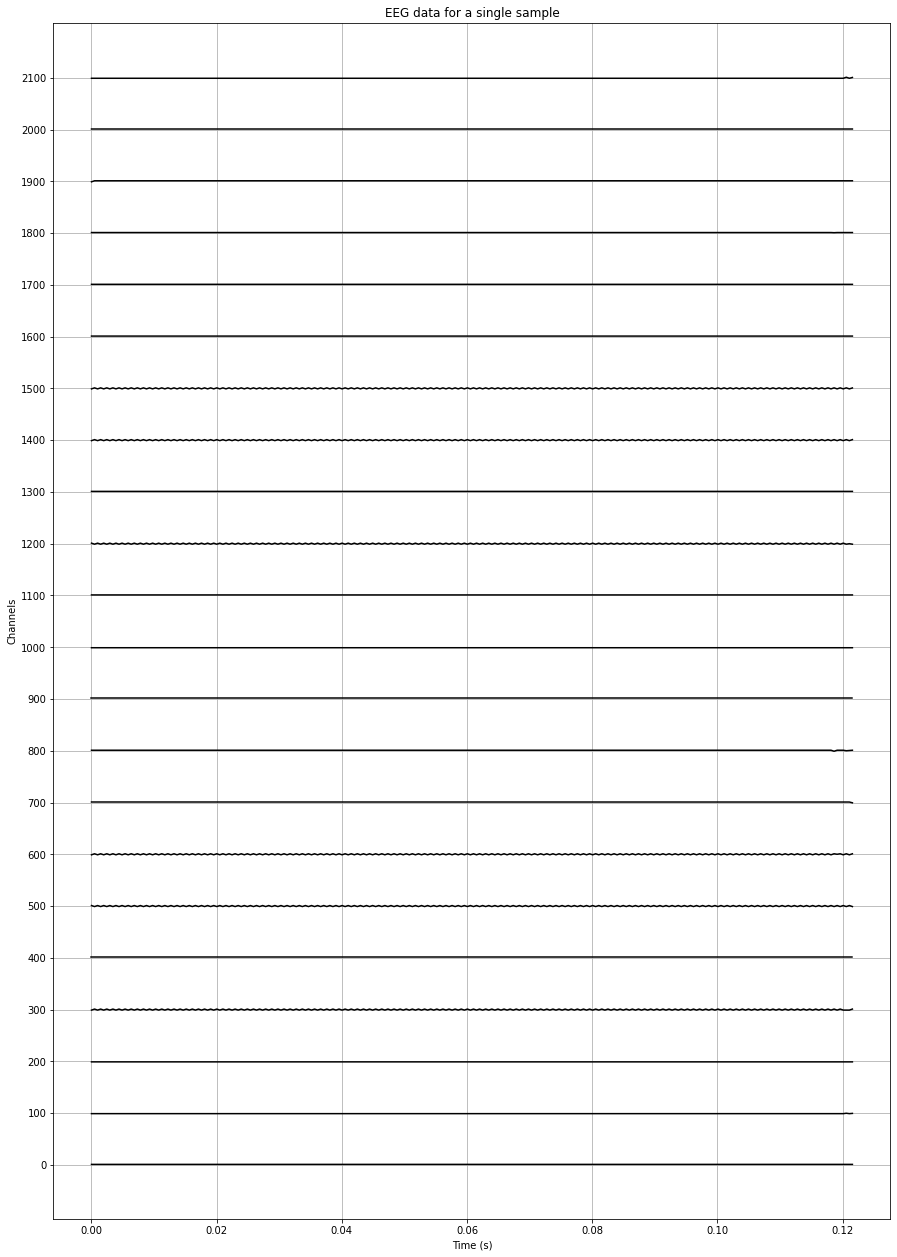

In [ ]:
figure(figsize=(15,22))
plot_eeg(output.detach().numpy())